In [ ]:
# Import Libraries and Set Constant Variables


import numpy as np
from array import *
import csv
import datetime;
from bisect import bisect_left
from bisect import bisect_right

import matplotlib.pyplot as plt
import json

import multiprocessing as mp
from multiprocessing import Process, Queue
from multiprocessing import current_process
import queue
import threading
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"
from pyspark.sql import SparkSession
import pyspark.pandas as ps
from pyspark.sql.functions import col
import pandas as pd
import random
import networkx as nx
from tqdm import tqdm
from community import modularity




In [ ]:
# Define Base and Temporary Directory Paths


BASE_ADDRESS = '/local/scratch/exported/Cardano_MCH_2023_1/'
TEMP_ADDRESS = BASE_ADDRESS + '/temp_files/'


print('----------------------')
print('done!')


----------------------
----------------------
done!


In [ ]:
# Define required methods:


print('----------------------')

# ct stores current time
ct = datetime.datetime.now()
print("current time: ", ct)



##########################################################################################
def parent (id1, parents_array):
    return parents_array[id1];

##########################################################################################
def find_parent (id1, parents_array):
    while (id1 != parent(id1, parents_array)):
        new_parent = parent(parent(id1, parents_array), parents_array);
        id1        = new_parent;
    
    return id1

##########################################################################################
# Link two addresses based on "Union-Find" Algorithm:
def link_address (addr_position_1, addr_position_2, parents_array):
    id1 = find_parent(addr_position_1, parents_array)
    id2 = find_parent(addr_position_2, parents_array)

    if (id1 == id2):
        return

    # make sure always we have id1 > id2
    if id1 < id2:
        x = id1
        id1 = id2
        id2 = x

    parents_array[id1] = id2
    return

##########################################################################################
def resolveAll (parents_array):
    for id1 in tqdm(range(len(parents_array))):
        parents_array[id1] = find_parent(id1, parents_array);
    return

##########################################################################################
def remapClusterIds (parents_array, clustering_array):
    cluster_count = 0
    place_holder = 9999999999999
    new_cluster_ids = [place_holder] * len(parents_array)
    
    for i in range(len(clustering_array)):
        clustering_array[i] = parents_array[i]

    for i in tqdm(range(len(clustering_array))):
        parent_index = clustering_array[i]

        if (new_cluster_ids [parent_index] == place_holder):
            new_cluster_ids [parent_index] = cluster_count
            cluster_count = cluster_count + 1

        clustering_array[i] = new_cluster_ids [parent_index]

    return cluster_count;

##########################################################################################
def merge_parents(parents_array, parents_merged):
    if (len(parents_array) != len(parents_merged)):
        print('parents_merged Error: -1 (Length)')
        return -1
    
    for i in tqdm(range(len(parents_merged))):
        link_address (i, parents_array[i], parents_merged)


##########################################################################################
def BinarySearch(a, x, debug=True):
    i = bisect_left(a, x)
    if i < len(a) and a[i] == x:
        return i
    else:
        if(debug):
            print('BinarySearch Error: -1')
        return -1

##########################################################################################
def BinarySearch_Find_start_end(a, x):
    i = bisect_left(a, x)
    j = bisect_right(a, x) - 1
    if i < len(a) and a[i] == x and j < len(a) and a[j] == x:
        return [i, j]
    else:
        print('BinarySearch Error: -1')
        print('i = ', i)
        print('j = ', j)
        return -1


##########################################################################################
def store_array_to_file (input_array_name, file_name, index_=False, header_=None):
    ct = datetime.datetime.now()
    curr_timestamp = str(ct)[0:10] + '_' + str(ct)[11:13] + str(ct)[14:16] + str(ct)[17:19]
    print('start time (Store Array to ' + file_name + '): ', ct)

    df = pd.DataFrame(input_array_name)
    df.to_csv(file_name, index=index_, header=header_)

    '''
    with open(file_name, 'w') as filehandle:
        for element in input_array_name:
            filehandle.write(f'{element}\n')
    '''

    et = datetime.datetime.now() - ct
    print('elapsed time (Store Array to ' + file_name + '): ', et)

    return

##########################################################################################
def load_file_to_array (file_name, header_=None):
    ct = datetime.datetime.now()
    curr_timestamp = str(ct)[0:10] + '_' + str(ct)[11:13] + str(ct)[14:16] + str(ct)[17:19]
    print('start time (Load ' + file_name  + ' to Array): ', ct)

    df = pd.read_csv(file_name, header=header_)
    output_array_name = df.to_numpy()
    
    '''
    output_array_name = []
    with open(file_name, 'r') as filehandle:
        for line in filehandle:
            # Remove linebreak which is the last character of the string
            curr_place = line[:-1]
            # Add item to the list
            output_array_name.append(curr_place)
    '''    

    '''
    for index, row in df.iterrows():
        new_line = df.loc[index , 0]
        output_array_name.append(new_line)
        if (index%1000000 == 0):
                print('One New Milion Records loaded: ', index)
    '''

    et = datetime.datetime.now() - ct
    print('elapsed time (Load ' + file_name  + ' to Array): ', et)
    
    return output_array_name

##########################################################################################
def store_array_to_file_2D (input_array_name, file_name):
    ct = datetime.datetime.now()
    curr_timestamp = str(ct)[0:10] + '_' + str(ct)[11:13] + str(ct)[14:16] + str(ct)[17:19]
    print('start time (Store Array 2D to ' + file_name + '): ', ct)

    with open(file_name, "w") as filehandle:
        json.dump(input_array_name, filehandle)
    
    et = datetime.datetime.now() - ct
    print('elapsed time (Store Array 2D to ' + file_name + '): ', et)

    return

##########################################################################################
def load_file_to_array_2D (file_name):
    ct = datetime.datetime.now()
    curr_timestamp = str(ct)[0:10] + '_' + str(ct)[11:13] + str(ct)[14:16] + str(ct)[17:19]
    print('start time (Load ' + file_name  + ' to Array 2D): ', ct)

    with open(file_name) as filehandle:
        output_array_name = json.load(filehandle)

    et = datetime.datetime.now() - ct
    print('elapsed time (Load ' + file_name  + ' to Array 2D): ', et)
    
    return output_array_name


##########################################################################################
def store_dict_to_file_INT (input_dict_name, file_name):
    ct = datetime.datetime.now()
    curr_timestamp = str(ct)[0:10] + '_' + str(ct)[11:13] + str(ct)[14:16] + str(ct)[17:19]
    print('start time (Store Dictionary to ' + file_name + '): ', ct)

    filehandle = csv.writer(open(file_name, 'w'))
    for key, val in input_dict_name.items():
        filehandle.writerow([key, val])

    et = datetime.datetime.now() - ct
    print('elapsed time (Store Dictionary to ' + file_name + '): ', et)

    return

##########################################################################################
def load_file_to_dict_INT (file_name):
    ct = datetime.datetime.now()
    curr_timestamp = str(ct)[0:10] + '_' + str(ct)[11:13] + str(ct)[14:16] + str(ct)[17:19]
    print('start time (Load ' + file_name  + ' to Dictionary): ', ct)

    filehandle = csv.reader(open(file_name, 'r'))
    output_dict_name = {int(rows[0]):int(rows[1]) for rows in filehandle}

    et = datetime.datetime.now() - ct
    print('elapsed time (Load ' + file_name  + ' to Dictionary): ', et)
    
    return output_dict_name

##########################################################################################
def add_edge_info(node_1, node_2, edges_array, weight=1):
    if (node_1 == node_2):
        return

    # make sure always we have n1 > n2:
    if (node_1 < node_2):
        n1 = node_2
        n2 = node_1
    else:
        n1 = node_1
        n2 = node_2

    for i in range(weight):
        edges_array[n1].append(n2)

    return

##########################################################################################
def extract_payment_delegation_parts(address_raw, payment_cred, stake_address):
    if (address_raw == ''):
        #print(' - Error: address_raw is empty!')
        return ['', '']

    if (address_raw[2] == '8'): #Byron Address
        if (payment_cred != ''):
            print(' - Error: payment_cred in Byron Address is NOT empty!')
            return ['', '']
        if (stake_address != ''):
            print(' - Error: stake_address in Byron Address is NOT empty!')
            return ['', '']
        payment_part    = address_raw
        delegation_part = ''

    else: #Shelley Address
        if (payment_cred == ''):
            print(' - Error: payment_cred in Shelley Address is empty!')
            return ['', '']
        payment_part    = payment_cred
        delegation_part = stake_address

    return [payment_part, delegation_part]

##########################################################################################
# Function which calculates the Gini index
# Inputs: array with length equal to number of agents; each element in array represents the wealth of the agent
# Outputs: gini index of the system
def gini_index(inp_array):
    array = np.array(inp_array)
    array = array.astype(float)
    array = array.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(array) < 0:
        array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0] #number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient

##########################################################################################
print('----------------------')
print('done!')



----------------------
current time:  2024-01-23 17:23:06.796294
----------------------
done!


In [ ]:
# Read ("sorted" "unique" array_list) [raw_address_list/payment_address_list/delegation_address_list] from file:

print('----------------------')


file_name = BASE_ADDRESS + '/Unique_AddressesListRaw__Cardano_TXs_All__2023-02-28_143357.txt'
unique_raw_addresses = load_file_to_array (file_name)
print('Length of \"unique_raw_addresses\" = ' + str(len(unique_raw_addresses)))


file_name = BASE_ADDRESS + '/Unique_AddressesListPayment__Cardano_TXs_All__2023-02-28_143953.txt'
unique_payment_addresses = load_file_to_array (file_name)
print('Length of \"unique_payment_addresses\" = ' + str(len(unique_payment_addresses)))


file_name = BASE_ADDRESS + '/Unique_AddressesListDelegation__Cardano_TXs_All__2023-02-28_144415.txt'
unique_delegation_addresses = load_file_to_array (file_name)
print('Length of \"unique_delegation_addresses\" = ' + str(len(unique_delegation_addresses)))



##########################################################################################
INITIAL_DATE_CARDANO      = datetime.datetime.strptime('2017-09-23 21:44:51', '%Y-%m-%d %H:%M:%S').date()
FINAL_DATE_CARDANO        = datetime.datetime.strptime('2023-01-21 17:39:30', '%Y-%m-%d %H:%M:%S').date()
total_time_length_CARDANO = int((FINAL_DATE_CARDANO - INITIAL_DATE_CARDANO).total_seconds()/86400) + 1

unique_raw_addresses_len        = len(unique_raw_addresses)
unique_payment_addresses_len    = len(unique_payment_addresses)
unique_delegation_addresses_len = len(unique_delegation_addresses)


##########################################################################################
print('----------------------')
print('done!')



----------------------
start time (Load /local/scratch/exported/Cardano_MCH_2023_1//Unique_AddressesListRaw__Cardano_TXs_All__2023-02-28_143357.txt to Array):  2024-01-23 17:23:09.977001
elapsed time (Load /local/scratch/exported/Cardano_MCH_2023_1//Unique_AddressesListRaw__Cardano_TXs_All__2023-02-28_143357.txt to Array):  0:01:01.335690
Length of "unique_raw_addresses" = 40330345
start time (Load /local/scratch/exported/Cardano_MCH_2023_1//Unique_AddressesListPayment__Cardano_TXs_All__2023-02-28_143953.txt to Array):  2024-01-23 17:24:11.313840
elapsed time (Load /local/scratch/exported/Cardano_MCH_2023_1//Unique_AddressesListPayment__Cardano_TXs_All__2023-02-28_143953.txt to Array):  0:00:52.197469
Length of "unique_payment_addresses" = 40324960
start time (Load /local/scratch/exported/Cardano_MCH_2023_1//Unique_AddressesListDelegation__Cardano_TXs_All__2023-02-28_144415.txt to Array):  2024-01-23 17:25:03.512205
elapsed time (Load /local/scratch/exported/Cardano_MCH_2023_1//Unique_

In [ ]:
# Read Address Clustering Results from Files:

file_name = BASE_ADDRESS + '/clusteringArrayList_Heuristic1noSC__Cardano_TXs_All__2023-02-25_223957.txt'
clustering_array_heur1 = load_file_to_array (file_name)


file_name = BASE_ADDRESS + '/clusteringArrayList_Heuristic2__Cardano_TXs_All__2023-03-26_110150.txt'
clustering_array_heur2 = load_file_to_array (file_name)


file_name = BASE_ADDRESS + '/clusteringArrayList_Heuristic1noSC_AND_Heuristic2__Cardano_TXs_All__2023-03-26_141212.txt'
clustering_array_heur1and2 = load_file_to_array (file_name)


##########################################################################################
print('----------------------')
print('done!')



start time (Load /local/scratch/exported/Cardano_MCH_2023_1//clusteringArrayList_Heuristic1noSC__Cardano_TXs_All__2023-02-25_223957.txt to Array):  2024-01-23 17:25:07.647603
elapsed time (Load /local/scratch/exported/Cardano_MCH_2023_1//clusteringArrayList_Heuristic1noSC__Cardano_TXs_All__2023-02-25_223957.txt to Array):  0:00:03.112300
start time (Load /local/scratch/exported/Cardano_MCH_2023_1//clusteringArrayList_Heuristic2__Cardano_TXs_All__2023-03-26_110150.txt to Array):  2024-01-23 17:25:10.760263
elapsed time (Load /local/scratch/exported/Cardano_MCH_2023_1//clusteringArrayList_Heuristic2__Cardano_TXs_All__2023-03-26_110150.txt to Array):  0:00:02.968797
start time (Load /local/scratch/exported/Cardano_MCH_2023_1//clusteringArrayList_Heuristic1noSC_AND_Heuristic2__Cardano_TXs_All__2023-03-26_141212.txt to Array):  2024-01-23 17:25:13.729402
elapsed time (Load /local/scratch/exported/Cardano_MCH_2023_1//clusteringArrayList_Heuristic1noSC_AND_Heuristic2__Cardano_TXs_All__2023-03

In [ ]:
# Find number of members in each cluster (Heur1):


print('----------------------')
ct = datetime.datetime.now()
print("start time: ", ct)

print('----------------------')
sorted_clustering_array_heur1 = np.sort(clustering_array_heur1, axis=None)  # sort the flattened array
print('clustering_array_heur1 was sorted !')


num_of_clusters_heur1 = max(sorted_clustering_array_heur1) + 1
print('number of clusters_heur1 = ', num_of_clusters_heur1)


num_of_cluster_members_heur1 = np.array([0] * num_of_clusters_heur1)

for i in tqdm(range(num_of_clusters_heur1)):
    x = BinarySearch_Find_start_end(sorted_clustering_array_heur1, i)
    num_of_cluster_members_heur1[i] = x[1] - x[0] + 1

    
print('----------------------')
print('number of unique addresses (to verify num_of_cluster_members_heur1) = ', sum(num_of_cluster_members_heur1))


print('----------------------')
et = datetime.datetime.now() - ct
print("elapsed time: ", et)


##########################################################################################

print('----------------------')
print('done!')



----------------------
start time:  2023-12-16 23:18:48.882215
----------------------
clustering_array_heur1 was sorted !
number of clusters_heur1 =  19249106


100%|██████████| 19249106/19249106 [05:03<00:00, 63443.06it/s]

----------------------
number of unique addresses (to verify num_of_cluster_members_heur1) =  40324960
----------------------
elapsed time:  0:05:17.907648
----------------------
done!


In [15]:
# Find number of members in each cluster (Heur2):

'''
print('----------------------')
ct = datetime.datetime.now()
print("start time: ", ct)

print('----------------------')
sorted_clustering_array_heur2 = np.sort(clustering_array_heur2, axis=None)  # sort the flattened array
print('clustering_array_heur2 was sorted !')


num_of_clusters_heur2 = max(sorted_clustering_array_heur2) + 1
print('number of clusters_heur2 = ', num_of_clusters_heur2)


num_of_cluster_members_heur2 = np.array([0] * num_of_clusters_heur2)

for i in tqdm(range(num_of_clusters_heur2)):
    x = BinarySearch_Find_start_end(sorted_clustering_array_heur2, i)
    num_of_cluster_members_heur2[i] = x[1] - x[0] + 1

    
print('----------------------')
print('number of unique addresses (to verify num_of_cluster_members_heur2) = ', sum(num_of_cluster_members_heur2))


print('----------------------')
et = datetime.datetime.now() - ct
print("elapsed time: ", et)


##########################################################################################

print('----------------------')
print('done!')
'''


----------------------
start time:  2023-12-12 13:44:49.807221
----------------------
clustering_array_heur2 was sorted !
number of clusters_heur2 =  18529342


100%|██████████| 18529342/18529342 [04:48<00:00, 64264.73it/s]

----------------------
number of unique addresses (to verify num_of_cluster_members_heur2) =  40324960
----------------------
elapsed time:  0:05:00.749087
----------------------
done!


In [7]:
# Find number of members in each cluster (Heur1 and Heur2):

'''
print('----------------------')
ct = datetime.datetime.now()
print("start time: ", ct)

print('----------------------')
sorted_clustering_array_heur1and2 = np.sort(clustering_array_heur1and2, axis=None)  # sort the flattened array
print('clustering_array_heur1and2 was sorted !')


num_of_clusters_heur1and2 = max(sorted_clustering_array_heur1and2) + 1
print('number of clusters_heur1and2 = ', num_of_clusters_heur1and2)


num_of_cluster_members_heur1and2 = np.array([0] * num_of_clusters_heur1and2)

for i in tqdm(range(num_of_clusters_heur1and2)):
    x = BinarySearch_Find_start_end(sorted_clustering_array_heur1and2, i)
    num_of_cluster_members_heur1and2[i] = x[1] - x[0] + 1

    
print('----------------------')
print('number of unique addresses (to verify num_of_cluster_members_heur1and2) = ', sum(num_of_cluster_members_heur1and2))


entity_size_array_heur1and2 = num_of_cluster_members_heur1and2

print('----------------------')
et = datetime.datetime.now() - ct
print("elapsed time: ", et)


##########################################################################################

print('----------------------')
print('done!')
'''



----------------------
start time:  2023-12-14 08:01:34.989145
----------------------
clustering_array_heur1and2 was sorted !
number of clusters_heur1and2 =  8805791


100%|██████████| 8805791/8805791 [02:16<00:00, 64617.63it/s]

----------------------
number of unique addresses (to verify num_of_cluster_members_heur1and2) =  40324960
----------------------
elapsed time:  0:02:27.972288
----------------------
done!


Calculating best minimal value for power law fit
fit.power_law.alpha =  2.3146789483125705
fit.power_law.sigma =  0.003321771524029662
fit.power_law.xmin =  12.0
fit.power_law.xmax =  None
fit.distribution_compare('power_law', 'exponential') =  (233503.31057976032, 7.43021020615123e-26)


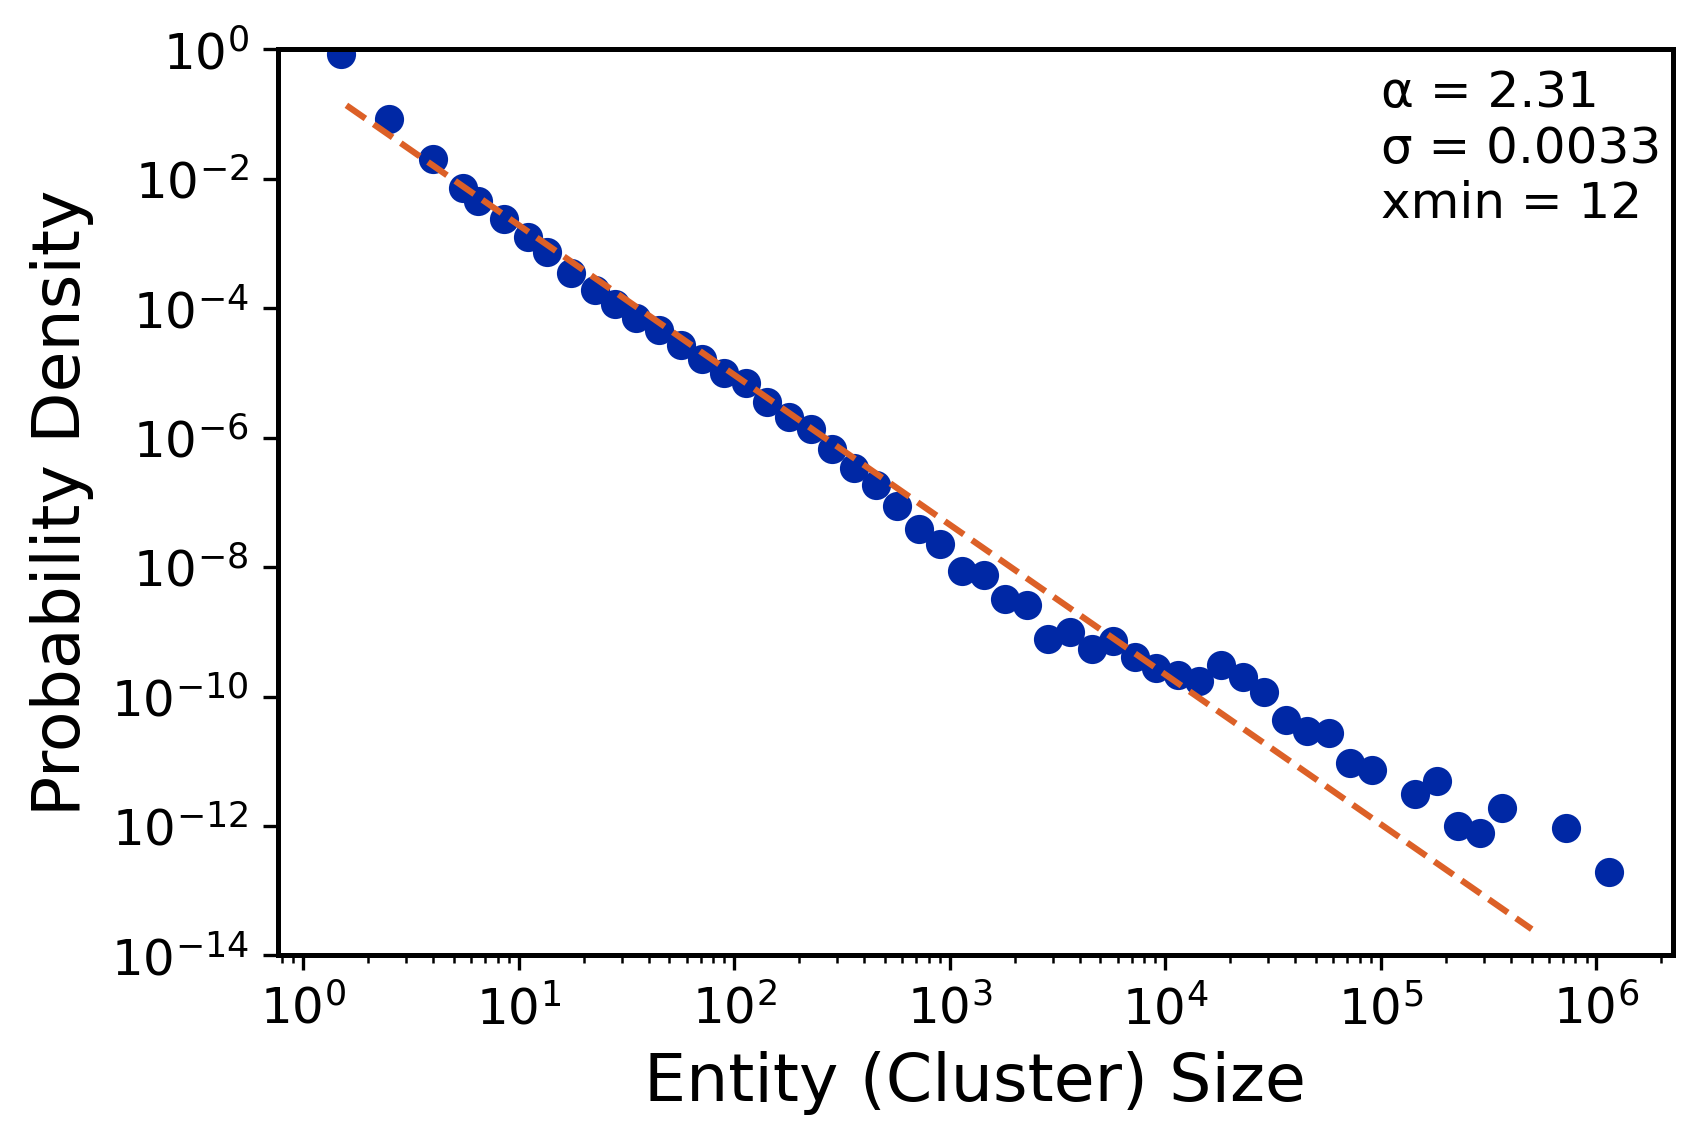

In [ ]:
# power-law distributions (Heur 1):

fit = powerlaw.Fit(num_of_cluster_members_heur1)

print('fit.power_law.alpha = ', fit.power_law.alpha)
print('fit.power_law.sigma = ', fit.power_law.sigma)
print('fit.power_law.xmin = ',  fit.power_law.xmin)
print('fit.power_law.xmax = ',  fit.power_law.xmax)
print('fit.distribution_compare(\'power_law\', \'exponential\') = ', fit.distribution_compare('power_law', 'exponential'))


plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')

plt.xlabel('Entity (Cluster) Size')
plt.ylabel('Probability Density')


#plt.xlim(left=10)
plt.ylim(bottom=1e-14)
markersize = 3

fig = fit.plot_pdf(linestyle = '', marker='o', original_data=True)
#fit.power_law.plot_pdf(linestyle = 'dashed', ax = fig)
plt.text(10**(5.0), 10**(-0.3), '\u03B1 = ' + str(round(fit.power_law.alpha, 2)) + '\n' + '\u03C3 = ' + str(round(fit.power_law.sigma, 4)) + '\n' + 'xmin = ' + str(round(fit.power_law.xmin)), ha='left', va='top', fontsize=12)


def abline(plt, slope, intercept, x0, x1):
    """Plot a line from slope and intercept"""
    x_vals = np.logspace(x0, x1, num=100)
    y_vals = 10**(intercept) * (x_vals**slope)
    plt.plot(x_vals, y_vals, '--')


abline(plt, -fit.power_law.alpha, -0.4, 0.2, 5.7)

plt.savefig('fig_cluster_mems_dist_heur1.pdf', bbox_inches='tight', facecolor='white')
plt.show()


Calculating best minimal value for power law fit
fit.power_law.alpha =  2.832173729606664
fit.power_law.sigma =  0.018572296210902374
fit.power_law.xmin =  236.0
fit.power_law.xmax =  None
fit.distribution_compare('power_law', 'exponential') =  (9087.015113898487, 1.3988425314467842e-11)


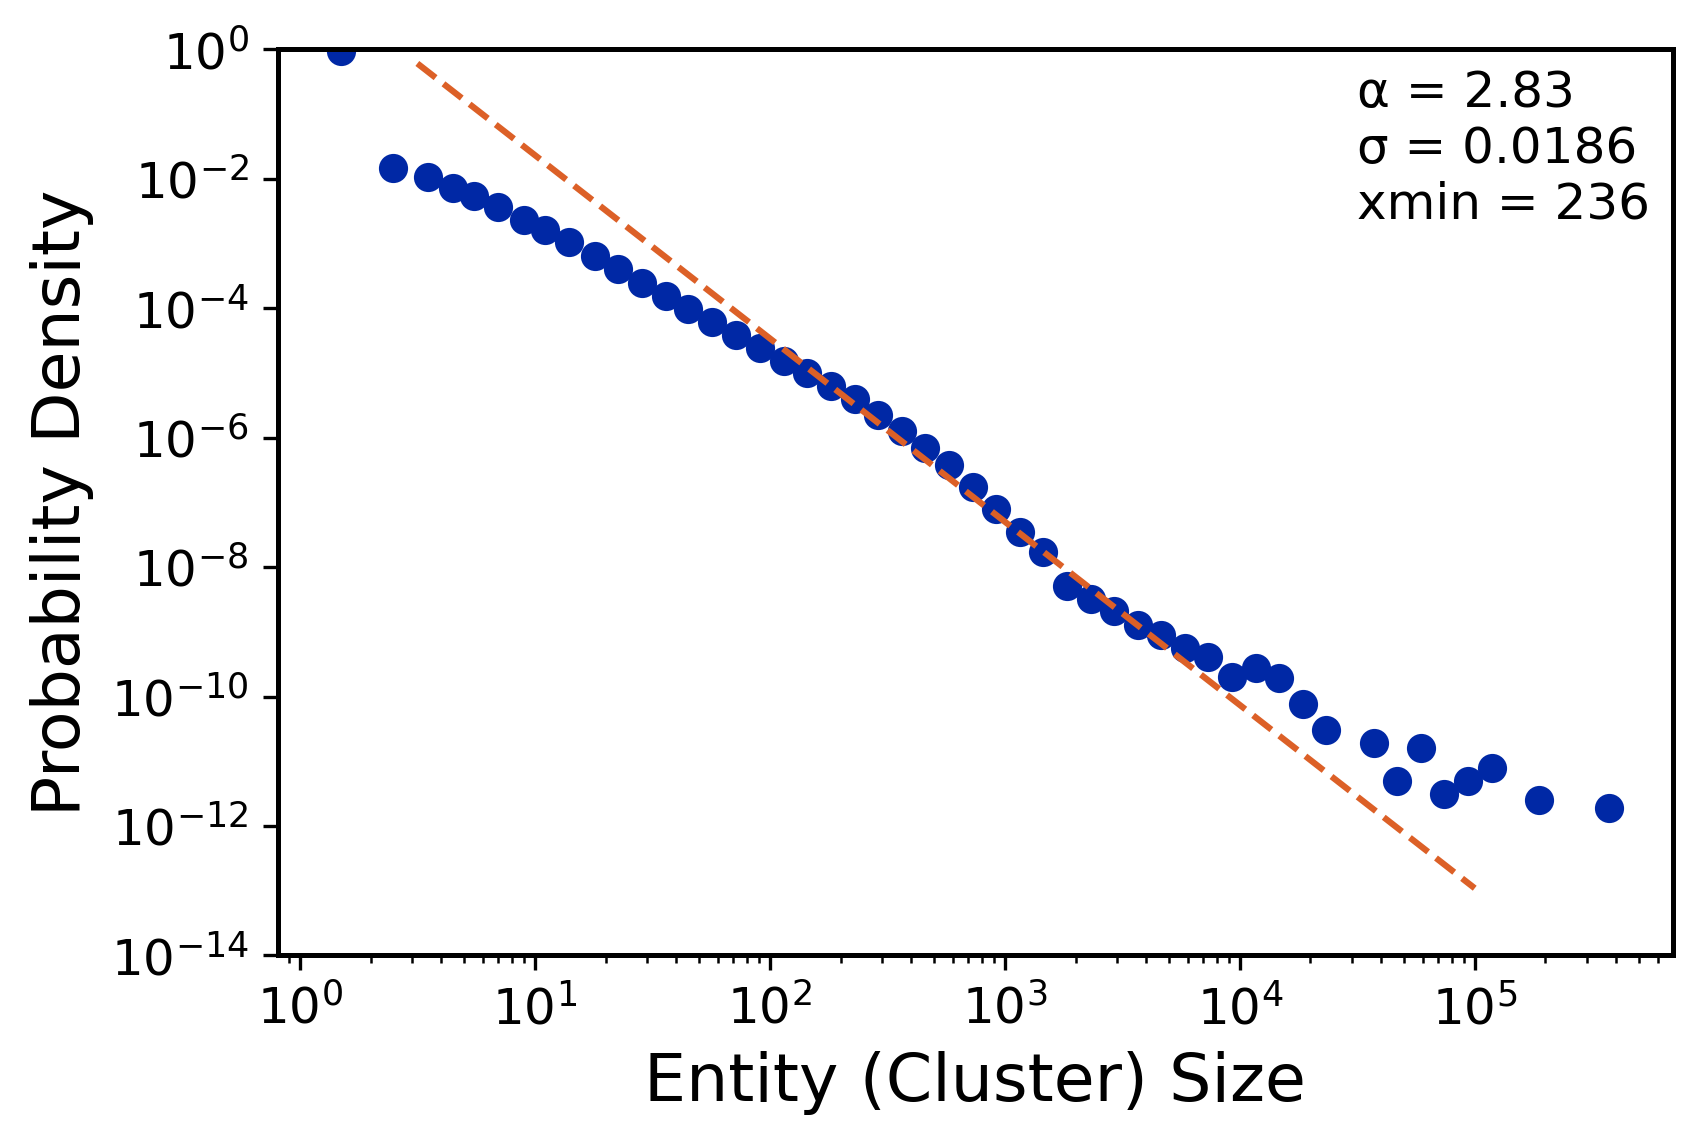

In [20]:
# power-law distributions (Heur 2):

'''
fit = powerlaw.Fit(num_of_cluster_members_heur2)

print('fit.power_law.alpha = ', fit.power_law.alpha)
print('fit.power_law.sigma = ', fit.power_law.sigma)
print('fit.power_law.xmin = ',  fit.power_law.xmin)
print('fit.power_law.xmax = ',  fit.power_law.xmax)
print('fit.distribution_compare(\'power_law\', \'exponential\') = ', fit.distribution_compare('power_law', 'exponential'))



plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')

plt.xlabel('Entity (Cluster) Size')
plt.ylabel('Probability Density')


#plt.xlim(left=10)
plt.ylim(bottom=1e-14)
markersize = 3

fig = fit.plot_pdf(linestyle = '', marker='o', original_data=True)
#fit.power_law.plot_pdf(linestyle = 'dashed', ax = fig)
plt.text(10**(4.5), 10**(-0.3), '\u03B1 = ' + str(round(fit.power_law.alpha, 2)) + '\n' + '\u03C3 = ' + str(round(fit.power_law.sigma, 4)) + '\n' + 'xmin = ' + str(round(fit.power_law.xmin)), ha='left', va='top', fontsize=12)


def abline(plt, slope, intercept, x0, x1):
    """Plot a line from slope and intercept"""
    x_vals = np.logspace(x0, x1, num=100)
    y_vals = 10**(intercept) * (x_vals**slope)
    plt.plot(x_vals, y_vals, '--')


abline(plt, -fit.power_law.alpha, 1.2, 0.5, 5)

plt.savefig('fig_cluster_mems_dist_heur2.pdf', bbox_inches='tight', facecolor='white')
plt.show()
'''



Calculating best minimal value for power law fit
fit.power_law.alpha =  2.1987246819704476
fit.power_law.sigma =  0.0017867964159927283
fit.power_law.xmin =  9.0
fit.power_law.xmax =  None
fit.distribution_compare('power_law', 'exponential') =  (503310.59504978784, 1.901544158587676e-30)


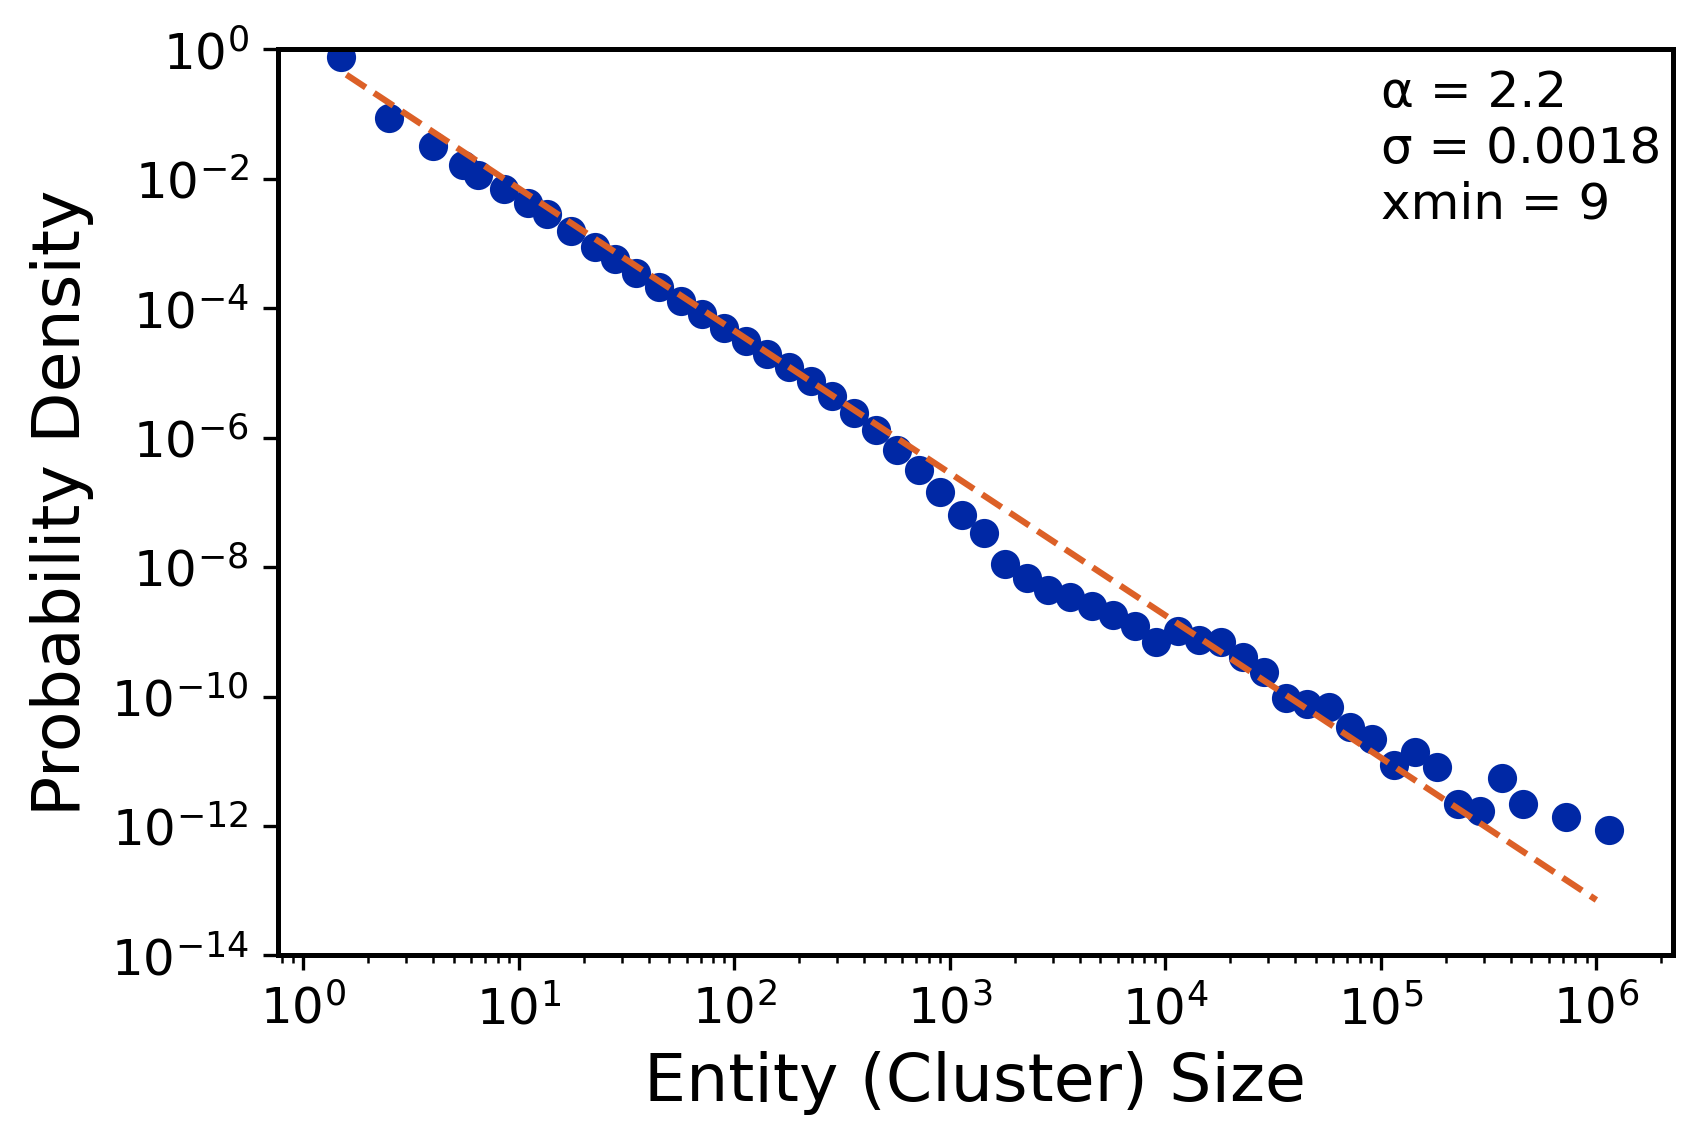

In [22]:
# power-law distributions (Heur1 and Heur2):

'''
fit = powerlaw.Fit(num_of_cluster_members_heur1and2)

print('fit.power_law.alpha = ', fit.power_law.alpha)
print('fit.power_law.sigma = ', fit.power_law.sigma)
print('fit.power_law.xmin = ',  fit.power_law.xmin)
print('fit.power_law.xmax = ',  fit.power_law.xmax)
print('fit.distribution_compare(\'power_law\', \'exponential\') = ', fit.distribution_compare('power_law', 'exponential'))


plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')

plt.xlabel('Entity (Cluster) Size')
plt.ylabel('Probability Density')

#plt.xlim(left=10)
plt.ylim(bottom=1e-14)
markersize = 3

fig = fit.plot_pdf(linestyle = '', marker='o', original_data=True)
#fit.power_law.plot_pdf(linestyle = 'dashed', ax = fig)
plt.text(10**(5.0), 10**(-0.3), '\u03B1 = ' + str(round(fit.power_law.alpha, 2)) + '\n' + '\u03C3 = ' + str(round(fit.power_law.sigma, 4)) + '\n' + 'xmin = ' + str(round(fit.power_law.xmin)), ha='left', va='top', fontsize=12)


def abline(plt, slope, intercept, x0, x1):
    """Plot a line from slope and intercept"""
    x_vals = np.logspace(x0, x1, num=100)
    y_vals = 10**(intercept) * (x_vals**slope)
    plt.plot(x_vals, y_vals, '--')


abline(plt, -fit.power_law.alpha, 0.05, 0.2, 6)

plt.savefig('fig_cluster_mems_dist_heur1and2.pdf', bbox_inches='tight', facecolor='white')
plt.show()
'''



In [ ]:
# Find "Entity" of Each "Stake Address" (Delegation Address) [Heuristic 2]


print('----------------------')

# ct stores current time
ct = datetime.datetime.now()
print("current time: ", ct)
print('----------------------')


INITIAL_DATE_CARDANO      = datetime.datetime.strptime('2017-09-23 21:44:51', '%Y-%m-%d %H:%M:%S').date()
FINAL_DATE_CARDANO        = datetime.datetime.strptime('2023-01-21 17:39:30', '%Y-%m-%d %H:%M:%S').date()
total_time_length_CARDANO = int((FINAL_DATE_CARDANO - INITIAL_DATE_CARDANO).total_seconds()/86400) + 1

current_delta_day = 0
clustering_array = clustering_array_heur2

place_holder = 999999999999
entity_of_stake_addresses = np.array([place_holder] * len(unique_delegation_addresses))

CSV_FILES_NAME_FORMAT = BASE_ADDRESS + '/cardano_TXs_Velocity_'
NUMBER_OF_CSV_FILES = 6
CSV_FILES_SUFFIX = '.csv'


for i in range(1, NUMBER_OF_CSV_FILES + 1):

    ct_temp = datetime.datetime.now()

    file_name = CSV_FILES_NAME_FORMAT + str(i) + CSV_FILES_SUFFIX
    df = pd.read_csv(file_name, delimiter='|')

    et_temp = datetime.datetime.now() - ct_temp
    print("elapsed time (Load CSV File " + file_name + "): ", et_temp)

    ct_temp = datetime.datetime.now()

    for index, row in tqdm(df.iterrows()):
        ##########################################################################################      
        outputs_list = list( df.loc[index , 'OUTPUTs'].split(';') )

        for tx_output in outputs_list:
            address_raw        = tx_output.split(',')[1]
            address_has_script = tx_output.split(',')[4]
            payment_cred       = tx_output.split(',')[5]
            stake_address      = tx_output.split(',')[6]

            [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
            if(address_payment_part != '' and address_delegation_part != ''):
                deleg_addr_indx  = BinarySearch(unique_delegation_addresses, address_delegation_part)
                if(entity_of_stake_addresses[deleg_addr_indx] == place_holder):
                    paymnt_addr_indx = BinarySearch(unique_payment_addresses, address_payment_part)
                    entity_indx = clustering_array[paymnt_addr_indx][0]
                    entity_of_stake_addresses[deleg_addr_indx] = entity_indx

    et_temp = datetime.datetime.now() - ct_temp
    print("elapsed time (Entities of Stake Addresses from CSV File " + file_name + "): ", et_temp)



print('----------------------')
et = datetime.datetime.now() - ct
print("Total elapsed time (Entities of Stake Addresses): ", et)


print('----------------------')
print('done!')




----------------------
current time:  2024-01-23 17:25:35.522291
----------------------
elapsed time (Load CSV File /local/scratch/exported/Cardano_MCH_2023_1//cardano_TXs_Velocity_1.csv):  0:01:42.443508


10000000it [27:10, 6134.56it/s]


elapsed time (Entities of Stake Addresses from CSV File /local/scratch/exported/Cardano_MCH_2023_1//cardano_TXs_Velocity_1.csv):  0:27:10.115110
elapsed time (Load CSV File /local/scratch/exported/Cardano_MCH_2023_1//cardano_TXs_Velocity_2.csv):  0:01:50.855297


10000000it [35:15, 4727.67it/s]


elapsed time (Entities of Stake Addresses from CSV File /local/scratch/exported/Cardano_MCH_2023_1//cardano_TXs_Velocity_2.csv):  0:35:15.210329
elapsed time (Load CSV File /local/scratch/exported/Cardano_MCH_2023_1//cardano_TXs_Velocity_3.csv):  0:01:59.509219


10000000it [37:11, 4481.87it/s]


elapsed time (Entities of Stake Addresses from CSV File /local/scratch/exported/Cardano_MCH_2023_1//cardano_TXs_Velocity_3.csv):  0:37:11.214085
elapsed time (Load CSV File /local/scratch/exported/Cardano_MCH_2023_1//cardano_TXs_Velocity_4.csv):  0:02:08.123212


9887306it [37:51, 4351.84it/s]


elapsed time (Entities of Stake Addresses from CSV File /local/scratch/exported/Cardano_MCH_2023_1//cardano_TXs_Velocity_4.csv):  0:37:51.987198
elapsed time (Load CSV File /local/scratch/exported/Cardano_MCH_2023_1//cardano_TXs_Velocity_5.csv):  0:02:33.116625


9837765it [41:53, 3913.86it/s]


elapsed time (Entities of Stake Addresses from CSV File /local/scratch/exported/Cardano_MCH_2023_1//cardano_TXs_Velocity_5.csv):  0:41:53.573921
elapsed time (Load CSV File /local/scratch/exported/Cardano_MCH_2023_1//cardano_TXs_Velocity_6.csv):  0:02:24.763194


9783500it [43:31, 3746.86it/s]

elapsed time (Entities of Stake Addresses from CSV File /local/scratch/exported/Cardano_MCH_2023_1//cardano_TXs_Velocity_6.csv):  0:43:31.120402
----------------------
Total elapsed time (Entities of Stake Addresses):  3:55:32.299972
----------------------
done!


In [18]:
# Load/Store "entity_of_stake_addresses" from/into file:


print('----------------------')
ct = datetime.datetime.now()
curr_timestamp = str(ct)[0:10] + '_' + str(ct)[11:13] + str(ct)[14:16] + str(ct)[17:19]


# Store "entity_of_stake_addresses" into file:
'''
#output_filename = BASE_ADDRESS + '/Entities_related_to_Stake_Addresses__Heuristic1noSC_AND_Heuristic2__Cardano_TXs_All__' + curr_timestamp + '.txt'
#print('output_filename = ', output_filename)
#store_array_to_file(entity_of_stake_addresses, output_filename)

output_filename = BASE_ADDRESS + '/Entities_related_to_Stake_Addresses__Heuristic2__Cardano_TXs_All__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)
store_array_to_file(entity_of_stake_addresses, output_filename)
'''



# Load  "entity_of_stake_addresses" from file:

#file_name = BASE_ADDRESS + '/Entities_related_to_Stake_Addresses__Heuristic1noSC_AND_Heuristic2__Cardano_TXs_All__2023-12-12_190821.txt'
#entity_of_stake_addresses = load_file_to_array(file_name)

file_name = BASE_ADDRESS + '/Entities_related_to_Stake_Addresses__Heuristic2__Cardano_TXs_All__2024-01-23_212107.txt'
entity_of_stake_addresses = load_file_to_array(file_name)



##########################################################################################
print('----------------------')
print('done!')


----------------------
start time (Load /local/scratch/exported/Cardano_MCH_2023_1//Entities_related_to_Stake_Addresses__Heuristic2__Cardano_TXs_All__2024-01-23_212107.txt to Array):  2024-01-24 12:18:15.982561
elapsed time (Load /local/scratch/exported/Cardano_MCH_2023_1//Entities_related_to_Stake_Addresses__Heuristic2__Cardano_TXs_All__2024-01-23_212107.txt to Array):  0:00:00.356441
----------------------
done!


In [ ]:
# Calculate Entity Balances [Heuristic 2]


print('----------------------')
import random
import pickle


# ct stores current time
ct = datetime.datetime.now()
print("current time: ", ct)
print('----------------------')


INITIAL_DATE_CARDANO      = datetime.datetime.strptime('2017-09-23 21:44:51', '%Y-%m-%d %H:%M:%S').date()
FINAL_DATE_CARDANO        = datetime.datetime.strptime('2023-01-21 17:39:30', '%Y-%m-%d %H:%M:%S').date()
total_time_length_CARDANO = int((FINAL_DATE_CARDANO - INITIAL_DATE_CARDANO).total_seconds()/86400) + 1



# Choose from: "clustering_array_heur1"  OR  "clustering_array_heur2"  OR  "clustering_array_heur1and2"
clustering_array = clustering_array_heur2

balances_per_entity_array = [0] * ( np.amax(clustering_array)+1 )
current_delta_day = 0



CSV_FILES_NAME_FORMAT = BASE_ADDRESS + '/cardano_TXs_Velocity_'
NUMBER_OF_CSV_FILES = 6
CSV_FILES_SUFFIX = '.csv'


for i in range(1, NUMBER_OF_CSV_FILES + 1):

    ct_temp = datetime.datetime.now()

    file_name = CSV_FILES_NAME_FORMAT + str(i) + CSV_FILES_SUFFIX
    df = pd.read_csv(file_name, delimiter='|')

    et_temp = datetime.datetime.now() - ct_temp
    print("elapsed time (Load CSV File " + file_name + "): ", et_temp)

    ct_temp = datetime.datetime.now()

    for index, row in tqdm(df.iterrows()):
        ##########################################################################################
        TX_ID      = df.loc[index , 'TX_ID']
        ##########################################################################################
        BLOCK_TIME = datetime.datetime.strptime(str(df.loc[index , 'BLOCK_TIME']), '%Y-%m-%d %H:%M:%S').date()
        tx_delta_day = int((BLOCK_TIME - INITIAL_DATE_CARDANO).total_seconds()/86400)
        if(current_delta_day < tx_delta_day):
            output_filename = BASE_ADDRESS + '/YuZhang_Cardano_Balances_Entities_Heur2__PICKLE/YuZhang__BalancesPerEntityDay_Heur2_' + str(current_delta_day).zfill(4) + '__Cardano_TXs_All.pickle'
            #print('output_filename = ', output_filename)
            pickle.dump(balances_per_entity_array, open(output_filename, 'wb'))
            #store_array_to_file(balances_per_entity_array, output_filename)
            current_delta_day = tx_delta_day

        ##########################################################################################
        EPOCH_NO   = str( df.loc[index , 'EPOCH_NO'] )
        ##########################################################################################
        inputs_list = list( df.loc[index , 'INPUTs'].split(';') )
        outputs_list = list( df.loc[index , 'OUTPUTs'].split(';') )
        ##########################################################################################
        # Update all ADA balances:
        for i in range(0, len(inputs_list)):
            address_has_script = inputs_list[i].split(',')[7]
            
            #if (address_has_script == 'f'): # non-Smart Contract Address
            address_raw   = inputs_list[i].split(',')[4]
            payment_cred  = inputs_list[i].split(',')[8]
            stake_address = inputs_list[i].split(',')[9]
            [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
            if (address_payment_part != ''):
                addr_indx   = BinarySearch(unique_payment_addresses, address_payment_part)
                entity_indx = clustering_array[addr_indx][0]
                UTXO_value  = int(inputs_list[i].split(',')[6])
                balances_per_entity_array[entity_indx] = balances_per_entity_array[entity_indx] - int(UTXO_value)



        for i in range(0, len(outputs_list)):
            address_has_script = outputs_list[i].split(',')[4]
            
            #if (address_has_script == 'f'): # non-Smart Contract Address
            address_raw   = outputs_list[i].split(',')[1]
            payment_cred  = outputs_list[i].split(',')[5]
            stake_address = outputs_list[i].split(',')[6]
            [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
            if (address_payment_part != ''):
                addr_indx   = BinarySearch(unique_payment_addresses, address_payment_part)
                entity_indx = clustering_array[addr_indx][0]
                UTXO_value  = int(outputs_list[i].split(',')[3])
                balances_per_entity_array[entity_indx] = balances_per_entity_array[entity_indx] + int(UTXO_value)

        ##########################################################################################

    et_temp = datetime.datetime.now() - ct_temp
    print("elapsed time (Entity Balances [Heur 2] from CSV File " + file_name + "): ", et_temp)



print('----------------------')
et = datetime.datetime.now() - ct
print("Total elapsed time (Entity Balances [Heur 2]): ", et)


print('----------------------')
print('done!')



----------------------
current time:  2024-01-23 23:55:06.001941
----------------------
elapsed time (Load CSV File /local/scratch/exported/Cardano_MCH_2023_1//cardano_TXs_Velocity_1.csv):  0:01:37.966345


10000000it [1:44:24, 1596.17it/s]


elapsed time (ADA Velocity from CSV File /local/scratch/exported/Cardano_MCH_2023_1//cardano_TXs_Velocity_1.csv):  1:44:24.995924
elapsed time (Load CSV File /local/scratch/exported/Cardano_MCH_2023_1//cardano_TXs_Velocity_2.csv):  0:01:44.076014


10000000it [1:37:49, 1703.69it/s]


elapsed time (ADA Velocity from CSV File /local/scratch/exported/Cardano_MCH_2023_1//cardano_TXs_Velocity_2.csv):  1:37:49.606207
elapsed time (Load CSV File /local/scratch/exported/Cardano_MCH_2023_1//cardano_TXs_Velocity_3.csv):  0:01:54.094993


10000000it [1:49:05, 1527.79it/s]


elapsed time (ADA Velocity from CSV File /local/scratch/exported/Cardano_MCH_2023_1//cardano_TXs_Velocity_3.csv):  1:49:05.385081
elapsed time (Load CSV File /local/scratch/exported/Cardano_MCH_2023_1//cardano_TXs_Velocity_4.csv):  0:02:03.700594


9887306it [1:55:52, 1422.12it/s]


elapsed time (ADA Velocity from CSV File /local/scratch/exported/Cardano_MCH_2023_1//cardano_TXs_Velocity_4.csv):  1:55:52.497101
elapsed time (Load CSV File /local/scratch/exported/Cardano_MCH_2023_1//cardano_TXs_Velocity_5.csv):  0:02:20.990941


9837765it [1:59:46, 1368.92it/s]


elapsed time (ADA Velocity from CSV File /local/scratch/exported/Cardano_MCH_2023_1//cardano_TXs_Velocity_5.csv):  1:59:46.494990
elapsed time (Load CSV File /local/scratch/exported/Cardano_MCH_2023_1//cardano_TXs_Velocity_6.csv):  0:02:30.761018


6596759it [1:21:06, 1579.14it/s]

In [ ]:
# Calculate Number of Active Delegators/Rewarders (Entities) Per Epoch [Heuristic 2]:


print('----------------------')

# ct stores current time
ct = datetime.datetime.now()
print("current time: ", ct)
print('----------------------')



first_epoch_no = 210
last_epoch_no  = 391
FIRST_DATE_POOLS_STAKING = datetime.datetime.strptime('2020-08-08 21:44:51', '%Y-%m-%d %H:%M:%S').date() # epoch_no = 210
LAST_DATE_POOLS_STAKING  = datetime.datetime.strptime('2023-01-30 21:46:16', '%Y-%m-%d %H:%M:%S').date() # epoch_no = 391



#total_num_of_epochs = int(int((LAST_DATE_POOLS_STAKING - FIRST_DATE_POOLS_STAKING).total_seconds()/86400)/5) + 1
total_num_of_epochs = int(last_epoch_no - first_epoch_no + 1)

epochs_array      = list(range(first_epoch_no, last_epoch_no+1))
epochs_date_array = [0]*len(epochs_array)
for i in range(len(epochs_date_array)):
    epochs_date_array[i] = FIRST_DATE_POOLS_STAKING + datetime.timedelta(days=(i*5))


num_delegator_addresses_per_epoch  = [0 for _ in range(total_num_of_epochs)]
num_delegator_entities_per_epoch   = [0 for _ in range(total_num_of_epochs)]
num_rewarder_addresses_per_epoch   = [0 for _ in range(total_num_of_epochs)]
num_rewarder_entities_per_epoch    = [0 for _ in range(total_num_of_epochs)]



current_epoch = first_epoch_no


file_name = BASE_ADDRESS + '/cardano_pools_4.csv'
df = pd.read_csv(file_name, delimiter='|')


# entity_size_array_heur1and2
# entity_of_stake_addresses
delegator_addresses_per_epoch_SET = set()
delegator_entities_per_epoch_SET  = set()
reward_addresses_per_epoch_SET    = set()
reward_entities_per_epoch_SET     = set()


clustering_array = clustering_array_heur2


stake_deleg_by_entities = [0] * ( np.amax(clustering_array)+1 )
reward_by_entities      = [0] * ( np.amax(clustering_array)+1 )


#stake_deleg_by_addresses = [0] * len(unique_delegation_addresses)
#reward_by_addresses      = [0] * len(unique_delegation_addresses)



for index, row in tqdm(df.iterrows()):
    ##########################################################################################
    EPOCH             = int(  df.loc[index ,  'EPOCH']             )
    POOL_ID           = int(  df.loc[index ,  'POOL_ID']           )
    POOL_HASH_BECH32  =       df.loc[index ,  'POOL_HASH_BECH32']
    POOL_STAKES       = int(  df.loc[index ,  'POOL_STAKES']       )
    POOL_REWARDS      = int(  df.loc[index ,  'POOL_REWARDS']      )
    NUM_OF_DELEGATORS = int(  df.loc[index ,  'NUM_OF_DELEGATORS'] )
    NUM_OF_REWARDERS  = int(  df.loc[index ,  'NUM_OF_REWARDERS']  )
    DELEGATORs        = list( df.loc[index , 'DELEGATORs'].split(';') )
    if(not pd.isna(df.loc[index, 'REWARDERs'])):
        REWARDERs     = list( df.loc[index , 'REWARDERs'].split(';') )
    else:
        REWARDERs     = list()

    ##########################################################################################
    if(EPOCH < first_epoch_no):
        continue;

    ##########################################################################################
    if(EPOCH > current_epoch):
        num_delegator_addresses_per_epoch [current_epoch - first_epoch_no] = len(delegator_addresses_per_epoch_SET)
        num_delegator_entities_per_epoch  [current_epoch - first_epoch_no] = len(delegator_entities_per_epoch_SET)

        num_rewarder_addresses_per_epoch  [current_epoch - first_epoch_no] = len(reward_addresses_per_epoch_SET)
        num_rewarder_entities_per_epoch   [current_epoch - first_epoch_no] = len(reward_entities_per_epoch_SET)

        delegator_addresses_per_epoch_SET.clear()
        delegator_entities_per_epoch_SET.clear()

        reward_addresses_per_epoch_SET.clear()
        reward_entities_per_epoch_SET.clear()

        output_filename = BASE_ADDRESS + '/YuZhang_Cardano_StakeDelegation_Entities_Heur2__PICKLE/StakeDelegPerEntityEpoch_Heur2_' + str(current_epoch).zfill(4) + '__Cardano_TXs_All.pickle'
        pickle.dump(stake_deleg_by_entities, open(output_filename, 'wb'))
        #store_array_to_file(stake_deleg_by_entities, output_filename)
        stake_deleg_by_entities = [0] * ( np.amax(clustering_array)+1 )

        output_filename = BASE_ADDRESS + '/YuZhang_Cardano_Reward_Entities_Heur2__PICKLE/RewardPerEntityEpoch_Heur2_' + str(current_epoch).zfill(4) + '__Cardano_TXs_All.pickle'
        pickle.dump(reward_by_entities, open(output_filename, 'wb'))
        #store_array_to_file(reward_by_entities, output_filename)
        reward_by_entities      = [0] * ( np.amax(clustering_array)+1 )

        current_epoch      = EPOCH

    ##########################################################################################
    if(EPOCH > last_epoch_no):
        break;

    ##########################################################################################
    for delegator in DELEGATORs:
        #temp_str          = delegator.split(',')
        deleg_addr_id     =      delegator.split(',')[0]
        deleg_amount      = int( delegator.split(',')[1] )
        deleg_stake_addr  =      delegator.split(',')[2]

        deleg_addr_indx   = BinarySearch(unique_delegation_addresses, deleg_stake_addr, debug=False)
        if(deleg_addr_indx != -1):
            deleg_entity_indx = entity_of_stake_addresses[deleg_addr_indx][0]        

            if (deleg_entity_indx < len(stake_deleg_by_entities)):
                stake_deleg_by_entities[deleg_entity_indx] = stake_deleg_by_entities[deleg_entity_indx] + deleg_amount
    
            delegator_addresses_per_epoch_SET.add(deleg_addr_indx)
            delegator_entities_per_epoch_SET.add(deleg_entity_indx)
        else:
            delegator_addresses_per_epoch_SET.add(deleg_stake_addr)
            delegator_entities_per_epoch_SET.add(deleg_stake_addr)  # consider it as a separate entity

    ##########################################################################################
    for rewarder in REWARDERs:
        #temp_str          = rewarder.split(',')
        reward_addr_id    =      rewarder.split(',')[0]
        reward_amount     = int( rewarder.split(',')[1] )
        reward_stake_addr =      rewarder.split(',')[2]
     
        reward_addr_indx   = BinarySearch(unique_delegation_addresses, reward_stake_addr, debug=False)
        if(reward_addr_indx != -1):
            reward_entity_indx = entity_of_stake_addresses[reward_addr_indx][0]
    
            if (reward_entity_indx < len(reward_by_entities)):
                reward_by_entities[reward_entity_indx] = reward_by_entities[reward_entity_indx] + reward_amount
    
            reward_addresses_per_epoch_SET.add(reward_addr_indx)
            reward_entities_per_epoch_SET.add(reward_entity_indx)
        else:
            reward_addresses_per_epoch_SET.add(reward_stake_addr)
            reward_entities_per_epoch_SET.add(reward_stake_addr) # consider it as a separate entity

    ##########################################################################################


    ##########################################################################################


    ##########################################################################################


et = datetime.datetime.now() - ct
print("Total elapsed time: ", et)
print('----------------------')
print('done!')




----------------------
current time:  2024-01-24 12:18:43.548292
----------------------


440391it [5:24:04,  3.45it/s]  

 88%|████████▊ | 87/99 [00:02<00:00, 42.47it/s]/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 99/99 [00:02<00:00, 40.14it/s]


slope =  1.007628874772705
intercept =  -0.0423344523314535
r_value =  0.9999730841453247
p_value =  1.0499286251098587e-97
std_err =  0.0011021030385061947


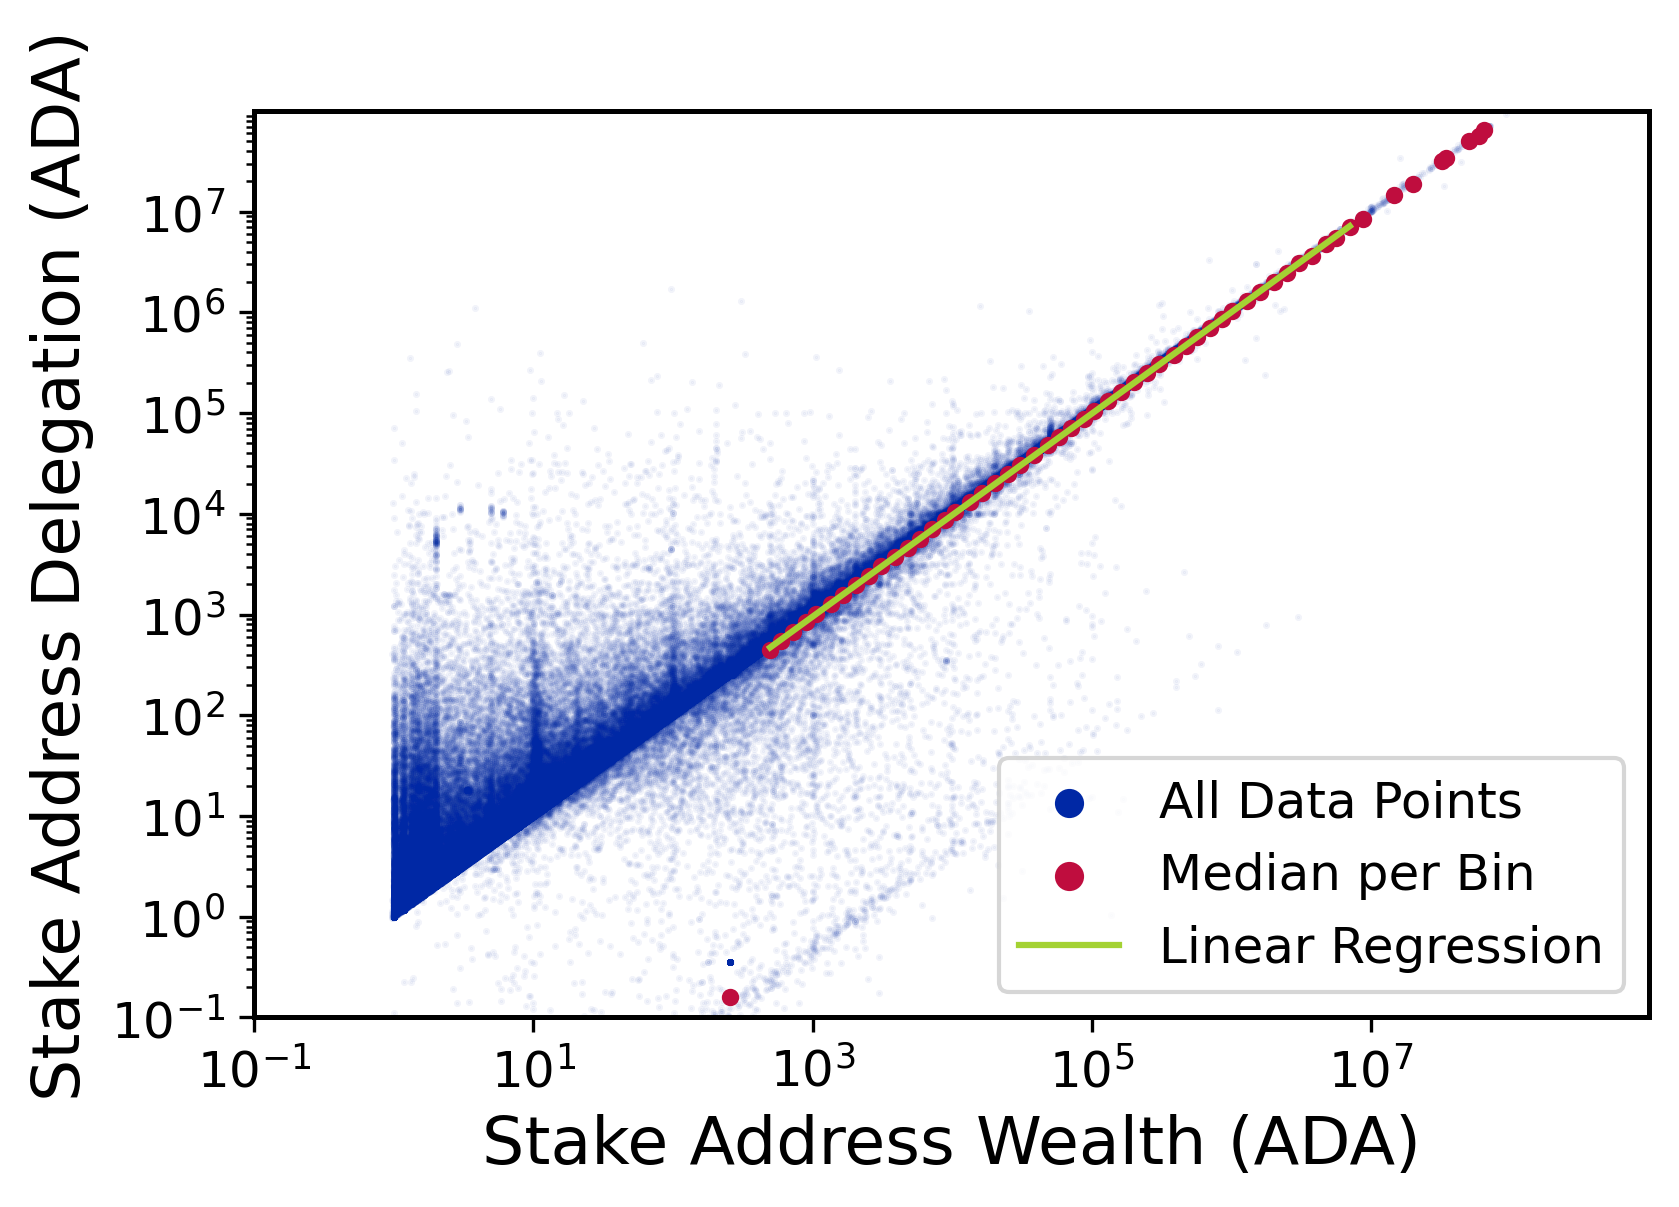

In [ ]:
# PLOT: "Entity Stake Delegation (ADA)" vs. "Entity Wealth (ADA)" [Heur 2]:

from scipy.stats import linregress

from matplotlib import font_manager
font_dirs = ['/home/user/chegeni/fonts']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')


import matplotlib.pyplot as plt

file_name = BASE_ADDRESS + '/YuZhang_Cardano_Balances_Entities_Heur2__PICKLE/YuZhang__BalancesPerEntityDay_Heur2_1945__Cardano_TXs_All.pickle'
#x = load_file_to_array(file_name)
x = pickle.load(open(file_name, 'rb'))


file_name = BASE_ADDRESS + '/YuZhang_Cardano_StakeDelegation_Entities_Heur2__PICKLE/StakeDelegPerEntityEpoch_Heur2_0391__Cardano_TXs_All.pickle'
#y = load_file_to_array(file_name)
y = pickle.load(open(file_name, 'rb'))


#x4 = num_of_entities_per_epoch_cumulative__LATEST
#y4 = count_cumulative_rewarded_pools_per_epoch



x = np.array(x, dtype=np.float64)
x = x/(10**6)  # convert lovelace to ADA
y = np.array(y, dtype=np.float64)
y = y/(10**6) # convert lovelace to ADA

#x4 = np.array(x4)
#y4 = np.array(y4)



# Replace zeros in y with a very small number
small_number = 1e-6
x[x == 0] = small_number
y[y == 0] = small_number


# Transforming data to log space
log_x = np.log10(x)
log_y = np.log10(y)

# Define bin edges in log space
bin_edges_x = np.logspace(0.01, np.max(log_x), 100)
#bin_edges_y = np.logspace(np.min(log_y), np.max(log_y), 100)

# Digitize/assign each point to a bin
bin_indices_x = np.digitize(log_x, bins=np.log10(bin_edges_x))
#bin_indices_y = np.digitize(log_y, bins=np.log10(bin_edges_y))


# Calculate mean/median in each bin
binned_data = []
for i in tqdm(range(1, len(bin_edges_x))):
    #for j in range(1, len(bin_edges_y)):
        # Find indices for each bin separately
        indices_x = np.where(bin_indices_x == i)
        #indices_y = np.where(bin_indices_y == j)
        
        # Find common indices
        #common_indices = np.intersect1d(indices_x, indices_y)

        if len(indices_x) > 0:
            median_x = np.median(x[indices_x])
            median_y = np.median(y[indices_x])
            binned_data.append((median_x, median_y))



# Extract binned data for plotting
binned_x, binned_y = zip(*binned_data)


# Perform linear regression
log_reg_x = np.log10(binned_x[29:76])
log_reg_y = np.log10(binned_y[29:76])
slope, intercept, r_value, p_value, std_err = linregress(log_reg_x, log_reg_y)
print('slope = ',     slope)
print('intercept = ', intercept)
print('r_value = ',   r_value)
print('p_value = ',   p_value)
print('std_err = ',   std_err)




# Create a figure and axis
fig, ax = plt.subplots()


# Create a scatter plot
scatter_plot1  = plt.scatter(x, y,               label='Scatter Plot', marker='o', s=0.5, alpha=0.05)
scatter_plot2  = plt.scatter(binned_x, binned_y, label='Scatter Plot', marker='o', s=10,  alpha=1)
plt.plot([], [])
plt.plot([], [])
plot3,         = plt.plot(10**log_reg_x, (10**intercept) * ((10**log_reg_x)**slope), label='Fitted Line')


legend_scatter1 = plt.scatter([], [], alpha=1, color=scatter_plot1.get_facecolor()[0], label='All Data Points')
legend_scatter2 = plt.scatter([], [], alpha=1, color=scatter_plot2.get_facecolor()[0], label='Median per Bin')
legend_plot3    = plt.Line2D([], [], color=plot3.get_color(), label='Linear Regression')
plt.legend(handles=[legend_scatter1, legend_scatter2, legend_plot3], loc ="lower right")
legend_scatter1.remove()
legend_scatter2.remove()



plt.xlabel('Stake Address Wealth (ADA)')
plt.ylabel('Stake Address Delegation (ADA)')

plt.xlim(left=0.1)   #, int(10 * 10**6))
plt.ylim(bottom=0.1) #, int(10 * 10**6))

plt.xscale('log')
plt.yscale('log')


# Show the plot
plt.savefig('fig_StakeAddressWealth_vs_StakeAddressDelegation__HEUR2.png', bbox_inches='tight', facecolor='white')
plt.show()



In [ ]:
# Calculate "Active Delegators (Stake Addresses)" Per Epoch


print('----------------------')

# ct stores current time
ct = datetime.datetime.now()
print("current time: ", ct)
print('----------------------')



first_epoch_no = 210
last_epoch_no  = 391
FIRST_DATE_POOLS_STAKING = datetime.datetime.strptime('2020-08-08 21:44:51', '%Y-%m-%d %H:%M:%S').date() # epoch_no = 210
LAST_DATE_POOLS_STAKING  = datetime.datetime.strptime('2023-01-30 21:46:16', '%Y-%m-%d %H:%M:%S').date() # epoch_no = 391


total_num_of_epochs = int(last_epoch_no - first_epoch_no + 1)

epochs_array      = list(range(first_epoch_no, last_epoch_no+1))
epochs_date_array = [0]*len(epochs_array)
for i in range(len(epochs_date_array)):
    epochs_date_array[i] = FIRST_DATE_POOLS_STAKING + datetime.timedelta(days=(i*5))

active_delegator_addresses_per_epoch              = [0 for _ in range(total_num_of_epochs)]



current_epoch = first_epoch_no


file_name = BASE_ADDRESS + '/cardano_pools_3.csv'
df = pd.read_csv(file_name, delimiter=',')
#file_name = BASE_ADDRESS + '/cardano_pools_4.csv'
#df = pd.read_csv(file_name, delimiter='|')


for index, row in tqdm(df.iterrows()):
    ##########################################################################################
    EPOCH             = int( df.loc[index , 'EPOCH']             )
    POOL_HASH_BECH32  = df.loc[index , 'POOL_HASH_BECH32']
    POOL_STAKES       = int( df.loc[index , 'POOL_STAKES']       )
    POOL_REWARDS      = int( df.loc[index , 'POOL_REWARDS']      )
    NUM_OF_DELEGATORS = int( df.loc[index , 'NUM_OF_DELEGATORS'] )
    NUM_OF_REWARDERS  = int( df.loc[index , 'NUM_OF_REWARDERS']  )


    ##########################################################################################
    if(EPOCH < first_epoch_no):
        continue;

    ##########################################################################################
    if(EPOCH > last_epoch_no):
        break;

    ##########################################################################################
    active_delegator_addresses_per_epoch[EPOCH - first_epoch_no] = active_delegator_addresses_per_epoch[EPOCH - first_epoch_no] + NUM_OF_DELEGATORS




et = datetime.datetime.now() - ct
print("Total elapsed time: ", et)
print('----------------------')
print('done!')



----------------------
current time:  2023-12-14 08:04:03.231923
----------------------


471282it [00:41, 11481.56it/s]

Total elapsed time:  0:00:41.282890
----------------------
done!


In [ ]:
# Calculate "Active Delegators (Entities)" Per Epoch:


print('----------------------')

# ct stores current time
ct = datetime.datetime.now()
print("current time: ", ct)
print('----------------------')



first_epoch_no = 210
last_epoch_no  = 391
FIRST_DATE_POOLS_STAKING = datetime.datetime.strptime('2020-08-08 21:44:51', '%Y-%m-%d %H:%M:%S').date() # epoch_no = 210
LAST_DATE_POOLS_STAKING  = datetime.datetime.strptime('2023-01-30 21:46:16', '%Y-%m-%d %H:%M:%S').date() # epoch_no = 391



#total_num_of_epochs = int(int((LAST_DATE_POOLS_STAKING - FIRST_DATE_POOLS_STAKING).total_seconds()/86400)/5) + 1
total_num_of_epochs = int(last_epoch_no - first_epoch_no + 1)

epochs_array      = list(range(first_epoch_no, last_epoch_no+1))
epochs_date_array = [0]*len(epochs_array)
for i in range(len(epochs_date_array)):
    epochs_date_array[i] = FIRST_DATE_POOLS_STAKING + datetime.timedelta(days=(i*5))


num_delegator_addresses_per_epoch  = [0 for _ in range(total_num_of_epochs)]
num_delegator_entities_per_epoch   = [0 for _ in range(total_num_of_epochs)]
num_rewarder_addresses_per_epoch   = [0 for _ in range(total_num_of_epochs)]
num_rewarder_entities_per_epoch    = [0 for _ in range(total_num_of_epochs)]



current_epoch = first_epoch_no


file_name = BASE_ADDRESS + '/cardano_pools_4.csv'
df = pd.read_csv(file_name, delimiter='|')


# entity_size_array_heur1and2
# entity_of_stake_addresses
delegator_addresses_per_epoch_SET = set()
delegator_entities_per_epoch_SET  = set()
reward_addresses_per_epoch_SET    = set()
reward_entities_per_epoch_SET     = set()


clustering_array = clustering_array_heur1and2


stake_deleg_by_entities = [0] * ( np.amax(clustering_array)+1 )
reward_by_entities      = [0] * ( np.amax(clustering_array)+1 )


stake_deleg_by_addresses = [0] * len(unique_delegation_addresses)
reward_by_addresses      = [0] * len(unique_delegation_addresses)



for index, row in tqdm(df.iterrows()):
    ##########################################################################################
    EPOCH             = int(  df.loc[index ,  'EPOCH']             )
    POOL_ID           = int(  df.loc[index ,  'POOL_ID']           )
    POOL_HASH_BECH32  =       df.loc[index ,  'POOL_HASH_BECH32']
    POOL_STAKES       = int(  df.loc[index ,  'POOL_STAKES']       )
    POOL_REWARDS      = int(  df.loc[index ,  'POOL_REWARDS']      )
    NUM_OF_DELEGATORS = int(  df.loc[index ,  'NUM_OF_DELEGATORS'] )
    NUM_OF_REWARDERS  = int(  df.loc[index ,  'NUM_OF_REWARDERS']  )
    DELEGATORs        = list( df.loc[index , 'DELEGATORs'].split(';') )
    if(not pd.isna(df.loc[index, 'REWARDERs'])):
        REWARDERs     = list( df.loc[index , 'REWARDERs'].split(';') )
    else:
        REWARDERs     = list()

    ##########################################################################################
    if(EPOCH < first_epoch_no):
        continue;

    ##########################################################################################
    if(EPOCH > current_epoch):
        num_delegator_addresses_per_epoch [current_epoch - first_epoch_no] = len(delegator_addresses_per_epoch_SET)
        num_delegator_entities_per_epoch  [current_epoch - first_epoch_no] = len(delegator_entities_per_epoch_SET)

        num_rewarder_addresses_per_epoch  [current_epoch - first_epoch_no] = len(reward_addresses_per_epoch_SET)
        num_rewarder_entities_per_epoch   [current_epoch - first_epoch_no] = len(reward_entities_per_epoch_SET)

        delegator_addresses_per_epoch_SET.clear()
        delegator_entities_per_epoch_SET.clear()

        reward_addresses_per_epoch_SET.clear()
        reward_entities_per_epoch_SET.clear()
        
        output_filename = BASE_ADDRESS + '/YuZhang_Cardano_StakeDelegation_Entities/StakeDelegPerEntityEpoch_' + str(current_epoch).zfill(4) + '__Cardano_TXs_All.txt'
        store_array_to_file(stake_deleg_by_entities, output_filename)
        stake_deleg_by_entities = [0] * ( np.amax(clustering_array)+1 )
        
        output_filename = BASE_ADDRESS + '/YuZhang_Cardano_Reward_Entities/RewardPerEntityEpoch_' + str(current_epoch).zfill(4) + '__Cardano_TXs_All.txt'
        store_array_to_file(reward_by_entities, output_filename)
        reward_by_entities      = [0] * ( np.amax(clustering_array)+1 )

        current_epoch      = EPOCH

    ##########################################################################################
    if(EPOCH > last_epoch_no):
        break;

    ##########################################################################################
    for delegator in DELEGATORs:
        #temp_str          = delegator.split(',')
        deleg_addr_id     =      delegator.split(',')[0]
        deleg_amount      = int( delegator.split(',')[1] )
        deleg_stake_addr  =      delegator.split(',')[2]
        
        deleg_addr_indx   = BinarySearch(unique_delegation_addresses, deleg_stake_addr, debug=False)
        if(deleg_addr_indx != -1):
            deleg_entity_indx = entity_of_stake_addresses[deleg_addr_indx][0]        
    
            if (deleg_entity_indx < len(stake_deleg_by_entities)):
                stake_deleg_by_entities[deleg_entity_indx] = stake_deleg_by_entities[deleg_entity_indx] + deleg_amount
    
            delegator_addresses_per_epoch_SET.add(deleg_addr_indx)
            delegator_entities_per_epoch_SET.add(deleg_entity_indx)
        else:
            delegator_addresses_per_epoch_SET.add(deleg_stake_addr)
            delegator_entities_per_epoch_SET.add(deleg_stake_addr)  # consider it as a separate entity

    ##########################################################################################
    for rewarder in REWARDERs:
        #temp_str          = rewarder.split(',')
        reward_addr_id    =      rewarder.split(',')[0]
        reward_amount     = int( rewarder.split(',')[1] )
        reward_stake_addr =      rewarder.split(',')[2]
     
        reward_addr_indx   = BinarySearch(unique_delegation_addresses, reward_stake_addr, debug=False)
        if(reward_addr_indx != -1):
            reward_entity_indx = entity_of_stake_addresses[reward_addr_indx][0]
    
            if (reward_entity_indx < len(reward_by_entities)):
                reward_by_entities[reward_entity_indx] = reward_by_entities[reward_entity_indx] + reward_amount
    
            reward_addresses_per_epoch_SET.add(reward_addr_indx)
            reward_entities_per_epoch_SET.add(reward_entity_indx)
        else:
            reward_addresses_per_epoch_SET.add(reward_stake_addr)
            reward_entities_per_epoch_SET.add(reward_stake_addr) # consider it as a separate entity

    ##########################################################################################


    ##########################################################################################


    ##########################################################################################


et = datetime.datetime.now() - ct
print("Total elapsed time: ", et)
print('----------------------')
print('done!')




In [ ]:
# Load/Store Num of Address/Entity Delegators/Rewarders Per Epoch:



# Load/Store "num_delegator_addresses_per_epoch",
#            "num_delegator_entities_per_epoch",
#            "num_rewarder_addresses_per_epoch",
#            "num_rewarder_entities_per_epoch"      from/into file:


print('----------------------')
ct = datetime.datetime.now()
curr_timestamp = str(ct)[0:10] + '_' + str(ct)[11:13] + str(ct)[14:16] + str(ct)[17:19]


# Store "num_delegator_addresses_per_epoch",
#       "num_delegator_entities_per_epoch",
#       "num_rewarder_addresses_per_epoch",
#       "num_rewarder_entities_per_epoch"      into file:
'''
output_filename = BASE_ADDRESS + '/Num_Delegator_addresses_per_epoch__Cardano_TXs_All__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)
store_array_to_file(num_delegator_addresses_per_epoch, output_filename)


output_filename = BASE_ADDRESS + '/Num_Delegator_entities_per_epoch__Cardano_TXs_All__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)
store_array_to_file(num_delegator_entities_per_epoch, output_filename)


output_filename = BASE_ADDRESS + '/Num_Rewarder_addresses_per_epoch__Cardano_TXs_All__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)
store_array_to_file(num_rewarder_addresses_per_epoch, output_filename)


output_filename = BASE_ADDRESS + '/Num_Rewarder_entities_per_epoch__Cardano_TXs_All__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)
store_array_to_file(num_rewarder_entities_per_epoch, output_filename)
'''





# Load "num_delegator_addresses_per_epoch",
#      "num_delegator_entities_per_epoch",
#      "num_rewarder_addresses_per_epoch",
#      "num_rewarder_entities_per_epoch"      from file:

file_name = BASE_ADDRESS + '/Num_Delegator_addresses_per_epoch__Cardano_TXs_All__2023-12-17_094541.txt'
num_delegator_addresses_per_epoch = load_file_to_array(file_name)

file_name = BASE_ADDRESS + '/Num_Delegator_entities_per_epoch__Cardano_TXs_All__2023-12-17_094541.txt'
num_delegator_entities_per_epoch = load_file_to_array(file_name)

file_name = BASE_ADDRESS + '/Num_Rewarder_addresses_per_epoch__Cardano_TXs_All__2023-12-17_132620.txt'
num_rewarder_addresses_per_epoch = load_file_to_array(file_name)

file_name = BASE_ADDRESS + '/Num_Rewarder_entities_per_epoch__Cardano_TXs_All__2023-12-17_132620.txt'
num_rewarder_entities_per_epoch = load_file_to_array(file_name)




##########################################################################################
print('----------------------')
print('done!')


----------------------
output_filename =  /local/scratch/exported/Cardano_MCH_2023_1//Num_Rewarder_addresses_per_epoch__Cardano_TXs_All__2023-12-17_132620.txt
start time (Store Array to /local/scratch/exported/Cardano_MCH_2023_1//Num_Rewarder_addresses_per_epoch__Cardano_TXs_All__2023-12-17_132620.txt):  2023-12-17 13:26:20.338409
elapsed time (Store Array to /local/scratch/exported/Cardano_MCH_2023_1//Num_Rewarder_addresses_per_epoch__Cardano_TXs_All__2023-12-17_132620.txt):  0:00:00.002318
output_filename =  /local/scratch/exported/Cardano_MCH_2023_1//Num_Rewarder_entities_per_epoch__Cardano_TXs_All__2023-12-17_132620.txt
start time (Store Array to /local/scratch/exported/Cardano_MCH_2023_1//Num_Rewarder_entities_per_epoch__Cardano_TXs_All__2023-12-17_132620.txt):  2023-12-17 13:26:20.340854
elapsed time (Store Array to /local/scratch/exported/Cardano_MCH_2023_1//Num_Rewarder_entities_per_epoch__Cardano_TXs_All__2023-12-17_132620.txt):  0:00:00.000925
----------------------
done!


start time (Load /local/scratch/exported/Cardano_MCH_2023_1//YuZhang_Cardano_Balances_Entities/YuZhang__BalancesPerEntityDay_1945__Cardano_TXs_All.txt to Array):  2023-12-14 20:27:07.516676
elapsed time (Load /local/scratch/exported/Cardano_MCH_2023_1//YuZhang_Cardano_Balances_Entities/YuZhang__BalancesPerEntityDay_1945__Cardano_TXs_All.txt to Array):  0:00:00.850006


  1%|          | 1/99 [00:01<01:41,  1.04s/it]/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 99/99 [00:01<00:00, 54.74it/s] 


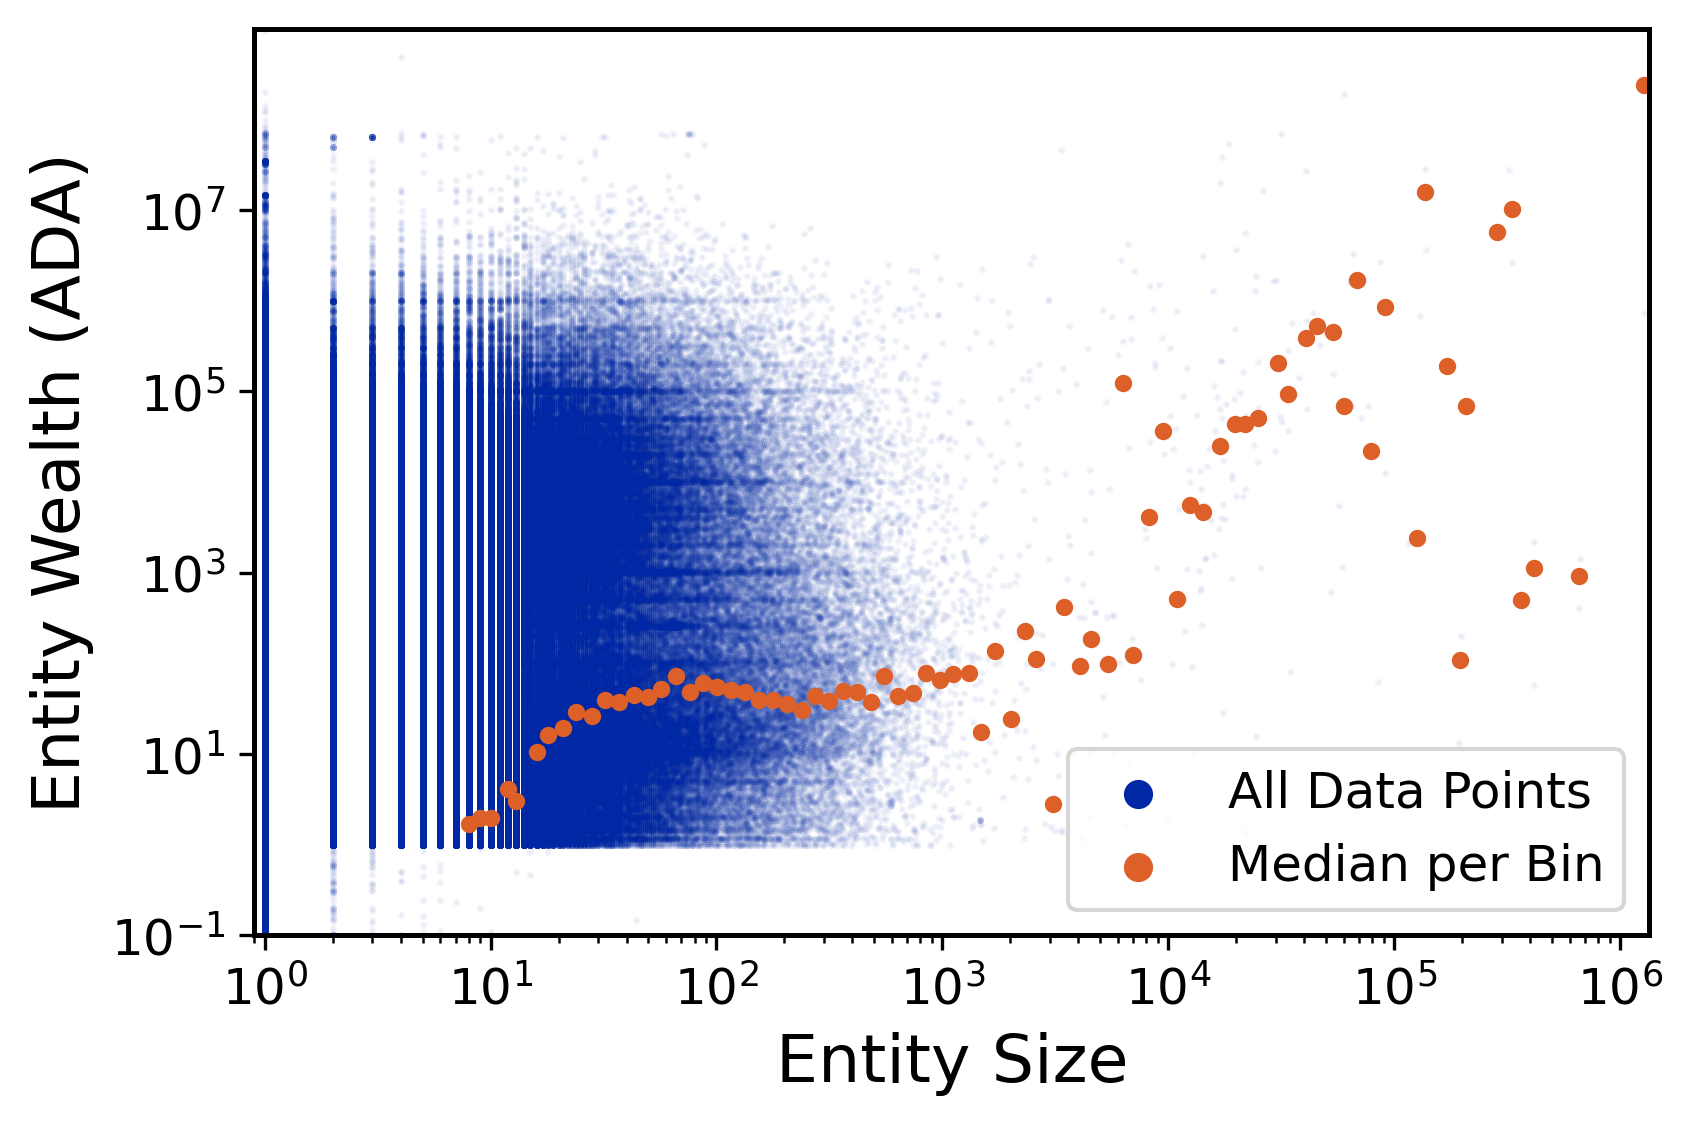

In [ ]:
# PLOT: "Entity Wealth (ADA)" vs. "Entity Size":

import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')

x = entity_size_array_heur1and2

file_name = BASE_ADDRESS + '/YuZhang_Cardano_Balances_Entities/YuZhang__BalancesPerEntityDay_1945__Cardano_TXs_All.txt'
y = load_file_to_array(file_name)


#x4 = num_of_entities_per_epoch_cumulative__LATEST
#y4 = count_cumulative_rewarded_pools_per_epoch

x = np.array(x, dtype=np.float64)
y = np.array(y, dtype=np.float64)
y = y/(10**6)  # convert lovelace to ADA


#x4 = np.array(x4)
#y4 = np.array(y4)


# Replace zeros in y with a very small number
small_number = 1e-4
x[x == 0] = small_number
y[y == 0] = small_number


# Transforming data to log space
log_x = np.log10(x)
log_y = np.log10(y)

# Define bin edges in log space
bin_edges_x = np.logspace(np.min(log_x), np.max(log_x), 100)
#bin_edges_y = np.logspace(np.min(log_y), np.max(log_y), 100)

# Digitize/assign each point to a bin
bin_indices_x = np.digitize(log_x, bins=np.log10(bin_edges_x))
#bin_indices_y = np.digitize(log_y, bins=np.log10(bin_edges_y))


# Calculate mean/median in each bin
binned_data = []
for i in tqdm(range(1, len(bin_edges_x))):
    #for j in range(1, len(bin_edges_y)):
        # Find indices for each bin separately
        indices_x = np.where(bin_indices_x == i)
        #indices_y = np.where(bin_indices_y == j)
        
        # Find common indices
        #common_indices = np.intersect1d(indices_x, indices_y)

        if len(indices_x) > 0:
            median_x = np.median(x[indices_x])
            median_y = np.median(y[indices_x])
            binned_data.append((median_x, median_y))



# Extract binned data for plotting
binned_x, binned_y = zip(*binned_data)



# Create a figure and axis
fig, ax = plt.subplots()


# Create a scatter plot
scatter_plot1 = plt.scatter(x, y,               label='Scatter Plot', marker='o', s=0.5, alpha=0.05)
scatter_plot2 = plt.scatter(binned_x, binned_y, label='Scatter Plot', marker='o', s=10,   alpha=1)

#plt.legend(['All Data Points', 'Median per Bin'], handles=[legend_scatter], fontsize=8, loc ="lower right")
legend_scatter1 = plt.scatter([], [], alpha=1, color=scatter_plot1.get_facecolor()[0], label='All Data Points')
legend_scatter2 = plt.scatter([], [], alpha=1, color=scatter_plot2.get_facecolor()[0], label='Median per Bin')
plt.legend(handles=[legend_scatter1, legend_scatter2], loc ="lower right")
legend_scatter1.remove()
legend_scatter2.remove()



plt.xlabel('Entity Size')
plt.ylabel('Entity Wealth (ADA)')

plt.xlim(left=0.9)   #, right=int(10 * 10**9))
plt.ylim(bottom=0.1) #, top=int(10 * 10**9))

plt.xscale('log')
plt.yscale('log')


# Show the plot
plt.savefig('fig_EntityWealth_vs_EntitySize.png', bbox_inches='tight', facecolor='white')
plt.show()



start time (Load /local/scratch/exported/Cardano_MCH_2023_1//YuZhang_Cardano_StakeDelegation_Entities/StakeDelegPerEntityEpoch_0390__Cardano_TXs_All.txt to Array):  2023-12-14 20:27:40.673508
elapsed time (Load /local/scratch/exported/Cardano_MCH_2023_1//YuZhang_Cardano_StakeDelegation_Entities/StakeDelegPerEntityEpoch_0390__Cardano_TXs_All.txt to Array):  0:00:00.626182


  1%|          | 1/99 [00:00<01:03,  1.55it/s]/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 99/99 [00:01<00:00, 70.81it/s] 


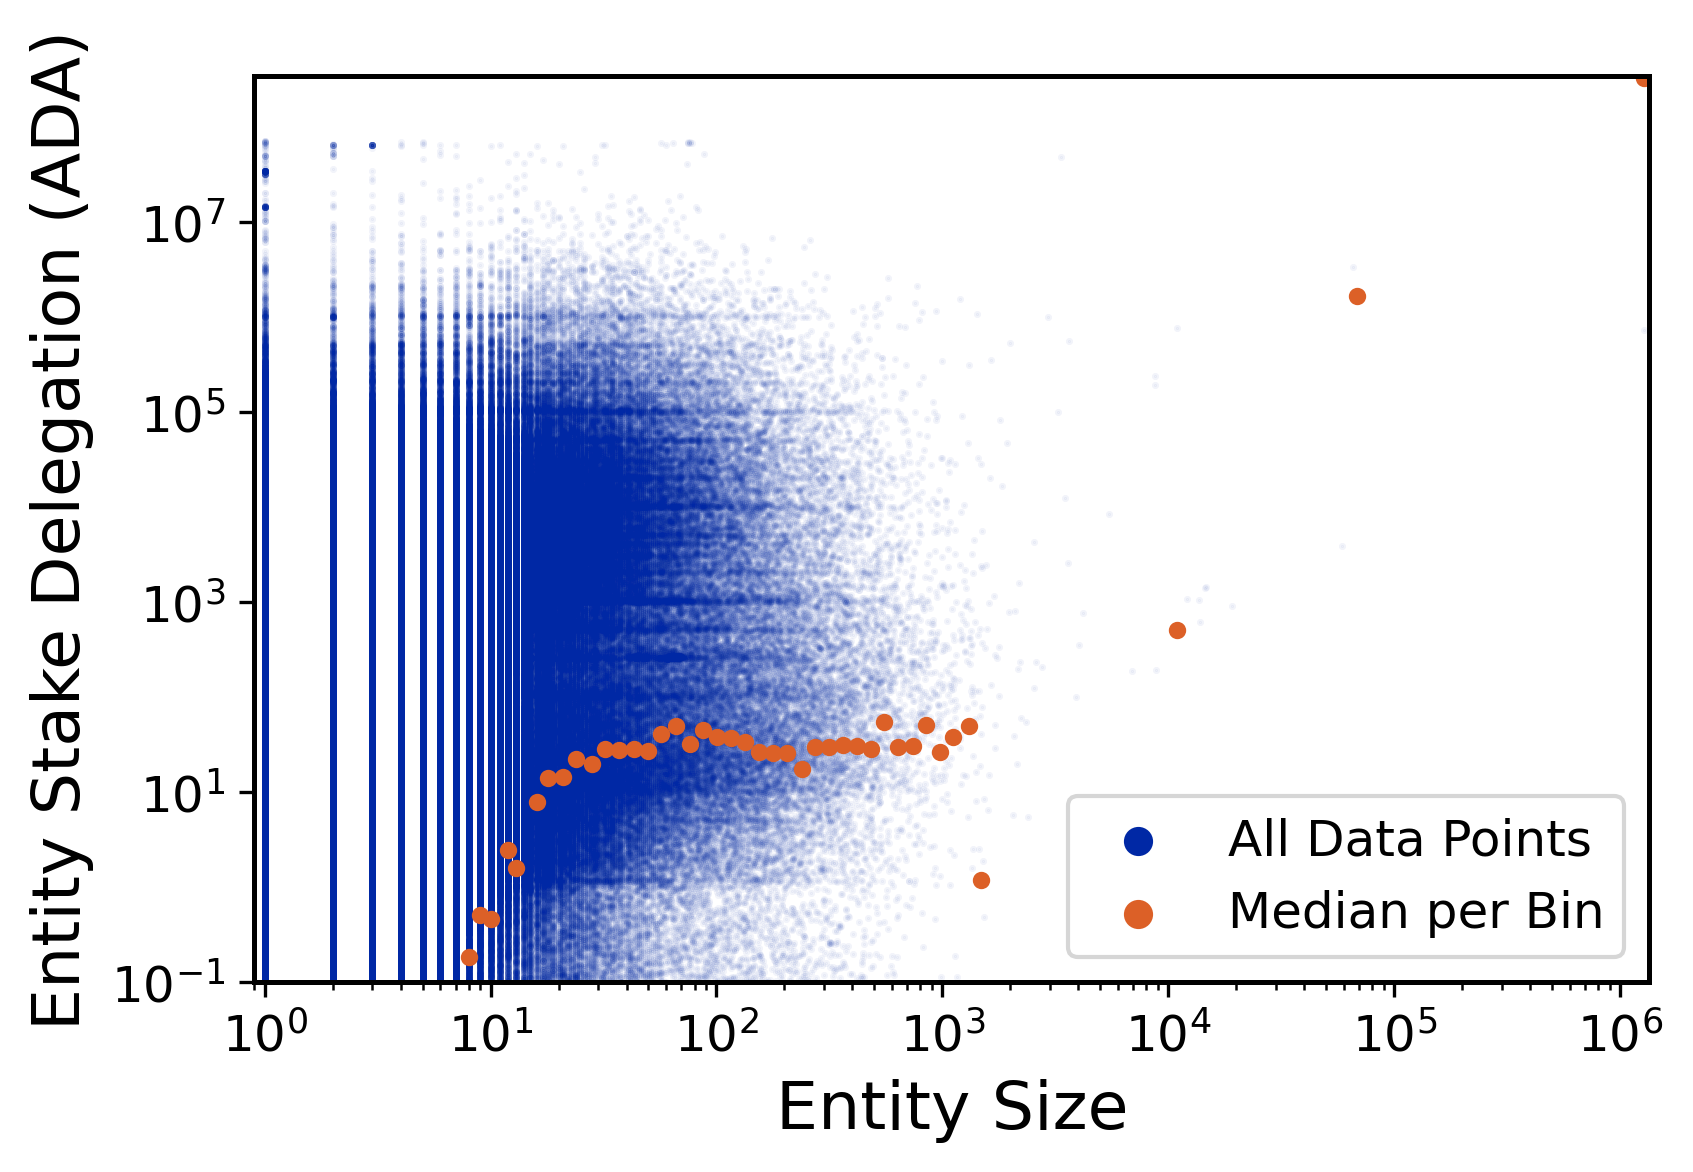

In [ ]:
# PLOT: "Entity Stake Delegation (ADA)" vs. "Entity Size":


import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')


x = entity_size_array_heur1and2

file_name = BASE_ADDRESS + '/YuZhang_Cardano_StakeDelegation_Entities/StakeDelegPerEntityEpoch_0390__Cardano_TXs_All.txt'
y = load_file_to_array(file_name)


#x4 = num_of_entities_per_epoch_cumulative__LATEST
#y4 = count_cumulative_rewarded_pools_per_epoch



x = np.array(x, dtype=np.float64)
y = np.array(y, dtype=np.float64)
y = y/(10**6) # convert lovelace to ADA

#x4 = np.array(x4)
#y4 = np.array(y4)



# Replace zeros in y with a very small number
small_number = 1e-6
x[x == 0] = small_number
y[y == 0] = small_number


# Transforming data to log space
log_x = np.log10(x)
log_y = np.log10(y)

# Define bin edges in log space
bin_edges_x = np.logspace(np.min(log_x), np.max(log_x), 100)
#bin_edges_y = np.logspace(np.min(log_y), np.max(log_y), 100)

# Digitize/assign each point to a bin
bin_indices_x = np.digitize(log_x, bins=np.log10(bin_edges_x))
#bin_indices_y = np.digitize(log_y, bins=np.log10(bin_edges_y))


# Calculate mean/median in each bin
binned_data = []
for i in tqdm(range(1, len(bin_edges_x))):
    #for j in range(1, len(bin_edges_y)):
        # Find indices for each bin separately
        indices_x = np.where(bin_indices_x == i)
        #indices_y = np.where(bin_indices_y == j)
        
        # Find common indices
        #common_indices = np.intersect1d(indices_x, indices_y)

        if len(indices_x) > 0:
            median_x = np.median(x[indices_x])
            median_y = np.median(y[indices_x])
            binned_data.append((median_x, median_y))



# Extract binned data for plotting
binned_x, binned_y = zip(*binned_data)



# Create a figure and axis
fig, ax = plt.subplots()


# Create a scatter plot
scatter_plot1 = plt.scatter(x, y,               label='Scatter Plot', marker='o', s=0.5, alpha=0.05)
scatter_plot2 = plt.scatter(binned_x, binned_y, label='Scatter Plot', marker='o', s=10, alpha=1)


#plt.legend(['All Data Points', 'Median per Bin'], handles=[legend_scatter], fontsize=8, loc ="lower right")
legend_scatter1 = plt.scatter([], [], alpha=1, color=scatter_plot1.get_facecolor()[0], label='All Data Points')
legend_scatter2 = plt.scatter([], [], alpha=1, color=scatter_plot2.get_facecolor()[0], label='Median per Bin')
plt.legend(handles=[legend_scatter1, legend_scatter2], loc ="lower right")
legend_scatter1.remove()
legend_scatter2.remove()


plt.xlabel('Entity Size')
plt.ylabel('Entity Stake Delegation (ADA)')

plt.xlim(left=0.9)   #, int(10 * 10**6))
plt.ylim(bottom=0.1) #, int(10 * 10**6))

plt.xscale('log')
plt.yscale('log')


# Show the plot
plt.savefig('fig_EntityStakeDelegation_vs_EntitySize.png', bbox_inches='tight', facecolor='white')
plt.show()



start time (Load /local/scratch/exported/Cardano_MCH_2023_1//YuZhang_Cardano_Balances_Entities/YuZhang__BalancesPerEntityDay_1945__Cardano_TXs_All.txt to Array):  2024-01-25 12:41:26.085685
elapsed time (Load /local/scratch/exported/Cardano_MCH_2023_1//YuZhang_Cardano_Balances_Entities/YuZhang__BalancesPerEntityDay_1945__Cardano_TXs_All.txt to Array):  0:00:00.484332
start time (Load /local/scratch/exported/Cardano_MCH_2023_1//YuZhang_Cardano_StakeDelegation_Entities/StakeDelegPerEntityEpoch_0391__Cardano_TXs_All.txt to Array):  2024-01-25 12:41:26.570737
elapsed time (Load /local/scratch/exported/Cardano_MCH_2023_1//YuZhang_Cardano_StakeDelegation_Entities/StakeDelegPerEntityEpoch_0391__Cardano_TXs_All.txt to Array):  0:00:00.379958


 91%|█████████ | 90/99 [00:03<00:00, 26.19it/s]/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 99/99 [00:04<00:00, 24.25it/s]


slope =  1.007072938537078
intercept =  -0.03888188055624209
r_value =  0.999975131913416
p_value =  1.7698576619414827e-98
std_err =  0.0010587634795058937


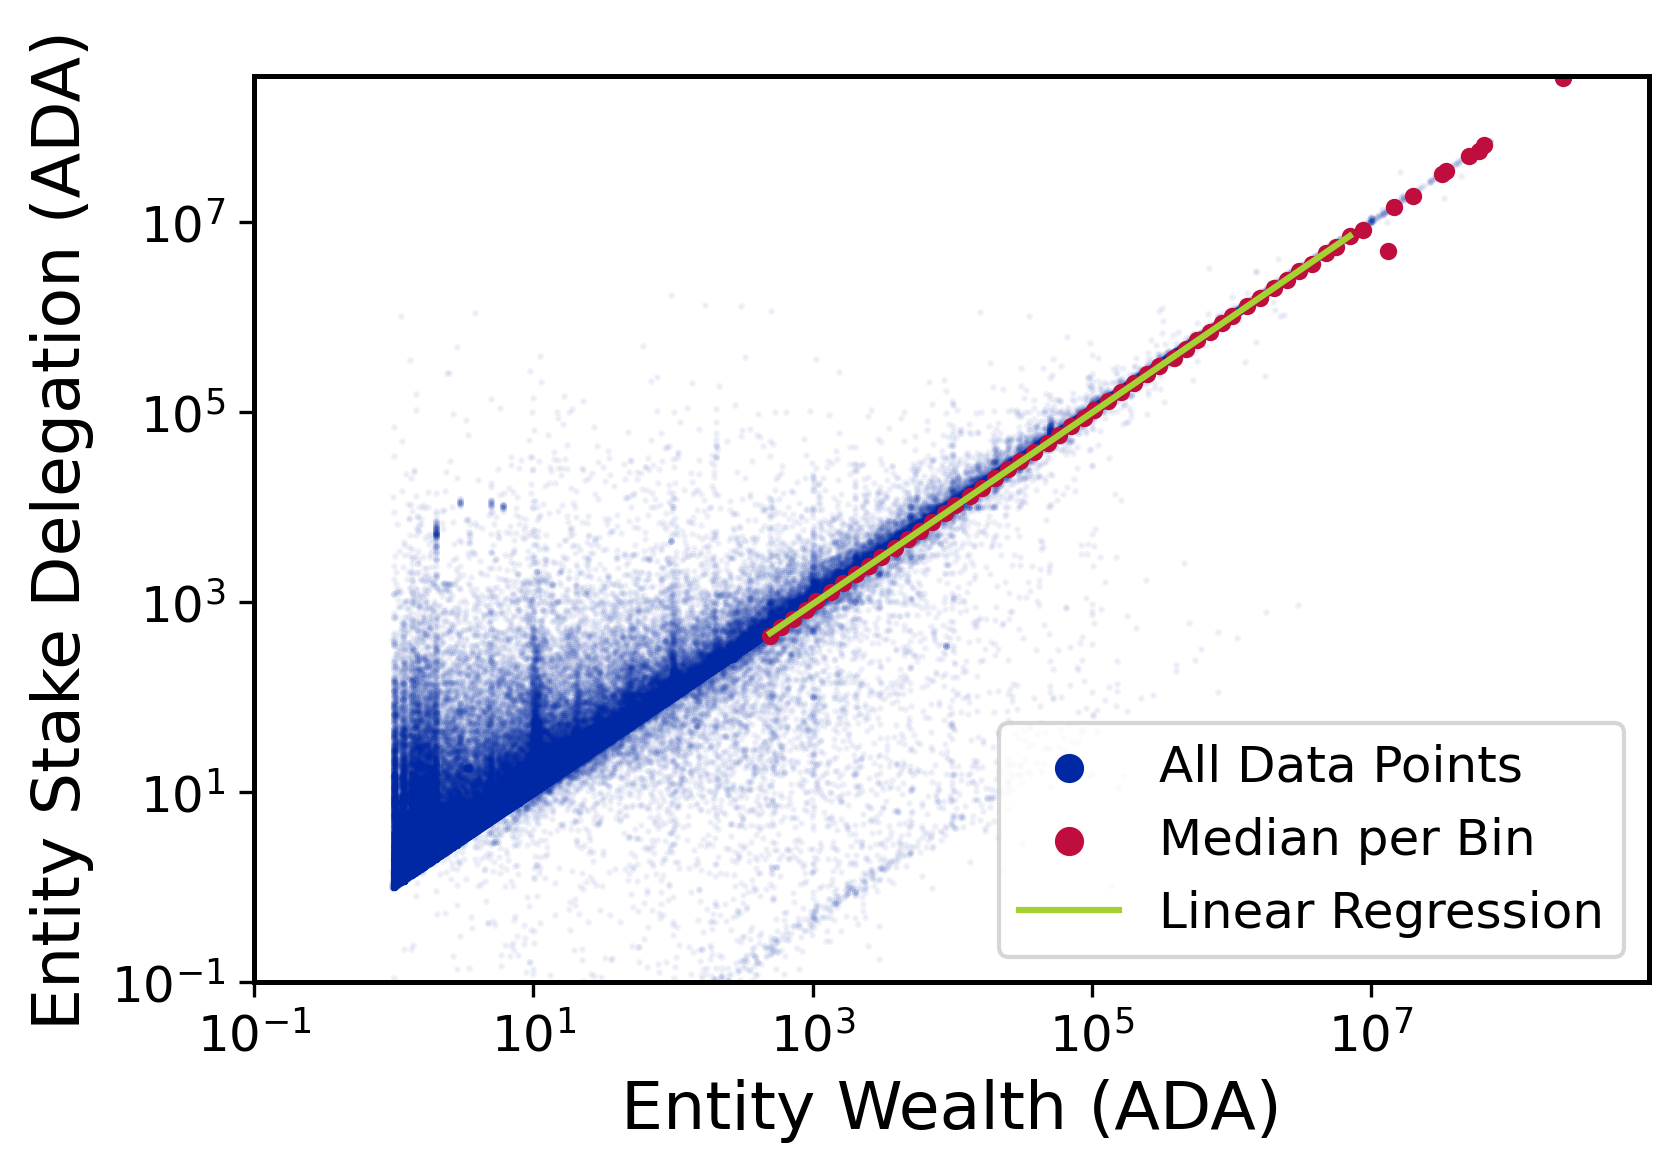

In [ ]:
# PLOT: "Entity Stake Delegation (ADA)" vs. "Entity Wealth (ADA)" [Heur 1 and 2]:


import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')

file_name = BASE_ADDRESS + '/YuZhang_Cardano_Balances_Entities/YuZhang__BalancesPerEntityDay_1945__Cardano_TXs_All.txt'
x = load_file_to_array(file_name)


file_name = BASE_ADDRESS + '/YuZhang_Cardano_StakeDelegation_Entities/StakeDelegPerEntityEpoch_0391__Cardano_TXs_All.txt'
y = load_file_to_array(file_name)


#x4 = num_of_entities_per_epoch_cumulative__LATEST
#y4 = count_cumulative_rewarded_pools_per_epoch



x = np.array(x, dtype=np.float64)
x = x/(10**6)  # convert lovelace to ADA
y = np.array(y, dtype=np.float64)
y = y/(10**6) # convert lovelace to ADA

#x4 = np.array(x4)
#y4 = np.array(y4)



# Replace zeros in y with a very small number
small_number = 1e-6
x[x == 0] = small_number
y[y == 0] = small_number


# Transforming data to log space
log_x = np.log10(x)
log_y = np.log10(y)

# Define bin edges in log space
bin_edges_x = np.logspace(0.01, np.max(log_x), 100)
#bin_edges_y = np.logspace(np.min(log_y), np.max(log_y), 100)

# Digitize/assign each point to a bin
bin_indices_x = np.digitize(log_x, bins=np.log10(bin_edges_x))
#bin_indices_y = np.digitize(log_y, bins=np.log10(bin_edges_y))


# Calculate mean/median in each bin
binned_data = []
for i in tqdm(range(1, len(bin_edges_x))):
    #for j in range(1, len(bin_edges_y)):
        # Find indices for each bin separately
        indices_x = np.where(bin_indices_x == i)
        #indices_y = np.where(bin_indices_y == j)
        
        # Find common indices
        #common_indices = np.intersect1d(indices_x, indices_y)

        if len(indices_x) > 0:
            median_x = np.median(x[indices_x])
            median_y = np.median(y[indices_x])
            binned_data.append((median_x, median_y))



# Extract binned data for plotting
binned_x, binned_y = zip(*binned_data)




# Perform linear regression
log_reg_x = np.log10(binned_x[29:76])
log_reg_y = np.log10(binned_y[29:76])
slope, intercept, r_value, p_value, std_err = linregress(log_reg_x, log_reg_y)
print('slope = ',     slope)
print('intercept = ', intercept)
print('r_value = ',   r_value)
print('p_value = ',   p_value)
print('std_err = ',   std_err)




# Create a figure and axis
fig, ax = plt.subplots()


# Create a scatter plot
scatter_plot1  = plt.scatter(x, y,               label='Scatter Plot', marker='o', s=0.5, alpha=0.05)
scatter_plot2  = plt.scatter(binned_x, binned_y, label='Scatter Plot', marker='o', s=10,  alpha=1)
plt.plot([], [])
plt.plot([], [])
plot3,         = plt.plot(10**log_reg_x, (10**intercept) * ((10**log_reg_x)**slope), label='Fitted Line')


legend_scatter1 = plt.scatter([], [], alpha=1, color=scatter_plot1.get_facecolor()[0], label='All Data Points')
legend_scatter2 = plt.scatter([], [], alpha=1, color=scatter_plot2.get_facecolor()[0], label='Median per Bin')
legend_plot3    = plt.Line2D([], [], color=plot3.get_color(), label='Linear Regression')
plt.legend(handles=[legend_scatter1, legend_scatter2, legend_plot3], loc ="lower right")
legend_scatter1.remove()
legend_scatter2.remove()





plt.xlabel('Entity Wealth (ADA)')
plt.ylabel('Entity Stake Delegation (ADA)')

plt.xlim(left=0.1)   #, int(10 * 10**6))
plt.ylim(bottom=0.1) #, int(10 * 10**6))

plt.xscale('log')
plt.yscale('log')


# Show the plot
plt.savefig('fig_EntityWealth_vs_EntityStakeDelegation.png', bbox_inches='tight', facecolor='white')
plt.show()



In [ ]:
# Find Number of New "Entities" Over Time:


print('----------------------')

# ct stores current time
ct = datetime.datetime.now()
print("current time: ", ct)
print('----------------------')


INITIAL_DATE_CARDANO      = datetime.datetime.strptime('2017-09-23 21:44:51', '%Y-%m-%d %H:%M:%S').date()
FINAL_DATE_CARDANO        = datetime.datetime.strptime('2023-01-21 17:39:30', '%Y-%m-%d %H:%M:%S').date()
total_time_length_CARDANO = int((FINAL_DATE_CARDANO - INITIAL_DATE_CARDANO).total_seconds()/86400) + 1


current_delta_day = 0


place_holder = 999999999999
entities_new_per_day_array = np.array([place_holder] * (max(clustering_array_heur1and2)[0]+1))



CSV_FILES_NAME_FORMAT = BASE_ADDRESS + '/cardano_TXs_'
NUMBER_OF_CSV_FILES = 6
CSV_FILES_SUFFIX = '.csv'


for i in range(1, NUMBER_OF_CSV_FILES + 1):

    ct_temp = datetime.datetime.now()

    file_name = CSV_FILES_NAME_FORMAT + str(i) + CSV_FILES_SUFFIX
    df = pd.read_csv(file_name, delimiter='|')

    et_temp = datetime.datetime.now() - ct_temp
    print("elapsed time (Load CSV File " + file_name + "): ", et_temp)

    ct_temp = datetime.datetime.now()

    for index, row in tqdm(df.iterrows()):
        ##########################################################################################
        TX_ID      = df.loc[index , 'TX_ID']

        ##########################################################################################
        BLOCK_TIME = datetime.datetime.strptime(str(df.loc[index , 'BLOCK_TIME']), '%Y-%m-%d %H:%M:%S').date()
        tx_delta_day = int((BLOCK_TIME - INITIAL_DATE_CARDANO).total_seconds()/86400)
        if(tx_delta_day != current_delta_day):
            current_delta_day = tx_delta_day

        ##########################################################################################
        EPOCH_NO   = str( df.loc[index , 'EPOCH_NO'] )

        ##########################################################################################
        outputs_list = list( df.loc[index , 'OUTPUTs'].split(';') )
        for tx_output in outputs_list:
            address_raw        = tx_output.split(',')[1]
            address_has_script = tx_output.split(',')[4]
            payment_cred       = tx_output.split(',')[5]
            stake_address      = tx_output.split(',')[6]
            if(address_has_script == 'f'):  # non-Smart Contract Address 
                [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
                if (address_payment_part != ''): 
                    addr_indx   = BinarySearch(unique_payment_addresses, address_payment_part)
                    entity_indx = clustering_array_heur1and2[addr_indx][0]
                    if(entities_new_per_day_array[entity_indx] == place_holder):
                        entities_new_per_day_array[entity_indx] = current_delta_day

        ##########################################################################################

        ##########################################################################################

        ##########################################################################################

    et_temp = datetime.datetime.now() - ct_temp
    print("elapsed time (New Entities over Time from CSV File " + file_name + "): ", et_temp)



print('----------------------')
et = datetime.datetime.now() - ct
print("Total elapsed time (New Entities over Time): ", et)


print('----------------------')
print('done!')




In [ ]:
# Load/Store "entities_new_per_day_array" from/into file:


print('----------------------')
ct = datetime.datetime.now()
curr_timestamp = str(ct)[0:10] + '_' + str(ct)[11:13] + str(ct)[14:16] + str(ct)[17:19]
      

# Store "entities_new_per_day_array" into file:
'''
output_filename = BASE_ADDRESS + '/newPerDay_Entities__Cardano_TXs_All__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)
store_array_to_file(entities_new_per_day_array, output_filename)
'''


# Load  "entities_new_per_day_array" from file:

file_name = BASE_ADDRESS + '/newPerDay_Entities__Cardano_TXs_All__2023-04-22_012525.txt'
entities_new_per_day_array = load_file_to_array(file_name)


##########################################################################################
print('----------------------')
print('done!')


In [ ]:
# PLOT: number of new entities per day:


import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')

date_list = [str(INITIAL_DATE_CARDANO + datetime.timedelta(days=i)) for i in range(total_time_length_CARDANO)]
date_list = pd.to_datetime(date_list)


DF = pd.DataFrame()
DF['Payment Addresses'] = num_of_raw_addresses_per_day        #label='Payment Addresses'
DF['Entities'] = num_of_entities_per_day        #label='Entities'
DF = DF.set_index(date_list)
plt.plot(DF)
plt.gcf().autofmt_xdate()

# Function add a legend  
plt.legend(['Payment Addresses', 'Entities'], loc ="lower right")

plt.xlabel('Date')
plt.ylabel('New Addresses/Entities')

# linear", "log", "symlog", "logit
#plt.xscale("linear")
plt.yscale("log")

#plt.xlim(0, 60)
#plt.ylim(0, 60)

plt.savefig('fig_new_entities_per_day.pdf', bbox_inches='tight', facecolor='white')
plt.show()


In [ ]:
# Find Number of new "Byron", "Shelley", and "Stake" addresses VS "Time":


print('----------------------')

# ct stores current time
ct = datetime.datetime.now()
print("current time: ", ct)
print('----------------------')


INITIAL_DATE_CARDANO      = datetime.datetime.strptime('2017-09-23 21:44:51', '%Y-%m-%d %H:%M:%S').date()
FINAL_DATE_CARDANO        = datetime.datetime.strptime('2023-01-21 17:39:30', '%Y-%m-%d %H:%M:%S').date()
total_time_length_CARDANO = int((FINAL_DATE_CARDANO - INITIAL_DATE_CARDANO).total_seconds()/86400) + 1


current_delta_day = 0
#active_addresses  = []
#active_entities   = []


place_holder = 999999999999
raw_addresses_new_per_day_array             = np.array([place_holder] * len(unique_raw_addresses))
Byron_payment_addresses_new_per_day_array   = np.array([place_holder] * len(unique_payment_addresses))
Shelley_payment_addresses_new_per_day_array = np.array([place_holder] * len(unique_payment_addresses))
delegation_addresses_new_per_day_array      = np.array([place_holder] * len(unique_delegation_addresses))

#active_addresses_per_day_array = [0]*total_time_length_CARDANO
#active_entities_per_day_array  = [0]*total_time_length_CARDANO


CSV_FILES_NAME_FORMAT = BASE_ADDRESS + '/cardano_TXs_'
NUMBER_OF_CSV_FILES = 6
CSV_FILES_SUFFIX = '.csv'


for i in range(1, NUMBER_OF_CSV_FILES + 1):

    ct_temp = datetime.datetime.now()

    file_name = CSV_FILES_NAME_FORMAT + str(i) + CSV_FILES_SUFFIX
    df = pd.read_csv(file_name, delimiter='|')

    et_temp = datetime.datetime.now() - ct_temp
    print("elapsed time (Load CSV File " + file_name + "): ", et_temp)

    ct_temp = datetime.datetime.now()

    for index, row in tqdm(df.iterrows()):
        ##########################################################################################
        TX_ID      = df.loc[index , 'TX_ID']

        ##########################################################################################
        BLOCK_TIME = datetime.datetime.strptime(str(df.loc[index , 'BLOCK_TIME']), '%Y-%m-%d %H:%M:%S').date()
        tx_delta_day = int((BLOCK_TIME - INITIAL_DATE_CARDANO).total_seconds()/86400)
        if(tx_delta_day != current_delta_day):
            current_delta_day = tx_delta_day

        ##########################################################################################
        EPOCH_NO   = str( df.loc[index , 'EPOCH_NO'] )

        ##########################################################################################
        outputs_list = list( df.loc[index , 'OUTPUTs'].split(';') )
        for tx_output in outputs_list:
            address_raw        = tx_output.split(',')[1]
            address_has_script = tx_output.split(',')[4]
            payment_cred       = tx_output.split(',')[5]
            stake_address      = tx_output.split(',')[6]

            [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)

            if (address_raw != ''): 
                addr_position = BinarySearch(unique_raw_addresses, address_raw)
                if(raw_addresses_new_per_day_array[addr_position] == place_holder):
                    raw_addresses_new_per_day_array[addr_position] = current_delta_day

            if (address_payment_part != ''): 
                if (address_raw[2] == '8'): #Byron Address
                    addr_position = BinarySearch(unique_payment_addresses, address_payment_part)
                    if(Byron_payment_addresses_new_per_day_array[addr_position] == place_holder):
                        Byron_payment_addresses_new_per_day_array[addr_position] = current_delta_day
                else: #Shelley Address
                    addr_position = BinarySearch(unique_payment_addresses, address_payment_part)
                    if(Shelley_payment_addresses_new_per_day_array[addr_position] == place_holder):
                        Shelley_payment_addresses_new_per_day_array[addr_position] = current_delta_day

            if(address_delegation_part != ''):
                addr_position = BinarySearch(unique_delegation_addresses, address_delegation_part)
                if(delegation_addresses_new_per_day_array[addr_position] == place_holder):
                    delegation_addresses_new_per_day_array[addr_position] = current_delta_day

        ##########################################################################################





In [ ]:
# Load/Store Address Data per Day:


# Load/Store "raw_addresses_new_per_day_array"                from/into file:
#            "Byron_payment_addresses_new_per_day_array", 
#            "Shelley_payment_addresses_new_per_day_array", 
#            "delegation_addresses_new_per_day_array"


print('----------------------')
      

# Store "raw_addresses_new_per_day_array",              into file:
#       "Byron_payment_addresses_new_per_day_array", 
#       "Shelley_payment_addresses_new_per_day_array", 
#       "delegation_addresses_new_per_day_array"
ct = datetime.datetime.now()
curr_timestamp = str(ct)[0:10] + '_' + str(ct)[11:13] + str(ct)[14:16] + str(ct)[17:19]

output_filename = BASE_ADDRESS + '/newPerDay_rawAddresses__Cardano_TXs_All__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)
store_array_to_file(raw_addresses_new_per_day_array, output_filename)

output_filename = BASE_ADDRESS + '/newPerDay_ByronAddresses__Cardano_TXs_All__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)
store_array_to_file(Byron_payment_addresses_new_per_day_array, output_filename)

output_filename = BASE_ADDRESS + '/newPerDay_ShelleyAddresses__Cardano_TXs_All__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)
store_array_to_file(Shelley_payment_addresses_new_per_day_array, output_filename)

output_filename = BASE_ADDRESS + '/newPerDay_delegationAddresses__Cardano_TXs_All__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)
store_array_to_file(delegation_addresses_new_per_day_array, output_filename)



# Load  "raw_addresses_new_per_day_array",              from file:
#       "Byron_payment_addresses_new_per_day_array", 
#       "Shelley_payment_addresses_new_per_day_array", 
#       "delegation_addresses_new_per_day_array"

file_name = BASE_ADDRESS + '/newPerDay_rawAddresses__Cardano_TXs_All__2023-04-20_025121.txt'
raw_addresses_new_per_day_array             = load_file_to_array(file_name)

file_name = BASE_ADDRESS + '/newPerDay_ByronAddresses__Cardano_TXs_All__2023-04-20_025121.txt'
Byron_payment_addresses_new_per_day_array   = load_file_to_array(file_name)

file_name = BASE_ADDRESS + '/newPerDay_ShelleyAddresses__Cardano_TXs_All__2023-04-20_025121.txt'
Shelley_payment_addresses_new_per_day_array = load_file_to_array(file_name)

file_name = BASE_ADDRESS + '/newPerDay_delegationAddresses__Cardano_TXs_All__2023-04-20_025121.txt'
delegation_addresses_new_per_day_array      = load_file_to_array(file_name)


##########################################################################################
print('----------------------')
print('done!')


In [ ]:
# Find Number of "New Addresses" Per Day:



# Load  "raw_addresses_new_per_day_array",              from file:
#       "Byron_payment_addresses_new_per_day_array", 
#       "Shelley_payment_addresses_new_per_day_array", 
#       "delegation_addresses_new_per_day_array"


print('----------------------')
ct = datetime.datetime.now()
print("start time: ", ct)


print('----------------------')
ct_temp = datetime.datetime.now()

place_holder = 999999999999

raw_addresses_new_per_day_array             = [value for value in raw_addresses_new_per_day_array             if value != place_holder]
Byron_payment_addresses_new_per_day_array   = [value for value in Byron_payment_addresses_new_per_day_array   if value != place_holder]
Shelley_payment_addresses_new_per_day_array = [value for value in Shelley_payment_addresses_new_per_day_array if value != place_holder]
delegation_addresses_new_per_day_array      = [value for value in delegation_addresses_new_per_day_array      if value != place_holder]
print('days equal to place_holder were removed !')
et = datetime.datetime.now() - ct_temp
print("elapsed time: ", et)

print('----------------------')
ct_temp = datetime.datetime.now()
sorted_raw_addresses_new_per_day_array             = np.sort(raw_addresses_new_per_day_array,             axis=None)
sorted_Byron_payment_addresses_new_per_day_array   = np.sort(Byron_payment_addresses_new_per_day_array,   axis=None)
sorted_Shelley_payment_addresses_new_per_day_array = np.sort(Shelley_payment_addresses_new_per_day_array, axis=None)
sorted_delegation_addresses_new_per_day_array      = np.sort(delegation_addresses_new_per_day_array,      axis=None)
print('addresses_new_per_day_arrays were sorted !')
et = datetime.datetime.now() - ct_temp
print("elapsed time: ", et)


print('----------------------')
ct_temp = datetime.datetime.now()
num_of_days_raw        = max(sorted_raw_addresses_new_per_day_array)             + 1
num_of_days_byron      = max(sorted_Byron_payment_addresses_new_per_day_array)   + 1
num_of_days_shelley    = max(sorted_Shelley_payment_addresses_new_per_day_array) + 1
num_of_days_delegation = max(sorted_delegation_addresses_new_per_day_array)      + 1
print('num_of_days_raw        = ', num_of_days_raw)
print('num_of_days_byron      = ', num_of_days_byron)
print('num_of_days_shelley    = ', num_of_days_shelley)
print('num_of_days_delegation = ', num_of_days_delegation)
print(' ')

MAX_num_of_days = max(num_of_days_raw, num_of_days_byron, num_of_days_shelley, num_of_days_delegation)
print('max(num_of_days) = ', MAX_num_of_days)
et = datetime.datetime.now() - ct_temp
print("elapsed time: ", et)


print('----------------------')
ct_temp = datetime.datetime.now()

num_of_raw_addresses_per_day = np.array([0] * MAX_num_of_days)
for i in tqdm(range(MAX_num_of_days)):
    x = BinarySearch_Find_start_end(sorted_raw_addresses_new_per_day_array, i)
    if(x != -1):
        num_of_raw_addresses_per_day[i] = x[1] - x[0] + 1

num_of_Byron_addresses_per_day = np.array([0] * MAX_num_of_days)
for i in tqdm(range(MAX_num_of_days)):
    x = BinarySearch_Find_start_end(sorted_Byron_payment_addresses_new_per_day_array, i)
    if(x != -1):
        num_of_Byron_addresses_per_day[i] = x[1] - x[0] + 1

num_of_Shelley_addresses_per_day = np.array([0] * MAX_num_of_days)
for i in tqdm(range(MAX_num_of_days)):
    x = BinarySearch_Find_start_end(sorted_Shelley_payment_addresses_new_per_day_array, i)
    if(x != -1):
        num_of_Shelley_addresses_per_day[i] = x[1] - x[0] + 1

num_of_delegation_addresses_per_day = np.array([0] * MAX_num_of_days)
for i in tqdm(range(MAX_num_of_days)):
    x = BinarySearch_Find_start_end(sorted_delegation_addresses_new_per_day_array, i)
    if(x != -1):
        num_of_delegation_addresses_per_day[i] = x[1] - x[0] + 1

et = datetime.datetime.now() - ct_temp
print("elapsed time: ", et)


print('----------------------')
et = datetime.datetime.now() - ct
print("Total elapsed time: ", et)


##########################################################################################

print('----------------------')
print('done!')


In [ ]:
# PLOT: number of new addresses per day:


import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')

date_list = [str(INITIAL_DATE_CARDANO + datetime.timedelta(days=i)) for i in range(total_time_length_CARDANO)]
date_list = pd.to_datetime(date_list)


DF = pd.DataFrame()
#DF['Payment Addresses'] = num_of_raw_addresses_per_day        #label='Payment Addresses'
DF['Shelley Addresses'] = num_of_Shelley_addresses_per_day    #label='Shelley Addresses'
DF['Byron Addresses']   = num_of_Byron_addresses_per_day      #label='Byron Addresses'
DF['Stake Addresses']   = num_of_delegation_addresses_per_day #label='Stake Addresses'
#DF['value'] = active_entities_per_day_array
DF = DF.set_index(date_list)
#plt.plot(y=['value1', 'value2', 'value3', 'value4'])
plt.plot(DF)
plt.gcf().autofmt_xdate()

# Function add a legend  
#plt.legend(['Payment Addresses', 'Shelley Addresses', 'Byron Addresses', 'Stake Addresses'], loc ="lower right")
plt.legend(['Shelley Addresses', 'Byron Addresses', 'Stake Addresses'], loc ="lower right")

plt.xlabel('Date')
plt.ylabel('New Addresses')

# linear", "log", "symlog", "logit
#plt.xscale("linear")
plt.yscale("log")

#plt.xlim(0, 60)
#plt.ylim(0, 60)

#plt.savefig('fig_new_addresses_per_day.svg', dpi=200, bbox_inches='tight', facecolor='red')
plt.savefig('fig_new_addresses_per_day.pdf', bbox_inches='tight', facecolor='white')
plt.show()


In [ ]:
# Calculate Active Users and Entities Per Day:


print('----------------------')

# ct stores current time
ct = datetime.datetime.now()
print("current time: ", ct)
print('----------------------')


INITIAL_DATE_CARDANO      = datetime.datetime.strptime('2017-09-23 21:44:51', '%Y-%m-%d %H:%M:%S').date()
FINAL_DATE_CARDANO        = datetime.datetime.strptime('2023-01-21 17:39:30', '%Y-%m-%d %H:%M:%S').date()
total_time_length_CARDANO = int((FINAL_DATE_CARDANO - INITIAL_DATE_CARDANO).total_seconds()/86400) + 1

current_delta_day = 0
active_addresses  = []
active_entities   = []


active_addresses_per_day_array = [0]*total_time_length_CARDANO
active_entities_per_day_array  = [0]*total_time_length_CARDANO


CSV_FILES_NAME_FORMAT = BASE_ADDRESS + '/cardano_TXs_'
NUMBER_OF_CSV_FILES = 6
CSV_FILES_SUFFIX = '.csv'


for i in range(1, NUMBER_OF_CSV_FILES + 1):

    ct_temp = datetime.datetime.now()

    file_name = CSV_FILES_NAME_FORMAT + str(i) + CSV_FILES_SUFFIX
    df = pd.read_csv(file_name, delimiter='|')

    et_temp = datetime.datetime.now() - ct_temp
    print("elapsed time (Load CSV File " + file_name + "): ", et_temp)

    ct_temp = datetime.datetime.now()

    for index, row in tqdm(df.iterrows()):
        ##########################################################################################
        TX_ID      = df.loc[index , 'TX_ID']
        ##########################################################################################
        BLOCK_TIME = datetime.datetime.strptime(str(df.loc[index , 'BLOCK_TIME']), '%Y-%m-%d %H:%M:%S').date()
        tx_delta_day = int((BLOCK_TIME - INITIAL_DATE_CARDANO).total_seconds()/86400)
        if(tx_delta_day > current_delta_day):
            active_addresses_per_day_array[current_delta_day] = len(set(active_addresses))
            active_entities_per_day_array[current_delta_day]  = len(set(active_entities))
            current_delta_day = tx_delta_day
            active_addresses  = []
            active_entities   = []
        ##########################################################################################
        EPOCH_NO   = str( df.loc[index , 'EPOCH_NO'] )
        ##########################################################################################
        inputs_list = list( df.loc[index , 'INPUTs'].split(';') )
        for tx_input in inputs_list:
            address_raw           = tx_input.split(',')[4]
            address_has_script    = tx_input.split(',')[7]
            payment_cred          = tx_input.split(',')[8]
            stake_address         = tx_input.split(',')[9]
            if(address_has_script == 'f'):  # non-Smart Contract Address 
                [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
                if (address_payment_part != ''):
                    addr_indx   = BinarySearch(unique_payment_addresses, address_payment_part)
                    entity_indx = clustering_array[addr_indx][0]
                    active_addresses.append(addr_indx)
                    active_entities.append(entity_indx)





In [ ]:
# Store/Load Active Users and Entities Per Day:


# (Store/Load "active_addresses_per_day_array" and "active_entities_per_day_array" into/from file)


ct = datetime.datetime.now()
curr_timestamp = str(ct)[0:10] + '_' + str(ct)[11:13] + str(ct)[14:16] + str(ct)[17:19]



# Store "active_addresses_per_day_array" and "active_entities_per_day_array" to file:
output_filename = BASE_ADDRESS + '/activeAddressesPerDayList__Cardano_TXs_All__' + curr_timestamp + '.txt'
store_array_to_file (active_addresses_per_day_array, output_filename)


output_filename = BASE_ADDRESS + '/activeEntitiesPerDayList__Cardano_TXs_All__' + curr_timestamp + '.txt'
store_array_to_file (active_entities_per_day_array, output_filename)



# Load "active_addresses_per_day_array" and "active_entities_per_day_array" from File:
file_name = BASE_ADDRESS + '/activeAddressesPerDayList__Cardano_TXs_All__2023-04-09_224357.txt'
active_addresses_per_day_array = load_file_to_array(file_name)

file_name = BASE_ADDRESS + '/activeEntitiesPerDayList__Cardano_TXs_All__2023-04-09_224357.txt'
active_entities_per_day_array  = load_file_to_array(file_name)





In [ ]:
# PLOT: result of active addresses/entities:


import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')


date_list = [str(INITIAL_DATE_CARDANO + datetime.timedelta(days=i)) for i in range(total_time_length_CARDANO)]
date_list = pd.to_datetime(date_list)


DF = pd.DataFrame()
DF = pd.DataFrame(active_addresses_per_day_array, columns=['value1'])
DF['value2'] = pd.DataFrame(active_entities_per_day_array)

DF = DF.set_index(date_list)
plt.plot(DF)
plt.gcf().autofmt_xdate()

# Function add a legend 
plt.legend(['Active Addresses', 'Active Entities'], loc ="upper left")

plt.xlabel('Date')
plt.ylabel('Active Addresses/Entities')

# linear", "log", "symlog", "logit
#plt.xscale("linear")
plt.yscale("log")

#plt.xlim(0, 60)
#plt.ylim(0, 60)


plt.savefig('fig_active_addresses_and_entities_per_day.pdf', bbox_inches='tight', facecolor='white')
plt.show()




In [ ]:
# Calculate "Number of NFT/FT/ADA Entity-Level Transactions" Over Time:


print('----------------------')
def Find_ADA_NFT_FT_TXs_per_Entity_over_time(queue_):
    # read input queue arguments
    in_args = queue_.get()
    csv_file_name = in_args[0]

    csv_file_basename = os.path.basename(csv_file_name)
    
    ct = datetime.datetime.now()

    # Choose from: "clustering_array_heur1"  OR  "clustering_array_heur2"  OR  "clustering_array_heur1and2"
    clustering_array = clustering_array_heur1and2


    # Initialize final outputs:
    balances_per_entity_array = np.array([0] * ( np.amax(clustering_array)+1 ))
    entity_level_ADA_Transactions = []
    entity_level_NFT_Transactions = []
    entity_level_FT_Transactions  = []


    INITIAL_DATE_CARDANO      = datetime.datetime.strptime('2017-09-23 21:44:51', '%Y-%m-%d %H:%M:%S').date()
    FINAL_DATE_CARDANO        = datetime.datetime.strptime('2023-01-21 17:39:30', '%Y-%m-%d %H:%M:%S').date()
    total_time_length_CARDANO = int((FINAL_DATE_CARDANO - INITIAL_DATE_CARDANO).total_seconds()/86400) + 1


    ct_temp = datetime.datetime.now()

    file_name = csv_file_name
    df = pd.read_csv(file_name, delimiter='|')

    et_temp = datetime.datetime.now() - ct_temp
    print("elapsed time (Load CSV File " + file_name + "): ", et_temp)

    ct_temp = datetime.datetime.now()
    
    cnt = 0

    for index, row in tqdm(df.iterrows()):
        ##########################################################################################
        TX_ID      = df.loc[index , 'TX_ID']
        ##########################################################################################
        #BLOCK_TIME = str(datetime.datetime.strptime(str(df.loc[index , 'BLOCK_TIME']), '%Y-%m-%d %H:%M:%S').date())
        BLOCK_TIME   = datetime.datetime.strptime(str(df.loc[index , 'BLOCK_TIME']), '%Y-%m-%d %H:%M:%S').date()
        tx_delta_day = int((BLOCK_TIME - INITIAL_DATE_CARDANO).total_seconds()/86400)
        ##########################################################################################
        EPOCH_NO   = str(  df.loc[index , 'EPOCH_NO'] )
        ##########################################################################################
        inputs_list = list( df.loc[index , 'INPUTs'].split(';') )
        ##########################################################################################
        outputs_list = list( df.loc[index , 'OUTPUTs'].split(';') )
        ##########################################################################################
        # List of input entities:
        input_entity_indx = []
        for tx_input in inputs_list:
            address_raw           = tx_input.split(',')[4]
            address_has_script    = tx_input.split(',')[7]
            payment_cred          = tx_input.split(',')[8]
            stake_address         = tx_input.split(',')[9]
            if(address_has_script == 'f'):  # non-Smart Contract Address 
                [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
                if (address_payment_part != ''):
                    addr_indx = BinarySearch(unique_payment_addresses, address_payment_part)
                    input_entity_indx.append(clustering_array[addr_indx][0])
                    break;

        if(input_entity_indx == []):
            cnt = cnt + 1
            #if(cnt < 100): print("WARNING - All inputs of this TX are Script/Smart Contract: TX_ID = ", TX_ID)
            continue;


        # List of output ADA entities (Entities in the output_list that have received ADA):
        output_ADA_entities_indx = []
        for tx_output in outputs_list:
            address_raw           = tx_output.split(',')[1]
            address_has_script    = tx_output.split(',')[4]
            payment_cred          = tx_output.split(',')[5]
            stake_address         = tx_output.split(',')[6]
            if(address_has_script == 'f'):  # non-Smart Contract Address 
                [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
                if (address_payment_part != ''):
                    addr_indx   = BinarySearch(unique_payment_addresses, address_payment_part)
                    output_ADA_entities_indx.append(clustering_array[addr_indx][0])

        output_ADA_entities_indx = list(set(output_ADA_entities_indx))
        if input_entity_indx[0] in output_ADA_entities_indx: output_ADA_entities_indx.remove(input_entity_indx[0])


        ##########################################################################################
        ##########################################################################################
        # STRING_AGG(distinct concat(things."OUTPUT_ID",  ':', things."OUTPUT_MAs__NAME__POLICY__FINGERPRINT",                                                                                     ''    ), E';') as "TX_OUTPUT_MAs",
        # STRING_AGG(distinct concat(things."OUTPUT_MULTIASSET_TXOUT_IDENT", ',', things."OUTPUT_MULTIASSET_TXOUT_QUANTITY", ',', things."OUTPUT_NFT_NAME",       ',', things."OUTPUT_FT_NAME",    ',', 
        #                            things."OUTPUT_MA_NAME",                ',', things."OUTPUT_MA_POLICY",                 ',', things."OUTPUT_MA_FINGERPRINT",                                  ','   ), E':') AS "MAs__NAME__POLICY__FINGERPRINT"

        TX_OUTPUT_MAs_list = list( df.loc[index , 'TX_OUTPUT_MAs'].split(';') )

        # List of output NFT/FT entities (Entities in the output_list that have received NFT/FT):
        output_NFT_entities_indx = []
        output_FT_entities_indx  = []

        for OUTPUT_MAs in TX_OUTPUT_MAs_list:
            MAs_list = list( OUTPUT_MAs.split(':') )
            if(MAs_list[0] == ''):
                continue;
            OUTPUT_ID = int(MAs_list[0])
            MAs_list.pop(0)
            flag = 0
            for MA in MAs_list:
                MA_splited = MA.split(',')
                if(len(MA_splited) < 7):
                    continue;

                MA_ID          = MA_splited[0]
                quantity       = MA_splited[1] # quantity of multi asset stored in this UTXO
                NFT_name       = MA_splited[2]
                FT_name        = MA_splited[3]
                MA_name        = MA_splited[4]
                MA_policy      = MA_splited[5]
                MA_fingerprint = MA_splited[6]

                # Find address/entity of output:
                if(flag == 0):
                    flag = 1
                    entity_indx = []
                    for tx_output in outputs_list:
                        tx_output_ID = int(tx_output.split(',')[0])
                        if(tx_output_ID == OUTPUT_ID):
                            address_raw           = tx_output.split(',')[1]
                            address_has_script    = tx_output.split(',')[4]
                            payment_cred          = tx_output.split(',')[5]
                            stake_address         = tx_output.split(',')[6]
                            if(address_has_script == 'f'):  # non-Smart Contract Address 
                                [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
                                if (address_payment_part != ''):
                                    addr_indx   = BinarySearch(unique_payment_addresses, address_payment_part)
                                    entity_indx.append(clustering_array[addr_indx][0])

                if(NFT_name  != ''):
                    if(MA_ID != '' and entity_indx != []): output_NFT_entities_indx.append(entity_indx[0])
                elif(FT_name != ''):
                    if(MA_ID != '' and entity_indx != []): output_FT_entities_indx.append(entity_indx[0])



        output_NFT_entities_indx = list(set(output_NFT_entities_indx))
        if input_entity_indx[0] in output_NFT_entities_indx: output_NFT_entities_indx.remove(input_entity_indx[0])

        output_FT_entities_indx = list(set(output_FT_entities_indx))
        if input_entity_indx[0] in output_FT_entities_indx: output_FT_entities_indx.remove(input_entity_indx[0])

        #################################################################
        for out_ADA_entity in output_ADA_entities_indx:
            entity_level_ADA_Transactions.append((tx_delta_day,                                    # Day_delta
                                                  input_entity_indx[0],                            # entity_from
                                                  out_ADA_entity,                                  # entity_to
                                                  balances_per_entity_array[input_entity_indx[0]], # balance_entity_from
                                                  balances_per_entity_array[out_ADA_entity]        # balance_entity_to
                                                 ))

        for out_NFT_entity in output_NFT_entities_indx:
            entity_level_NFT_Transactions.append((tx_delta_day,                                    # Day_delta
                                                  input_entity_indx[0],                            # entity_from
                                                  out_NFT_entity,                                  # entity_to
                                                  balances_per_entity_array[input_entity_indx[0]], # balance_entity_from
                                                  balances_per_entity_array[out_NFT_entity]        # balance_entity_to
                                                 ))

        for out_FT_entity in output_FT_entities_indx:
            entity_level_FT_Transactions.append((tx_delta_day,                                    # Day_delta
                                                 input_entity_indx[0],                            # entity_from
                                                 out_FT_entity,                                   # entity_to
                                                 balances_per_entity_array[input_entity_indx[0]], # balance of entity_from
                                                 balances_per_entity_array[out_FT_entity]         # balance of entity_to
                                                 ))

        ##########################################################################################
        # Update all ADA balances:
        for i in range(0, len(inputs_list)):
            address_has_script = inputs_list[i].split(',')[7]
            if (address_has_script == 'f'): # non-Smart Contract Address
                address_raw   = inputs_list[i].split(',')[4]
                payment_cred  = inputs_list[i].split(',')[8]
                stake_address = inputs_list[i].split(',')[9]
                [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
                if (address_payment_part != ''):
                    addr_indx   = BinarySearch(unique_payment_addresses, address_payment_part)
                    entity_indx = clustering_array[addr_indx][0]
                    UTXO_value  = inputs_list[i].split(',')[6]
                    balances_per_entity_array[entity_indx] = balances_per_entity_array[entity_indx] - int(UTXO_value)

        for i in range(0, len(outputs_list)):
            address_has_script = outputs_list[i].split(',')[4]
            if (address_has_script == 'f'): # non-Smart Contract Address
                address_raw   = outputs_list[i].split(',')[1]
                payment_cred  = outputs_list[i].split(',')[5]
                stake_address = outputs_list[i].split(',')[6]
                [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
                if (address_payment_part != ''):
                    addr_indx   = BinarySearch(unique_payment_addresses, address_payment_part)
                    entity_indx = clustering_array[addr_indx][0]
                    UTXO_value  = outputs_list[i].split(',')[3]
                    balances_per_entity_array[entity_indx] = balances_per_entity_array[entity_indx] + int(UTXO_value)

    #################################################################
    # Store outputs in files:
    ct_file = datetime.datetime.now()
    curr_timestamp = str(ct_file)[0:10] + '_' + str(ct_file)[11:13] + str(ct_file)[14:16] + str(ct_file)[17:26]

    output_balances_filename = TEMP_ADDRESS + '/balances_per_entity_array__TEMP__' + csv_file_basename + '__' + curr_timestamp + '.txt'
    pickle.dump(balances_per_entity_array, open(output_balances_filename, 'wb'))

    output_adaTXs_filename = TEMP_ADDRESS + '/entity_level_ADA_Transactions__TEMP__' + csv_file_basename + '__' + curr_timestamp + '.txt'
    pickle.dump(entity_level_ADA_Transactions, open(output_adaTXs_filename, 'wb'))

    output_nftTXs_filename = TEMP_ADDRESS + '/entity_level_NFT_Transactions__TEMP__' + csv_file_basename + '__' + curr_timestamp + '.txt'
    pickle.dump(entity_level_NFT_Transactions, open(output_nftTXs_filename, 'wb'))

    output_ftTXs_filename = TEMP_ADDRESS + '/entity_level_FT_Transactions__TEMP__' + csv_file_basename + '__' + curr_timestamp + '.txt'
    pickle.dump(entity_level_FT_Transactions, open(output_ftTXs_filename, 'wb'))


    # Put "file_address" of arrays in queue:
    queue_.put([output_balances_filename, output_adaTXs_filename, output_nftTXs_filename, output_ftTXs_filename])

    et_temp = datetime.datetime.now() - ct_temp
    print("elapsed time (Calculate \"Balances\" + \"Number of NFT/FT/ADA TXs\" in CSV File " + csv_file_basename + "): ", et_temp)

    return


##########################################################################################
print('----------------------')
print('done!')





In [ ]:
# Create and Fill "balances_per_entity_array" and "entity_level_  ADA/NFT/FT/  _Transactions" arrays ("Heuristic 1 and 2"):


print('----------------------')

# ct stores current time
ct = datetime.datetime.now()
print("current time: ", ct)


##########################################################################################
if __name__ == "__main__":  # confirms that the code is under main function
    q1 = Queue()
    q2 = Queue()
    q3 = Queue()
    q4 = Queue()
    q5 = Queue()
    q6 = Queue()

    q1.put([BASE_ADDRESS + '/cardano_TXs_NFTs_1.csv'])
    q2.put([BASE_ADDRESS + '/cardano_TXs_NFTs_2.csv'])
    q3.put([BASE_ADDRESS + '/cardano_TXs_NFTs_3.csv'])
    q4.put([BASE_ADDRESS + '/cardano_TXs_NFTs_4.csv'])
    q5.put([BASE_ADDRESS + '/cardano_TXs_NFTs_5.csv'])
    q6.put([BASE_ADDRESS + '/cardano_TXs_NFTs_6.csv'])

    # Create Processes:
    p1 = mp.Process(target=Find_ADA_NFT_FT_TXs_per_Entity_over_time, args=(q1,))
    p2 = mp.Process(target=Find_ADA_NFT_FT_TXs_per_Entity_over_time, args=(q2,))
    p3 = mp.Process(target=Find_ADA_NFT_FT_TXs_per_Entity_over_time, args=(q3,))
    p4 = mp.Process(target=Find_ADA_NFT_FT_TXs_per_Entity_over_time, args=(q4,))
    p5 = mp.Process(target=Find_ADA_NFT_FT_TXs_per_Entity_over_time, args=(q5,))
    p6 = mp.Process(target=Find_ADA_NFT_FT_TXs_per_Entity_over_time, args=(q6,))

    # Start Processes:
    p1.start()
    p2.start()
    p3.start()
    # Wait for Processes to finish:
    p1.join()
    p2.join()
    p3.join()

    # Start Processes:
    p4.start()
    p5.start()
    # Wait for Processes to finish:
    p4.join()
    p5.join()

    # Start Processes:
    p6.start()
    # Wait for Processes to finish:
    p6.join()

    print('----------------------')
    output_filename_1 = q1.get()
    balances_per_entity_array_1     = pickle.load(open(output_filename_1[0], 'rb'))
    entity_level_ADA_Transactions_1 = pickle.load(open(output_filename_1[1], 'rb'))
    entity_level_NFT_Transactions_1 = pickle.load(open(output_filename_1[2], 'rb'))
    entity_level_FT_Transactions_1  = pickle.load(open(output_filename_1[3], 'rb'))
    print('arrays_1 loaded!')

    output_filename_2 = q2.get()
    balances_per_entity_array_2     = pickle.load(open(output_filename_2[0], 'rb'))
    entity_level_ADA_Transactions_2 = pickle.load(open(output_filename_2[1], 'rb'))
    entity_level_NFT_Transactions_2 = pickle.load(open(output_filename_2[2], 'rb'))
    entity_level_FT_Transactions_2  = pickle.load(open(output_filename_2[3], 'rb'))
    print('arrays_2 loaded!')

    output_filename_3 = q3.get()
    balances_per_entity_array_3     = pickle.load(open(output_filename_3[0], 'rb'))
    entity_level_ADA_Transactions_3 = pickle.load(open(output_filename_3[1], 'rb'))
    entity_level_NFT_Transactions_3 = pickle.load(open(output_filename_3[2], 'rb'))
    entity_level_FT_Transactions_3  = pickle.load(open(output_filename_3[3], 'rb'))
    print('arrays_3 loaded!')

    output_filename_4 = q4.get()
    balances_per_entity_array_4     = pickle.load(open(output_filename_4[0], 'rb'))
    entity_level_ADA_Transactions_4 = pickle.load(open(output_filename_4[1], 'rb'))
    entity_level_NFT_Transactions_4 = pickle.load(open(output_filename_4[2], 'rb'))
    entity_level_FT_Transactions_4  = pickle.load(open(output_filename_4[3], 'rb'))
    print('arrays_4 loaded!')

    output_filename_5 = q5.get()
    balances_per_entity_array_5     = pickle.load(open(output_filename_5[0], 'rb'))
    entity_level_ADA_Transactions_5 = pickle.load(open(output_filename_5[1], 'rb'))
    entity_level_NFT_Transactions_5 = pickle.load(open(output_filename_5[2], 'rb'))
    entity_level_FT_Transactions_5  = pickle.load(open(output_filename_5[3], 'rb'))
    print('arrays_5 loaded!')

    output_filename_6 = q6.get()
    balances_per_entity_array_6     = pickle.load(open(output_filename_6[0], 'rb'))
    entity_level_ADA_Transactions_6 = pickle.load(open(output_filename_6[1], 'rb'))
    entity_level_NFT_Transactions_6 = pickle.load(open(output_filename_6[2], 'rb'))
    entity_level_FT_Transactions_6  = pickle.load(open(output_filename_6[3], 'rb'))
    print('arrays_6 loaded!')


##########################################################################################
print('----------------------')
et = datetime.datetime.now() - ct
print("Total elapsed time (Fill \"balances_per_entity\" and \"entity_level__ADA/NFT/FT__Transactions\"  with Heuristics for all CSV Files): ", et)


##########################################################################################
print('----------------------')
print('done!')




In [ ]:
# Merge "balances_per_entity" and "entity_level_  ADA/NFT/FT  _Transactions" arrays:


print('----------------------')


def change_tuple_item(t, index, new_value):
    t_list = list(t)
    t_list[index] = new_value
    new_t = tuple(t_list)    
    return new_t



##########################################################################################
balances_per_entity_array_AllTXs = np.array([0] * len(balances_per_entity_array_1))
for i in range(len(balances_per_entity_array_AllTXs)):
    balances_per_entity_array_AllTXs[i] = (balances_per_entity_array_1[i] +
                                           balances_per_entity_array_2[i] +
                                           balances_per_entity_array_3[i] + 
                                           balances_per_entity_array_4[i] + 
                                           balances_per_entity_array_5[i] + 
                                           balances_per_entity_array_6[i] )

##########################################################################################
#for out_ADA_entity in output_ADA_entities_indx:
#    entity_level_ADA_Transactions.append((tx_delta_day,                                    # Day_delta
#                                          input_entity_indx[0],                            # entity_from
#                                          out_ADA_entity,                                  # entity_to
#                                          balances_per_entity_array[input_entity_indx[0]], # balance_entity_from
#                                          balances_per_entity_array[out_ADA_entity]        # balance_entity_to
#                                         ))

for i in tqdm(range(len(entity_level_ADA_Transactions_2))):
    entity_from = entity_level_ADA_Transactions_2[i][1]
    entity_to   = entity_level_ADA_Transactions_2[i][2]
    entity_level_ADA_Transactions_2[i] = change_tuple_item(entity_level_ADA_Transactions_2[i], 3, entity_level_ADA_Transactions_2[i][3] + balances_per_entity_array_1[entity_from])
    entity_level_ADA_Transactions_2[i] = change_tuple_item(entity_level_ADA_Transactions_2[i], 4, entity_level_ADA_Transactions_2[i][4] + balances_per_entity_array_1[entity_to])

for i in tqdm(range(len(entity_level_ADA_Transactions_3))):
    entity_from = entity_level_ADA_Transactions_3[i][1]
    entity_to   = entity_level_ADA_Transactions_3[i][2]
    entity_level_ADA_Transactions_3[i] = change_tuple_item(entity_level_ADA_Transactions_3[i], 3, entity_level_ADA_Transactions_3[i][3] + balances_per_entity_array_1[entity_from] + balances_per_entity_array_2[entity_from])
    entity_level_ADA_Transactions_3[i] = change_tuple_item(entity_level_ADA_Transactions_3[i], 4, entity_level_ADA_Transactions_3[i][4] + balances_per_entity_array_1[entity_to]   + balances_per_entity_array_2[entity_to])

for i in tqdm(range(len(entity_level_ADA_Transactions_4))):
    entity_from = entity_level_ADA_Transactions_4[i][1]
    entity_to   = entity_level_ADA_Transactions_4[i][2]
    entity_level_ADA_Transactions_4[i] = change_tuple_item(entity_level_ADA_Transactions_4[i], 3, entity_level_ADA_Transactions_4[i][3] + balances_per_entity_array_1[entity_from] + balances_per_entity_array_2[entity_from] + balances_per_entity_array_3[entity_from])
    entity_level_ADA_Transactions_4[i] = change_tuple_item(entity_level_ADA_Transactions_4[i], 4, entity_level_ADA_Transactions_4[i][4] + balances_per_entity_array_1[entity_to]   + balances_per_entity_array_2[entity_to]   + balances_per_entity_array_3[entity_to])

for i in tqdm(range(len(entity_level_ADA_Transactions_5))):
    entity_from = entity_level_ADA_Transactions_5[i][1]
    entity_to   = entity_level_ADA_Transactions_5[i][2]
    entity_level_ADA_Transactions_5[i] = change_tuple_item(entity_level_ADA_Transactions_5[i], 3, entity_level_ADA_Transactions_5[i][3] + balances_per_entity_array_1[entity_from] + balances_per_entity_array_2[entity_from] + balances_per_entity_array_3[entity_from] + balances_per_entity_array_4[entity_from])
    entity_level_ADA_Transactions_5[i] = change_tuple_item(entity_level_ADA_Transactions_5[i], 4, entity_level_ADA_Transactions_5[i][4] + balances_per_entity_array_1[entity_to]   + balances_per_entity_array_2[entity_to]   + balances_per_entity_array_3[entity_to]   + balances_per_entity_array_4[entity_to])

for i in tqdm(range(len(entity_level_ADA_Transactions_6))):
    entity_from = entity_level_ADA_Transactions_6[i][1]
    entity_to   = entity_level_ADA_Transactions_6[i][2]
    entity_level_ADA_Transactions_6[i] = change_tuple_item(entity_level_ADA_Transactions_6[i], 3, entity_level_ADA_Transactions_6[i][3] + balances_per_entity_array_1[entity_from] + balances_per_entity_array_2[entity_from] + balances_per_entity_array_3[entity_from] + balances_per_entity_array_4[entity_from] + balances_per_entity_array_5[entity_from])
    entity_level_ADA_Transactions_6[i] = change_tuple_item(entity_level_ADA_Transactions_6[i], 4, entity_level_ADA_Transactions_6[i][4] + balances_per_entity_array_1[entity_to]   + balances_per_entity_array_2[entity_to]   + balances_per_entity_array_3[entity_to]   + balances_per_entity_array_4[entity_to]   + balances_per_entity_array_5[entity_to])


entity_level_ADA_Transactions_AllTXs = entity_level_ADA_Transactions_1
entity_level_ADA_Transactions_AllTXs.append(entity_level_ADA_Transactions_2)
entity_level_ADA_Transactions_AllTXs.append(entity_level_ADA_Transactions_3)
entity_level_ADA_Transactions_AllTXs.append(entity_level_ADA_Transactions_4)
entity_level_ADA_Transactions_AllTXs.append(entity_level_ADA_Transactions_5)
entity_level_ADA_Transactions_AllTXs.append(entity_level_ADA_Transactions_6)

##########################################################################################
#for out_NFT_entity in output_NFT_entities_indx:
#    entity_level_NFT_Transactions.append((tx_delta_day,                                    # Day_delta
#                                          input_entity_indx[0],                            # entity_from
#                                          out_NFT_entity,                                  # entity_to
#                                          balances_per_entity_array[input_entity_indx[0]], # balance_entity_from
#                                          balances_per_entity_array[out_NFT_entity]        # balance_entity_to
#                                         ))

for i in tqdm(range(len(entity_level_NFT_Transactions_2))):
    entity_from = entity_level_NFT_Transactions_2[i][1]
    entity_to   = entity_level_NFT_Transactions_2[i][2]
    entity_level_NFT_Transactions_2[i] = change_tuple_item(entity_level_NFT_Transactions_2[i], 3, entity_level_NFT_Transactions_2[i][3] + balances_per_entity_array_1[entity_from])
    entity_level_NFT_Transactions_2[i] = change_tuple_item(entity_level_NFT_Transactions_2[i], 4, entity_level_NFT_Transactions_2[i][4] + balances_per_entity_array_1[entity_to])

for i in tqdm(range(len(entity_level_NFT_Transactions_3))):
    entity_from = entity_level_NFT_Transactions_3[i][1]
    entity_to   = entity_level_NFT_Transactions_3[i][2]
    entity_level_NFT_Transactions_3[i] = change_tuple_item(entity_level_NFT_Transactions_3[i], 3, entity_level_NFT_Transactions_3[i][3] + balances_per_entity_array_1[entity_from] + balances_per_entity_array_2[entity_from])
    entity_level_NFT_Transactions_3[i] = change_tuple_item(entity_level_NFT_Transactions_3[i], 4, entity_level_NFT_Transactions_3[i][4] + balances_per_entity_array_1[entity_to]   + balances_per_entity_array_2[entity_to])

for i in tqdm(range(len(entity_level_NFT_Transactions_4))):
    entity_from = entity_level_NFT_Transactions_4[i][1]
    entity_to   = entity_level_NFT_Transactions_4[i][2]
    entity_level_NFT_Transactions_4[i] = change_tuple_item(entity_level_NFT_Transactions_4[i], 3, entity_level_NFT_Transactions_4[i][3] + balances_per_entity_array_1[entity_from] + balances_per_entity_array_2[entity_from] + balances_per_entity_array_3[entity_from])
    entity_level_NFT_Transactions_4[i] = change_tuple_item(entity_level_NFT_Transactions_4[i], 4, entity_level_NFT_Transactions_4[i][4] + balances_per_entity_array_1[entity_to]   + balances_per_entity_array_2[entity_to]   + balances_per_entity_array_3[entity_to])

for i in tqdm(range(len(entity_level_NFT_Transactions_5))):
    entity_from = entity_level_NFT_Transactions_5[i][1]
    entity_to   = entity_level_NFT_Transactions_5[i][2]
    entity_level_NFT_Transactions_5[i] = change_tuple_item(entity_level_NFT_Transactions_5[i], 3, entity_level_NFT_Transactions_5[i][3] + balances_per_entity_array_1[entity_from] + balances_per_entity_array_2[entity_from] + balances_per_entity_array_3[entity_from] + balances_per_entity_array_4[entity_from])
    entity_level_NFT_Transactions_5[i] = change_tuple_item(entity_level_NFT_Transactions_5[i], 4, entity_level_NFT_Transactions_5[i][4] + balances_per_entity_array_1[entity_to]   + balances_per_entity_array_2[entity_to]   + balances_per_entity_array_3[entity_to]   + balances_per_entity_array_4[entity_to])

for i in tqdm(range(len(entity_level_NFT_Transactions_6))):
    entity_from = entity_level_NFT_Transactions_6[i][1]
    entity_to   = entity_level_NFT_Transactions_6[i][2]
    entity_level_NFT_Transactions_6[i] = change_tuple_item(entity_level_NFT_Transactions_6[i], 3, entity_level_NFT_Transactions_6[i][3] + balances_per_entity_array_1[entity_from] + balances_per_entity_array_2[entity_from] + balances_per_entity_array_3[entity_from] + balances_per_entity_array_4[entity_from] + balances_per_entity_array_5[entity_from])
    entity_level_NFT_Transactions_6[i] = change_tuple_item(entity_level_NFT_Transactions_6[i], 4, entity_level_NFT_Transactions_6[i][4] + balances_per_entity_array_1[entity_to]   + balances_per_entity_array_2[entity_to]   + balances_per_entity_array_3[entity_to]   + balances_per_entity_array_4[entity_to]   + balances_per_entity_array_5[entity_to])


entity_level_NFT_Transactions_AllTXs = entity_level_NFT_Transactions_1
entity_level_NFT_Transactions_AllTXs.append(entity_level_NFT_Transactions_2)
entity_level_NFT_Transactions_AllTXs.append(entity_level_NFT_Transactions_3)
entity_level_NFT_Transactions_AllTXs.append(entity_level_NFT_Transactions_4)
entity_level_NFT_Transactions_AllTXs.append(entity_level_NFT_Transactions_5)
entity_level_NFT_Transactions_AllTXs.append(entity_level_NFT_Transactions_6)

##########################################################################################
#for out_FT_entity in output_FT_entities_indx:
#    entity_level_FT_Transactions.append((tx_delta_day,                                    # Day_delta
#                                         input_entity_indx[0],                            # entity_from
#                                         out_FT_entity,                                   # entity_to
#                                         balances_per_entity_array[input_entity_indx[0]], # balance of entity_from
#                                         balances_per_entity_array[out_FT_entity]         # balance of entity_to
#                                         ))

for i in tqdm(range(len(entity_level_FT_Transactions_2))):
    entity_from = entity_level_FT_Transactions_2[i][1]
    entity_to   = entity_level_FT_Transactions_2[i][2]
    entity_level_FT_Transactions_2[i] = change_tuple_item(entity_level_FT_Transactions_2[i], 3, entity_level_FT_Transactions_2[i][3] + balances_per_entity_array_1[entity_from])
    entity_level_FT_Transactions_2[i] = change_tuple_item(entity_level_FT_Transactions_2[i], 4, entity_level_FT_Transactions_2[i][4] + balances_per_entity_array_1[entity_to])

for i in tqdm(range(len(entity_level_FT_Transactions_3))):
    entity_from = entity_level_FT_Transactions_3[i][1]
    entity_to   = entity_level_FT_Transactions_3[i][2]
    entity_level_FT_Transactions_3[i] = change_tuple_item(entity_level_FT_Transactions_3[i], 3, entity_level_FT_Transactions_3[i][3] + balances_per_entity_array_1[entity_from] + balances_per_entity_array_2[entity_from])
    entity_level_FT_Transactions_3[i] = change_tuple_item(entity_level_FT_Transactions_3[i], 4, entity_level_FT_Transactions_3[i][4] + balances_per_entity_array_1[entity_to]   + balances_per_entity_array_2[entity_to])

for i in tqdm(range(len(entity_level_FT_Transactions_4))):
    entity_from = entity_level_FT_Transactions_4[i][1]
    entity_to   = entity_level_FT_Transactions_4[i][2]
    entity_level_FT_Transactions_4[i] = change_tuple_item(entity_level_FT_Transactions_4[i], 3, entity_level_FT_Transactions_4[i][3] + balances_per_entity_array_1[entity_from] + balances_per_entity_array_2[entity_from] + balances_per_entity_array_3[entity_from])
    entity_level_FT_Transactions_4[i] = change_tuple_item(entity_level_FT_Transactions_4[i], 4, entity_level_FT_Transactions_4[i][4] + balances_per_entity_array_1[entity_to]   + balances_per_entity_array_2[entity_to]   + balances_per_entity_array_3[entity_to])

for i in tqdm(range(len(entity_level_FT_Transactions_5))):
    entity_from = entity_level_FT_Transactions_5[i][1]
    entity_to   = entity_level_FT_Transactions_5[i][2]
    entity_level_FT_Transactions_5[i] = change_tuple_item(entity_level_FT_Transactions_5[i], 3, entity_level_FT_Transactions_5[i][3] + balances_per_entity_array_1[entity_from] + balances_per_entity_array_2[entity_from] + balances_per_entity_array_3[entity_from] + balances_per_entity_array_4[entity_from])
    entity_level_FT_Transactions_5[i] = change_tuple_item(entity_level_FT_Transactions_5[i], 4, entity_level_FT_Transactions_5[i][4] + balances_per_entity_array_1[entity_to]   + balances_per_entity_array_2[entity_to]   + balances_per_entity_array_3[entity_to]   + balances_per_entity_array_4[entity_to])

for i in tqdm(range(len(entity_level_FT_Transactions_6))):
    entity_from = entity_level_FT_Transactions_6[i][1]
    entity_to   = entity_level_FT_Transactions_6[i][2]
    entity_level_FT_Transactions_6[i] = change_tuple_item(entity_level_FT_Transactions_6[i], 3, entity_level_FT_Transactions_6[i][3] + balances_per_entity_array_1[entity_from] + balances_per_entity_array_2[entity_from] + balances_per_entity_array_3[entity_from] + balances_per_entity_array_4[entity_from] + balances_per_entity_array_5[entity_from])
    entity_level_FT_Transactions_6[i] = change_tuple_item(entity_level_FT_Transactions_6[i], 4, entity_level_FT_Transactions_6[i][4] + balances_per_entity_array_1[entity_to]   + balances_per_entity_array_2[entity_to]   + balances_per_entity_array_3[entity_to]   + balances_per_entity_array_4[entity_to]   + balances_per_entity_array_5[entity_to])


entity_level_FT_Transactions_AllTXs = entity_level_FT_Transactions_1
entity_level_FT_Transactions_AllTXs.append(entity_level_FT_Transactions_2)
entity_level_FT_Transactions_AllTXs.append(entity_level_FT_Transactions_3)
entity_level_FT_Transactions_AllTXs.append(entity_level_FT_Transactions_4)
entity_level_FT_Transactions_AllTXs.append(entity_level_FT_Transactions_5)
entity_level_FT_Transactions_AllTXs.append(entity_level_FT_Transactions_6)


##########################################################################################
print('----------------------')
print('done!')




In [ ]:
# Store/Load "entity_level_ADA_Transactions_AllTXs" and "entity_level_NFT_Transactions_AllTXs" and "entity_level_FT_Transactions_AllTXs" into file:


print('----------------------')
import pickle



ct = datetime.datetime.now()
curr_timestamp = str(ct)[0:10] + '_' + str(ct)[11:13] + str(ct)[14:16] + str(ct)[17:19]

# Store to file:

output_filename = BASE_ADDRESS + '/EntityTXsADA_AllTXs_Heuristic1noSC_AND_Heuristic2__Cardano_TXs_All__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)
pickle.dump(entity_level_ADA_Transactions_AllTXs, open(output_filename, 'wb'))


output_filename = BASE_ADDRESS + '/EntityTXsNFT_AllTXs_Heuristic1noSC_AND_Heuristic2__Cardano_TXs_All__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)
pickle.dump(entity_level_NFT_Transactions_AllTXs, open(output_filename, 'wb'))


output_filename = BASE_ADDRESS + '/EntityTXsFT_AllTXs_Heuristic1noSC_AND_Heuristic2__Cardano_TXs_All__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)
pickle.dump(entity_level_FT_Transactions_AllTXs, open(output_filename, 'wb'))




# Load from file:
file_name = BASE_ADDRESS + '/EntityTXsADA_Heuristic1noSC_AND_Heuristic2__Cardano_TXs_All__????????????????.txt'
entity_level_ADA_Transactions_AllTXs = pickle.load(open(file_name, 'rb'))


file_name = BASE_ADDRESS + '/EntityTXsNFT_Heuristic1noSC_AND_Heuristic2__Cardano_TXs_All__????????????????.txt'
entity_level_NFT_Transactions_AllTXs = pickle.load(open(file_name, 'rb'))


file_name = BASE_ADDRESS + '/EntityTXsFT_Heuristic1noSC_AND_Heuristic2__Cardano_TXs_All__????????????????.txt'
entity_level_FT_Transactions_AllTXs = pickle.load(open(file_name, 'rb'))


##########################################################################################
print('----------------------')
print('done!')



In [ ]:
# Calculate "NFTs Owned by Each Entity" and "Balances of Entities":



print('----------------------')

# ct stores current time
ct = datetime.datetime.now()
print("current time: ", ct)
print('----------------------')


# = "clustering_array_heur1"  OR  "clustering_array_heur2"  OR  "clustering_array_heur1and2"
clustering_array = clustering_array_heur1and2


# Initialize "NFTs_owned_per_entity_array" and "FTs_owned_per_entity_array" (For every "payment_address", this array shows which "OUTPUT_MULTIASSET_TXOUT_IDENT"s are owned by that address):
NFTs_owned_per_entity_array = [[] for _ in range( np.amax(clustering_array)+1 )]
FTs_owned_per_entity_array  = [[] for _ in range( np.amax(clustering_array)+1 )]
count_NFTs_per_entity = [0]*len(NFTs_owned_per_entity_array)



# Initialize "balances_per_entity_array":
balances_per_entity_array = np.array([0] * ( np.amax(clustering_array)+1 ))



CSV_FILES_NAME_FORMAT = BASE_ADDRESS + '/cardano_TXs_NFTs_'
NUMBER_OF_CSV_FILES = 6
CSV_FILES_SUFFIX = '.csv'


for i in range(1, NUMBER_OF_CSV_FILES + 1):

    ct_temp = datetime.datetime.now()

    file_name = CSV_FILES_NAME_FORMAT + str(i) + CSV_FILES_SUFFIX
    df = pd.read_csv(file_name, delimiter='|')

    et_temp = datetime.datetime.now() - ct_temp
    print("elapsed time (Load CSV File " + file_name + "): ", et_temp)

    ct_temp = datetime.datetime.now()

    for index, row in tqdm(df.iterrows()):
        ##########################################################################################
        TX_ID      = df.loc[index , 'TX_ID']
        ##########################################################################################
        BLOCK_TIME   = datetime.datetime.strptime(str(df.loc[index , 'BLOCK_TIME']), '%Y-%m-%d %H:%M:%S').date()
        tx_delta_day = int((BLOCK_TIME - INITIAL_DATE_CARDANO).total_seconds()/86400)
        ##########################################################################################
        EPOCH_NO   = str(  df.loc[index , 'EPOCH_NO'] )
        ##########################################################################################
        inputs_list = list( df.loc[index , 'INPUTs'].split(';') )
        ##########################################################################################
        outputs_list = list( df.loc[index , 'OUTPUTs'].split(';') )

        TX_INPUT_MAs_list = list( df.loc[index , 'TX_INPUT_MAs'].split(';') )
        for INPUT_MAs in TX_INPUT_MAs_list:
            MAs_list = list( INPUT_MAs.split(':') )
            if(MAs_list[0] == ''):
                continue;
            INPUT_ID = int(MAs_list[0])
            MAs_list.pop(0)
            flag = 0
            for MA in MAs_list:
                MA_splited = MA.split(',')
                if(len(MA_splited) < 7):
                    continue;

                MA_ID          = MA_splited[0]
                quantity       = MA_splited[1] # quantity of multi asset stored in this UTXO
                NFT_name       = MA_splited[2]
                FT_name        = MA_splited[3]
                MA_name        = MA_splited[4]
                MA_policy      = MA_splited[5]
                MA_fingerprint = MA_splited[6]

                if(NFT_name != ''):
                    # Find address/entity of input:
                    if(flag == 0):
                        flag = 1
                        entity_indx = ''
                        for tx_input in inputs_list:
                            tx_input_ID = int(tx_input.split(',')[0])
                            if(tx_input_ID == INPUT_ID):
                                address_raw           = tx_input.split(',')[4]
                                address_has_script    = tx_input.split(',')[7]
                                payment_cred          = tx_input.split(',')[8]
                                stake_address         = tx_input.split(',')[9]
                                if(address_has_script == 'f'):  # non-Smart Contract Address 
                                    [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
                                    if (address_payment_part != ''):
                                        addr_indx   = BinarySearch(unique_payment_addresses, address_payment_part)
                                        entity_indx = clustering_array[addr_indx][0]

                    # Append "MA_ID" to "NFTs_owned_per_entity_array":
                    if(MA_ID != '' and entity_indx != ''):
                        #NFTs_owned_per_entity_array[entity_indx].append((MA_ID, (-1)*int(quantity)))
                        count_NFTs_per_entity[entity_indx] = count_NFTs_per_entity[entity_indx] - int(quantity)

        ##########################################################################################
        TX_OUTPUT_MAs_list = list( df.loc[index , 'TX_OUTPUT_MAs'].split(';') )
        for OUTPUT_MAs in TX_OUTPUT_MAs_list:
            MAs_list = list( OUTPUT_MAs.split(':') )
            if(MAs_list[0] == ''):
                continue;
            OUTPUT_ID = int(MAs_list[0])
            MAs_list.pop(0)
            flag = 0
            for MA in MAs_list:
                MA_splited = MA.split(',')
                if(len(MA_splited) < 7):
                    continue;

                MA_ID          = MA_splited[0]
                quantity       = MA_splited[1] # quantity of multi asset stored in this UTXO
                NFT_name       = MA_splited[2]
                FT_name        = MA_splited[3]
                MA_name        = MA_splited[4]
                MA_policy      = MA_splited[5]
                MA_fingerprint = MA_splited[6]

                if(NFT_name != ''):
                    # Find address/entity of input:
                    if(flag == 0):
                        flag = 1
                        entity_indx = ''
                        for tx_output in outputs_list:
                            tx_output_ID = int(tx_output.split(',')[0])
                            if(tx_output_ID == OUTPUT_ID):
                                address_raw           = tx_output.split(',')[1]
                                address_has_script    = tx_output.split(',')[4]
                                payment_cred          = tx_output.split(',')[5]
                                stake_address         = tx_output.split(',')[6]
                                if(address_has_script == 'f'):  # non-Smart Contract Address 
                                    [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
                                    if (address_payment_part != ''):
                                        addr_indx   = BinarySearch(unique_payment_addresses, address_payment_part)
                                        entity_indx = clustering_array[addr_indx][0]

                    # Append "MA_ID" to "NFTs_owned_per_entity_array":
                    if(MA_ID != '' and entity_indx != ''):
                        #NFTs_owned_per_entity_array[entity_indx].append((MA_ID, (+1)*int(quantity)))
                        count_NFTs_per_entity[entity_indx] = count_NFTs_per_entity[entity_indx] + int(quantity)

        ##########################################################################################
        for i in range(0, len(inputs_list)):
            address_has_script = inputs_list[i].split(',')[7]
            if (address_has_script == 'f'): # non-Smart Contract Address
                address_raw   = inputs_list[i].split(',')[4]
                payment_cred  = inputs_list[i].split(',')[8]
                stake_address = inputs_list[i].split(',')[9]
                [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
                if (address_payment_part != ''):
                    addr_indx   = BinarySearch(unique_payment_addresses, address_payment_part)
                    entity_indx = clustering_array[addr_indx][0]
                    UTXO_value  = inputs_list[i].split(',')[6]
                    balances_per_entity_array[entity_indx] = balances_per_entity_array[entity_indx] - int(UTXO_value)

        for i in range(0, len(outputs_list)):
            address_has_script = outputs_list[i].split(',')[4]
            if (address_has_script == 'f'): # non-Smart Contract Address
                address_raw   = outputs_list[i].split(',')[1]
                payment_cred  = outputs_list[i].split(',')[5]
                stake_address = outputs_list[i].split(',')[6]
                [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
                if (address_payment_part != ''):
                    addr_indx   = BinarySearch(unique_payment_addresses, address_payment_part)
                    entity_indx = clustering_array[addr_indx][0]
                    UTXO_value  = outputs_list[i].split(',')[3]
                    balances_per_entity_array[entity_indx] = balances_per_entity_array[entity_indx] + int(UTXO_value)

        #################################################################


In [ ]:
# Store/Load "NFTs_owned_per_entity_array" and "balances_per_entity_array" into file:


print('----------------------')
import pickle

ct = datetime.datetime.now()
curr_timestamp = str(ct)[0:10] + '_' + str(ct)[11:13] + str(ct)[14:16] + str(ct)[17:19]

# Store to file:
output_filename = BASE_ADDRESS + '/EntityOwnNFTsWithNameArrayList_Heuristic1noSC_AND_Heuristic2__Cardano_TXs_All__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)
#store_array_to_file_2D (NFTs_owned_per_entity_array, output_filename)
pickle.dump(NFTs_owned_per_entity_array, open(output_filename, 'wb'))


output_filename = BASE_ADDRESS + '/EntityOwnNFTsNumberArrayList_Heuristic1noSC_AND_Heuristic2__Cardano_TXs_All__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)
#store_array_to_file_2D (count_NFTs_per_entity, output_filename)
pickle.dump(count_NFTs_per_entity, open(output_filename, 'wb'))


output_filename = BASE_ADDRESS + '/EntityBalancesArrayList_Heuristic1noSC_AND_Heuristic2__Cardano_TXs_All__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)
#store_array_to_file_2D (balances_per_entity_array, output_filename)
pickle.dump(balances_per_entity_array, open(output_filename, 'wb'))



# Load from file:

file_name = BASE_ADDRESS + '/EntityOwnNFTsWithNameArrayList_Heuristic1noSC_AND_Heuristic2__Cardano_TXs_All__2023-06-05_085540.txt'
#NFTs_owned_per_entity_array = load_file_to_array_2D (file_name)
NFTs_owned_per_entity_array = pickle.load(open(file_name, 'rb'))


file_name = BASE_ADDRESS + '/EntityOwnNFTsNumberArrayList_Heuristic1noSC_AND_Heuristic2__Cardano_TXs_All__2023-06-05_085540.txt'
#count_NFTs_per_entity = load_file_to_array_2D (file_name)
count_NFTs_per_entity = pickle.load(open(file_name, 'rb'))


file_name = BASE_ADDRESS + '/EntityBalancesArrayList_Heuristic1noSC_AND_Heuristic2__Cardano_TXs_All__2023-06-05_085540.txt'
#balances_per_entity_array  = load_file_to_array_2D (file_name)
balances_per_entity_array = pickle.load(open(file_name, 'rb'))



##########################################################################################
print('----------------------')
print('done!')





In [ ]:
# PLOT: number of owned NFTs/ADAs per Entity:

print('----------------------')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')

plt.rcParams['agg.path.chunksize'] = 10000

balances_per_entity_array_ADA = [float(value)/1000000 for value in balances_per_entity_array]


print('----------------------')

'''
#Draw the histogram plot:
n, bins, _ = plt.hist(balances_per_entity_array_ADA, density=True, bins = np.logspace(np.log10(1), np.log10(float(max(balances_per_entity_array_ADA))), 100), histtype='step', color='w')
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(bin_centers, n, 'o')
#plt.ylim(1e-22, 1e-14)
plt.xlabel('ADA per Entity')
plt.ylabel('Probability Density')
plt.xscale("log")
plt.yscale("log")
'''


'''
#Draw the histogram plot:
n, bins, _ = plt.hist(count_NFTs_per_entity, density=True, bins = np.logspace(np.log10(1), np.log10(float(max(count_NFTs_per_entity))), 400), histtype='step', color='w')
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(bin_centers, n, 'o')
#plt.ylim(1e-24, 1e-20)
plt.xlabel('NFT per Entity')
plt.ylabel('Probability Density')
plt.xscale("log")
plt.yscale("log")
'''

'''
#Draw scatter plot:
plt.scatter(balances_per_entity_array_ADA, count_NFTs_per_entity, s=1, alpha = 0.05)
plt.xlim(0.1, 1e+10)
plt.ylim(0.1, 1e+20)
plt.xlabel('ADA per Entity')
plt.ylabel('NFT per Entity')
plt.xscale("log")
plt.yscale("log")
'''


#Draw the density plot:
#sns.distplot(SORTED_count_NFTs_per_entity, hist = False, kde = True, kde_kws = {'linewidth': 3})




#Draw the number of NFTs/ADAs:
SORTED_balances_per_entity_array = [x1 for x1, x2 in sorted(zip(balances_per_entity_array_ADA, count_NFTs_per_entity), key=lambda pair: pair[0], reverse=True)]
SORTED_count_NFTs_per_entity     = [x2 for x1, x2 in sorted(zip(balances_per_entity_array_ADA, count_NFTs_per_entity), key=lambda pair: pair[0], reverse=True)]
plt.plot(SORTED_count_NFTs_per_entity)
plt.plot(SORTED_balances_per_entity_array)
plt.legend(['NFT', 'ADA'], loc ="upper right")
plt.xlabel('Entity (Cluster)')
plt.ylabel('NFT/ADA per Entity')
plt.xlim(0.1, 25e+5)
plt.ylim(0.1, 1e+20)
#plt.xscale("log")
plt.yscale("log")





#plt.savefig('fig_NFT_ADA_per_Entity_ScatterPlot.png', bbox_inches='tight', facecolor='white')
#plt.savefig('fig_NFT_ADA_per_Entity.png', bbox_inches='tight', facecolor='white')
#plt.savefig('fig_ADA_per_Entity_Distribution.png', bbox_inches='tight', facecolor='white')
#plt.savefig('fig_NFT_per_Entity_Distribution.png', bbox_inches='tight', facecolor='white')
plt.show()

##########################################################################################
print('----------------------')
print('done!')




In [ ]:
# Find NFTs and FTs Minted by Each Entity:



print('----------------------')

# ct stores current time
ct = datetime.datetime.now()
print("current time: ", ct)
print('----------------------')


# = "clustering_array_heur1"  OR  "clustering_array_heur2"  OR  "clustering_array_heur1and2"
clustering_array = clustering_array_heur1and2    #************************?????????????????????????????????????************************



# Initialize "NFTs_minted_per_entity_array" and "FTs_minted_per_entity_array" (For every "payment_address", this array shows which "MA_ID"s are minted by that address):
NFTs_minted_per_entity_array = [[] for _ in range( np.amax(clustering_array)+1 )]
FTs_minted_per_entity_array  = [[] for _ in range( np.amax(clustering_array)+1 )]

NFTs_minted_by_smart_contract = 0
FTs_minted_by_smart_contract  = 0




CSV_FILES_NAME_FORMAT = BASE_ADDRESS + '/cardano_TXs_'
NUMBER_OF_CSV_FILES = 6
CSV_FILES_SUFFIX = '.csv'


for i in range(1, NUMBER_OF_CSV_FILES + 1):

    ct_temp = datetime.datetime.now()

    file_name = CSV_FILES_NAME_FORMAT + str(i) + CSV_FILES_SUFFIX
    df = pd.read_csv(file_name, delimiter='|')

    et_temp = datetime.datetime.now() - ct_temp
    print("elapsed time (Load CSV File " + file_name + "): ", et_temp)

    ct_temp = datetime.datetime.now()

    for index, row in tqdm(df.iterrows()):
        ##########################################################################################
        TX_ID      = df.loc[index , 'TX_ID']
        BLOCK_TIME = str(datetime.datetime.strptime(str(df.loc[index , 'BLOCK_TIME']), '%Y-%m-%d %H:%M:%S').date())
        EPOCH_NO   = str(  df.loc[index , 'EPOCH_NO'] )
        ##########################################################################################
        inputs_list = list( df.loc[index , 'INPUTs'].split(';') )
        #for tx_input in inputs_list:
        #    tx_input_UTXO_address = tx_input.split(',')[4]
        #    payment_address_list.append(tx_input_UTXO_address)
       ##########################################################################################
        NFTs_list  = list( df.loc[index , 'MINT_NFTs'].split(';') )
        for NFT in NFTs_list:
            MA_ID = NFT.split(',')[0]
            if(MA_ID != ''):
                flag = 0
                for tx_input in inputs_list:
                    address_raw           = tx_input.split(',')[4]
                    address_has_script    = tx_input.split(',')[7]
                    payment_cred          = tx_input.split(',')[8]
                    stake_address         = tx_input.split(',')[9]
                    if(address_has_script == 'f'):  # non-Smart Contract Address 
                        [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
                        if (address_payment_part != ''):
                            addr_indx   = BinarySearch(unique_payment_addresses, address_payment_part)
                            entity_indx = clustering_array[addr_indx][0]
                            NFTs_minted_per_entity_array[entity_indx].append(MA_ID)
                            flag = flag + 1
                            break; # we need to find only one payment address, so break after finding it
                if(flag == 0):
                    NFTs_minted_by_smart_contract = NFTs_minted_by_smart_contract + 1
        ##########################################################################################
        FTs_list   = list( df.loc[index , 'MINT_FTs'].split(';') )
        for FT in FTs_list:
            MA_ID = FT.split(',')[0]
            if(MA_ID != ''):
                flag = 0
                for tx_input in inputs_list:
                    address_raw           = tx_input.split(',')[4]
                    address_has_script    = tx_input.split(',')[7]
                    payment_cred          = tx_input.split(',')[8]
                    stake_address         = tx_input.split(',')[9]
                    if(address_has_script == 'f'):  # non-Smart Contract Address 
                        [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
                        if (address_payment_part != ''):
                            addr_indx   = BinarySearch(unique_payment_addresses, address_payment_part)
                            entity_indx = clustering_array[addr_indx][0]
                            FTs_minted_per_entity_array[entity_indx].append(MA_ID)
                            flag = flag + 1
                            break; # we need to find only one payment address, so break after finding it
                if(flag == 0):
                    FTs_minted_by_smart_contract = FTs_minted_by_smart_contract + 1
        ##########################################################################################

    et_temp = datetime.datetime.now() - ct_temp
    print("elapsed time (Extract stake delegations from CSV File " + file_name + "): ", et_temp)



print('----------------------')
et = datetime.datetime.now() - ct
print("Total elapsed time (Heuristic2: find \"Shelley Addresses\" with the same \"address_delegation_part\"): ", et)


print('----------------------')
print('done!')



In [ ]:
# Store/Load "NFTs Minted per Entity" and "FTs Minted per Entity":



print('----------------------')

ct = datetime.datetime.now()
curr_timestamp = str(ct)[0:10] + '_' + str(ct)[11:13] + str(ct)[14:16] + str(ct)[17:19]

# Store to file:

output_filename = BASE_ADDRESS + '/EntityNFTsArrayList_Heuristic1noSC_AND_Heuristic2__Cardano_TXs_All__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)
store_array_to_file_2D (NFTs_minted_per_entity_array, output_filename)


output_filename = BASE_ADDRESS + '/EntityFTsArrayList_Heuristic1noSC_AND_Heuristic2__Cardano_TXs_All__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)
store_array_to_file_2D (FTs_minted_per_entity_array, output_filename)



# Load from file:

file_name = BASE_ADDRESS + '/EntityNFTsArrayList_Heuristic1noSC_AND_Heuristic2__Cardano_TXs_All__2023-04-08_075547.txt'
NFTs_minted_per_entity_array = load_file_to_array_2D (file_name)

file_name = BASE_ADDRESS + '/EntityFTsArrayList_Heuristic1noSC_AND_Heuristic2__Cardano_TXs_All__2023-04-08_075547.txt'
FTs_minted_per_entity_array  = load_file_to_array_2D (file_name)



##########################################################################################
print('----------------------')
print('done!')



In [ ]:
# PLOT: Distribution of minted NFTs per Entity (Heur1 and Heur2):

plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')



# count number of NFTs minted by each entity:
count_NFTs_minted_per_entity = [0]*len(NFTs_minted_per_entity_array)
for i in tqdm(range(len(NFTs_minted_per_entity_array))):
    count_NFTs_minted_per_entity[i] = len(NFTs_minted_per_entity_array[i])

plt.hist(count_NFTs_minted_per_entity, density=True, bins = np.logspace(np.log10(1), np.log10(max(count_NFTs_minted_per_entity)),40))



plt.xlabel('Number of NFTs per Entity (Cluster)')
plt.ylabel('Probability')

#plt.legend(['Active Addresses', 'Active Entities'], loc ="upper left")
plt.xscale("log" )
plt.yscale("log" )

plt.savefig('fig_NFTs_per_entity_dist.pdf', bbox_inches='tight', facecolor='white')
plt.show()




In [ ]:
# PLOT: power-law distributions (minted NFT per Entity):

#find non-zeros:
count_NFTs_minted_per_entity_no_zeros = [i for i in count_NFTs_minted_per_entity if i != 0]

fit = powerlaw.Fit(count_NFTs_minted_per_entity_no_zeros)

print('fit.power_law.alpha = ', fit.power_law.alpha)
print('fit.power_law.sigma = ', fit.power_law.sigma)
print('fit.power_law.xmin = ',  fit.power_law.xmin)
print('fit.power_law.xmax = ',  fit.power_law.xmax)
print('fit.distribution_compare(\'power_law\', \'exponential\') = ', fit.distribution_compare('power_law', 'exponential'))


plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')

plt.xlabel('Number of Minted NFTs per Entity (Cluster)')
plt.ylabel('Probability Density')


#plt.xlim(left=10)
plt.ylim(bottom=1e-12)
markersize = 3

fig = fit.plot_pdf(linestyle = '', marker='o', original_data=True)
#fit.power_law.plot_pdf(linestyle = 'dashed', ax = fig)


def abline(plt, slope, intercept, x0, x1):
    """Plot a line from slope and intercept"""
    x_vals = np.logspace(x0, x1, num=100)
    y_vals = 10**(intercept) * (x_vals**slope)
    plt.plot(x_vals, y_vals, '--')


#abline(plt, -fit.power_law.alpha, -0.8, 0.2, 5.5)

plt.savefig('fig_NFTs_per_entity_dist.pdf', bbox_inches='tight', facecolor='white')
plt.show()



In [ ]:
# PLOT: Distribution of minted FTs per Entity (Heur1 and Heur2):

plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')



# count number of FTs minted by each entity:
count_FTs_minted_per_entity  = [0]*len(FTs_minted_per_entity_array)
for i in tqdm(range(len(FTs_minted_per_entity_array))):
    count_FTs_minted_per_entity[i] = len(FTs_minted_per_entity_array[i])

plt.hist(count_FTs_minted_per_entity, density=True, bins = np.logspace(np.log10(1), np.log10(max(count_FTs_minted_per_entity)),40))



plt.xlabel('Number of Minted FTs per Entity (Cluster)')
plt.ylabel('Probability')

#plt.legend(['Active Addresses', 'Active Entities'], loc ="upper left")
plt.xscale("log" )
plt.yscale("log" )

plt.savefig('fig_FTs_per_entity_dist.pdf', bbox_inches='tight', facecolor='white')
plt.show()




In [ ]:
# PLOT: power-law distributions (minted FT per Entity):

#find non-zeros:
count_FTs_minted_per_entity_no_zeros = [i for i in count_FTs_minted_per_entity if i != 0]

fit = powerlaw.Fit(count_FTs_minted_per_entity_no_zeros)

print('fit.power_law.alpha = ', fit.power_law.alpha)
print('fit.power_law.sigma = ', fit.power_law.sigma)
print('fit.power_law.xmin = ',  fit.power_law.xmin)
print('fit.power_law.xmax = ',  fit.power_law.xmax)
print('fit.distribution_compare(\'power_law\', \'exponential\') = ', fit.distribution_compare('power_law', 'exponential'))


plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')

plt.xlabel('Number of Minted FTs per Entity (Cluster)')
plt.ylabel('Probability Density')


#plt.xlim(left=10)
plt.ylim(bottom=1e-12)
markersize = 3

fig = fit.plot_pdf(linestyle = '', marker='o', original_data=True)
#fit.power_law.plot_pdf(linestyle = 'dashed', ax = fig)


def abline(plt, slope, intercept, x0, x1):
    """Plot a line from slope and intercept"""
    x_vals = np.logspace(x0, x1, num=100)
    y_vals = 10**(intercept) * (x_vals**slope)
    plt.plot(x_vals, y_vals, '--')


#abline(plt, -fit.power_law.alpha, 1.1, 0.5, 4.5)


plt.savefig('fig_FTs_per_entity_dist.pdf', bbox_inches='tight', facecolor='white')
plt.show()



In [ ]:
# Generate "balances_array" for payment addresses:



print('----------------------')

# ct stores current time
ct = datetime.datetime.now()
print("current time: ", ct)



CSV_FILES_NAME_FORMAT = BASE_ADDRESS + '/cardano_TXs_'
NUMBER_OF_CSV_FILES = 6
CSV_FILES_SUFFIX = '.csv'


# Initialize balances_array:
balances_array = np.array([0] * unique_payment_addresses_len)
for i in range(unique_payment_addresses_len):
    balances_array[i] = 0 



gini_array = [0]
gini_sample_id = 200000


for i in range(1, NUMBER_OF_CSV_FILES + 1):

    ct_temp = datetime.datetime.now()

    file_name = CSV_FILES_NAME_FORMAT + str(i) + CSV_FILES_SUFFIX
    df = pd.read_csv(file_name, delimiter='|')

    et_temp = datetime.datetime.now() - ct_temp
    print("elapsed time (Load CSV File " + file_name + "): ", et_temp)



    ct_temp = datetime.datetime.now()


    for index, row in tqdm(df.iterrows()):
        ##########################################################################################
        TX_ID = df.loc[index , 'TX_ID']
        inputs_list = list( df.loc[index , 'INPUTs'].split(';') )
        outputs_list = list( df.loc[index , 'OUTPUTs'].split(';') )

        #################################################################
        # Calculate "Gini Index":
        if (int(TX_ID) > gini_sample_id):
            gini_array_indx = int(gini_sample_id/200000)
            balances_array_no_zeros = balances_array[balances_array != 0]
            gini_array.append(gini_index(balances_array_no_zeros))
            if (TX_ID < 2000002):
                print('TX_ID = ', TX_ID, '  |  gini_array [', gini_array_indx, '] = ', gini_array[gini_array_indx])
            gini_sample_id = gini_sample_id + 200000

        #################################################################
        for i in range(0, len(inputs_list)):
            address_has_script = inputs_list[i].split(',')[7]
            if (address_has_script == 'f'): # non-Smart Contract Address
                address_raw   = inputs_list[i].split(',')[4]
                payment_cred  = inputs_list[i].split(',')[8]
                stake_address = inputs_list[i].split(',')[9]
                [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
                if (address_payment_part != ''):
                    address_position = BinarySearch(unique_payment_addresses, address_payment_part)
                    UTXO_value = inputs_list[i].split(',')[6]
                    balances_array[address_position] = balances_array[address_position] - int(UTXO_value)
        #################################################################
        for i in range(0, len(outputs_list)):
            address_has_script = outputs_list[i].split(',')[4]
            if (address_has_script == 'f'): # non-Smart Contract Address
                address_raw   = outputs_list[i].split(',')[1]
                payment_cred  = outputs_list[i].split(',')[5]
                stake_address = outputs_list[i].split(',')[6]
                [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
                if (address_payment_part != ''):
                    address_position = BinarySearch(unique_payment_addresses, address_payment_part)
                    UTXO_value = outputs_list[i].split(',')[3]
                    balances_array[address_position] = balances_array[address_position] + int(UTXO_value)
        #################################################################


    ##########################################################################################
    et_temp = datetime.datetime.now() - ct_temp
    print("elapsed time (Load CSV File " + file_name + "): ", et_temp)
    ##########################################################################################


##########################################################################################
print('----------------------')
print('done!')




In [ ]:
# Store "balances_array" and "gini_array" into file:

print('----------------------')

ct = datetime.datetime.now()
curr_timestamp = str(ct)[0:10] + '_' + str(ct)[11:13] + str(ct)[14:16] + str(ct)[17:19]
output_filename = BASE_ADDRESS + '/balancesList_paymentAddresses_noSC__Cardano_TXs_All__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)

store_array_to_file (balances_array, output_filename)



ct = datetime.datetime.now()
curr_timestamp = str(ct)[0:10] + '_' + str(ct)[11:13] + str(ct)[14:16] + str(ct)[17:19]
output_filename = BASE_ADDRESS + '/giniArray_noZeros__paymentAddresses_noSC__Cardano_TXs_All__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)

store_array_to_file (gini_array, output_filename)

##########################################################################################
print('----------------------')
print('done!')



In [ ]:
# Calculate Entities Daily Balances:


print('----------------------')
import random
import pickle


# ct stores current time
ct = datetime.datetime.now()
print("current time: ", ct)
print('----------------------')


INITIAL_DATE_CARDANO      = datetime.datetime.strptime('2017-09-23 21:44:51', '%Y-%m-%d %H:%M:%S').date()
FINAL_DATE_CARDANO        = datetime.datetime.strptime('2023-01-21 17:39:30', '%Y-%m-%d %H:%M:%S').date()
total_time_length_CARDANO = int((FINAL_DATE_CARDANO - INITIAL_DATE_CARDANO).total_seconds()/86400) + 1



# Choose from: "clustering_array_heur1"  OR  "clustering_array_heur2"  OR  "clustering_array_heur1and2"
clustering_array = clustering_array_heur1and2

balances_per_entity_array = [0] * ( np.amax(clustering_array)+1 )
current_delta_day = 0



CSV_FILES_NAME_FORMAT = BASE_ADDRESS + '/cardano_TXs_Velocity_'
NUMBER_OF_CSV_FILES = 6
CSV_FILES_SUFFIX = '.csv'


for i in range(1, NUMBER_OF_CSV_FILES + 1):

    ct_temp = datetime.datetime.now()

    file_name = CSV_FILES_NAME_FORMAT + str(i) + CSV_FILES_SUFFIX
    df = pd.read_csv(file_name, delimiter='|')

    et_temp = datetime.datetime.now() - ct_temp
    print("elapsed time (Load CSV File " + file_name + "): ", et_temp)

    ct_temp = datetime.datetime.now()

    for index, row in tqdm(df.iterrows()):
        ##########################################################################################
        TX_ID      = df.loc[index , 'TX_ID']
        ##########################################################################################
        BLOCK_TIME = datetime.datetime.strptime(str(df.loc[index , 'BLOCK_TIME']), '%Y-%m-%d %H:%M:%S').date()
        tx_delta_day = int((BLOCK_TIME - INITIAL_DATE_CARDANO).total_seconds()/86400)
        if(current_delta_day < tx_delta_day):
            output_filename = BASE_ADDRESS + '/YuZhang_Cardano_Balances_Entities/YuZhang__BalancesPerEntityDay_' + str(current_delta_day).zfill(4) + '__Cardano_TXs_All.txt'
            store_array_to_file(balances_per_entity_array, output_filename)
            current_delta_day = tx_delta_day

        ##########################################################################################
        EPOCH_NO   = str( df.loc[index , 'EPOCH_NO'] )
        ##########################################################################################
        inputs_list = list( df.loc[index , 'INPUTs'].split(';') )
        ##########################################################################################
        outputs_list = list( df.loc[index , 'OUTPUTs'].split(';') )
        ##########################################################################################
        # Update all ADA balances:
        for i in range(0, len(inputs_list)):
            address_has_script = inputs_list[i].split(',')[7]
            if (address_has_script == 'f'): # non-Smart Contract Address
                address_raw   = inputs_list[i].split(',')[4]
                payment_cred  = inputs_list[i].split(',')[8]
                stake_address = inputs_list[i].split(',')[9]
                [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
                if (address_payment_part != ''):
                    addr_indx   = BinarySearch(unique_payment_addresses, address_payment_part)
                    entity_indx = clustering_array[addr_indx][0]
                    UTXO_value  = int(inputs_list[i].split(',')[6])
                    balances_per_entity_array[entity_indx] = balances_per_entity_array[entity_indx] - int(UTXO_value)

        for i in range(0, len(outputs_list)):
            address_has_script = outputs_list[i].split(',')[4]
            if (address_has_script == 'f'): # non-Smart Contract Address
                address_raw   = outputs_list[i].split(',')[1]
                payment_cred  = outputs_list[i].split(',')[5]
                stake_address = outputs_list[i].split(',')[6]
                [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
                if (address_payment_part != ''):
                    addr_indx   = BinarySearch(unique_payment_addresses, address_payment_part)
                    entity_indx = clustering_array[addr_indx][0]
                    UTXO_value  = int(outputs_list[i].split(',')[3])
                    balances_per_entity_array[entity_indx] = balances_per_entity_array[entity_indx] + int(UTXO_value)

        ##########################################################################################






In [ ]:
# Calculate Entities' Daily Transaction Volume:


print('----------------------')
import random
import pickle


# ct stores current time
ct = datetime.datetime.now()
print("current time: ", ct)
print('----------------------')


INITIAL_DATE_CARDANO      = datetime.datetime.strptime('2017-09-23 21:44:51', '%Y-%m-%d %H:%M:%S').date()
FINAL_DATE_CARDANO        = datetime.datetime.strptime('2023-01-21 17:39:30', '%Y-%m-%d %H:%M:%S').date()
total_time_length_CARDANO = int((FINAL_DATE_CARDANO - INITIAL_DATE_CARDANO).total_seconds()/86400) + 1



# Choose from: "clustering_array_heur1"  OR  "clustering_array_heur2"  OR  "clustering_array_heur1and2"
clustering_array = clustering_array_heur1and2

TX_vol_per_entity_array = [0] * ( np.amax(clustering_array)+1 )
current_delta_day = 0



CSV_FILES_NAME_FORMAT = BASE_ADDRESS + '/cardano_TXs_Velocity_'
NUMBER_OF_CSV_FILES = 6
CSV_FILES_SUFFIX = '.csv'


for i in range(1, NUMBER_OF_CSV_FILES + 1):

    ct_temp = datetime.datetime.now()

    file_name = CSV_FILES_NAME_FORMAT + str(i) + CSV_FILES_SUFFIX
    df = pd.read_csv(file_name, delimiter='|')

    et_temp = datetime.datetime.now() - ct_temp
    print("elapsed time (Load CSV File " + file_name + "): ", et_temp)

    ct_temp = datetime.datetime.now()

    for index, row in tqdm(df.iterrows()):
        ##########################################################################################
        TX_ID      = df.loc[index , 'TX_ID']
        ##########################################################################################
        BLOCK_TIME = datetime.datetime.strptime(str(df.loc[index , 'BLOCK_TIME']), '%Y-%m-%d %H:%M:%S').date()
        tx_delta_day = int((BLOCK_TIME - INITIAL_DATE_CARDANO).total_seconds()/86400)
        
        if(current_delta_day < tx_delta_day):
            output_filename = BASE_ADDRESS + '/YuZhang_Cardano_TX_Vols_Entities__PICKLE/TX_Vol_PerEntityDay_' + str(current_delta_day).zfill(4) + '__Cardano_TXs_All.pickle'
            #print('output_filename = ', output_filename)

            pickle.dump(TX_vol_per_entity_array, open(output_filename, 'wb'))
            #store_array_to_file(TX_vol_per_entity_array, output_filename)
            
            TX_vol_per_entity_array = [0] * ( np.amax(clustering_array)+1 )

            current_delta_day = tx_delta_day

        ##########################################################################################
        EPOCH_NO   = str( df.loc[index , 'EPOCH_NO'] )
        ##########################################################################################
        inputs_list = list( df.loc[index , 'INPUTs'].split(';') )
        ##########################################################################################
        outputs_list = list( df.loc[index , 'OUTPUTs'].split(';') )
        ##########################################################################################

        # key: entity_indx | value: TX_vol
        TX_vol_dict = {}
        
        for tx_input in inputs_list:
            tx_input_split = tx_input.split(',')
            address_has_script = tx_input_split[7]
            if (address_has_script == 'f'): # non-Smart Contract Address
                address_raw   = tx_input_split[4]
                payment_cred  = tx_input_split[8]
                stake_address = tx_input_split[9]
                [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
                if (address_payment_part != ''):
                    addr_indx   = BinarySearch(unique_payment_addresses, address_payment_part)
                    entity_indx = clustering_array[addr_indx][0]
                    UTXO_value  = int(tx_input_split[6])
                    #balances_per_entity_array[entity_indx] = balances_per_entity_array[entity_indx] - int(UTXO_value)
                    TX_vol_dict[entity_indx] = TX_vol_dict.get(entity_indx, 0) - UTXO_value

        for tx_output in outputs_list:
            tx_output_split = tx_output.split(',')
            address_has_script = tx_output_split[4]
            if (address_has_script == 'f'): # non-Smart Contract Address
                address_raw   = tx_output_split[1]
                payment_cred  = tx_output_split[5]
                stake_address = tx_output_split[6]
                [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
                if (address_payment_part != ''):
                    addr_indx   = BinarySearch(unique_payment_addresses, address_payment_part)
                    entity_indx = clustering_array[addr_indx][0]
                    UTXO_value  = int(tx_output_split[3])
                    #balances_per_entity_array[entity_indx] = balances_per_entity_array[entity_indx] + int(UTXO_value)
                    TX_vol_dict[entity_indx] = TX_vol_dict.get(entity_indx, 0) + UTXO_value

        for key in TX_vol_dict:
            TX_vol_per_entity_array[key] = TX_vol_per_entity_array[key] + abs(TX_vol_dict[key])


        ##########################################################################################




In [ ]:
# Calculate Distribution of Ada holding  --->> [SAMPLE_RATE = 1.0 and 0.3]:


print('----------------------')
import random


def Find_ADA_Velocity(queue_):
    # read input queue arguments
    in_args = queue_.get()
    SAMPLE_RATE = in_args[0]
    FIRST_DAY   = in_args[1]
    LAST_DAY    = in_args[2]

    # ct stores current time
    ct = datetime.datetime.now()


    INITIAL_DATE_CARDANO      = datetime.datetime.strptime('2017-09-23 21:44:51', '%Y-%m-%d %H:%M:%S').date()
    FINAL_DATE_CARDANO        = datetime.datetime.strptime('2023-01-21 17:39:30', '%Y-%m-%d %H:%M:%S').date()
    total_time_length_CARDANO = int((FINAL_DATE_CARDANO - INITIAL_DATE_CARDANO).total_seconds()/86400) + 1


    hodling_day_array = [0] * total_time_length_CARDANO

    CSV_FILES_NAME_FORMAT = BASE_ADDRESS + '/cardano_TXs_Velocity_'
    NUMBER_OF_CSV_FILES = 6
    CSV_FILES_SUFFIX = '.csv'


    for i in range(1, NUMBER_OF_CSV_FILES + 1):

        ct_temp = datetime.datetime.now()

        file_name = CSV_FILES_NAME_FORMAT + str(i) + CSV_FILES_SUFFIX
        df = pd.read_csv(file_name, delimiter='|')

        et_temp = datetime.datetime.now() - ct_temp
        print("elapsed time (Load CSV File " + file_name + "): ", et_temp)

        ct_temp = datetime.datetime.now()

        for index, row in tqdm(df.iterrows()):
            ##########################################################################################
            TX_ID      = df.loc[index , 'TX_ID']
            ##########################################################################################
            BLOCK_TIME = datetime.datetime.strptime(str(df.loc[index , 'BLOCK_TIME']), '%Y-%m-%d %H:%M:%S').date()
            tx_delta_day = int((BLOCK_TIME - INITIAL_DATE_CARDANO).total_seconds()/86400)
            if(tx_delta_day<FIRST_DAY  or  tx_delta_day>LAST_DAY):
                continue;
            ##########################################################################################
            EPOCH_NO   = str( df.loc[index , 'EPOCH_NO'] )
            ##########################################################################################
            inputs_list = list( df.loc[index , 'INPUTs'].split(';') )
            for tx_input in inputs_list:
                input_value           = int(tx_input.split(',')[6])
                input_time_str        = tx_input.split(',')[10]
                INPUT_TIME            = datetime.datetime.strptime(input_time_str, '%Y-%m-%d %H:%M:%S').date()
                INPUT_HOLDING_DAY     = int((BLOCK_TIME - INPUT_TIME).total_seconds()/86400)

                # Generate a random float between 0 and 1
                random_float = random.random()
                if(random_float <= SAMPLE_RATE):
                    hodling_day_array[INPUT_HOLDING_DAY] = hodling_day_array[INPUT_HOLDING_DAY] + input_value
            ##########################################################################################


    output_filename = BASE_ADDRESS + '/Holding_Days/HoldingDayArray__' + 'SampleRate_' + str(SAMPLE_RATE).zfill(4) + '_From_' + str(FIRST_DAY).zfill(4) + '_To_' + str(LAST_DAY).zfill(4) + '__Cardano_TXs_All.pickle'
    pickle.dump(hodling_day_array, open(output_filename, 'wb'))

    ##########################################################################################



In [ ]:
# Run Parallel Processes:


print('----------------------')

SAMPLE_RATE = 1
#SAMPLE_RATE = 0.3

#FIRST_DAY_of_each_month_2022   = [1561,1592,1620,1651,1681,1712,1742,1773,1804,1834,1865,1895,1926]
FIRST_DAY_of_each_month_2022    = [8,   189, 395, 546, 760, 912, 1126,1277,1491,1642,1856,1895,1926]

# ct stores current time
ct = datetime.datetime.now()
print("current time: ", ct)


##########################################################################################
if __name__ == "__main__":  # confirms that the code is under main function
    q1  = Queue()
    q2  = Queue()
    q3  = Queue()
    q4  = Queue()
    q5  = Queue()
    q6  = Queue()
    q7  = Queue()
    q8  = Queue()
    q9  = Queue()
    q10 = Queue()
    q11 = Queue()
    q12 = Queue()



    q1.put ([SAMPLE_RATE, FIRST_DAY_of_each_month_2022[0],  FIRST_DAY_of_each_month_2022[1]])
    q2.put ([SAMPLE_RATE, FIRST_DAY_of_each_month_2022[1],  FIRST_DAY_of_each_month_2022[2]])
    q3.put ([SAMPLE_RATE, FIRST_DAY_of_each_month_2022[2],  FIRST_DAY_of_each_month_2022[3]])
    q4.put ([SAMPLE_RATE, FIRST_DAY_of_each_month_2022[3],  FIRST_DAY_of_each_month_2022[4]])
    q5.put ([SAMPLE_RATE, FIRST_DAY_of_each_month_2022[4],  FIRST_DAY_of_each_month_2022[5]])
    q6.put ([SAMPLE_RATE, FIRST_DAY_of_each_month_2022[5],  FIRST_DAY_of_each_month_2022[6]])
    q7.put ([SAMPLE_RATE, FIRST_DAY_of_each_month_2022[6],  FIRST_DAY_of_each_month_2022[7]])
    q8.put ([SAMPLE_RATE, FIRST_DAY_of_each_month_2022[7],  FIRST_DAY_of_each_month_2022[8]])
    q9.put ([SAMPLE_RATE, FIRST_DAY_of_each_month_2022[8],  FIRST_DAY_of_each_month_2022[9]])
    q10.put([SAMPLE_RATE, FIRST_DAY_of_each_month_2022[9],  FIRST_DAY_of_each_month_2022[10]])
    q11.put([SAMPLE_RATE, FIRST_DAY_of_each_month_2022[10], FIRST_DAY_of_each_month_2022[11]])
    q12.put([SAMPLE_RATE, FIRST_DAY_of_each_month_2022[11], FIRST_DAY_of_each_month_2022[12]])



    # Create Processes:
    p1  = mp.Process(target=Find_ADA_Velocity, args=(q1,))
    p2  = mp.Process(target=Find_ADA_Velocity, args=(q2,))
    p3  = mp.Process(target=Find_ADA_Velocity, args=(q3,))
    p4  = mp.Process(target=Find_ADA_Velocity, args=(q4,))
    p5  = mp.Process(target=Find_ADA_Velocity, args=(q5,))
    p6  = mp.Process(target=Find_ADA_Velocity, args=(q6,))
    p7  = mp.Process(target=Find_ADA_Velocity, args=(q7,))
    p8  = mp.Process(target=Find_ADA_Velocity, args=(q8,))
    p9  = mp.Process(target=Find_ADA_Velocity, args=(q9,))
    p10 = mp.Process(target=Find_ADA_Velocity, args=(q10,))
    p11 = mp.Process(target=Find_ADA_Velocity, args=(q11,))
    p12 = mp.Process(target=Find_ADA_Velocity, args=(q12,))

    # Start Processes:
    p1.start()
    p2.start()
    p3.start()
    p4.start()
    p5.start()
    p6.start()
    p7.start()
    p8.start()
    p9.start()
    p10.start()
    p11.start()
    p12.start()

    
    
    # Wait for Processes to finish:
    p1.join()
    p2.join()
    p3.join()
    p4.join()
    p5.join()
    p6.join()
    p7.join()
    p8.join()
    p9.join()
    p10.join()
    p11.join()
    p12.join()


##########################################################################################
print('----------------------')
et = datetime.datetime.now() - ct
print("Total elapsed time (Fill \"holding_day_arrays\" for all CSV Files): ", et)


##########################################################################################
print('----------------------')
print('done!')



12it [00:00, 208.08it/s]


-1.4180696487668696,
-1.8625391509140026,
-1.9315196847705107,
-2.091605928533007,
-1.989659827621932,
-2.153345307846216,
-2.1889719547305795,
-2.0581441990158864,
-1.802804650556879,
-1.8748015949010757,
-1.7091205015189,
-1.6631744787048324,


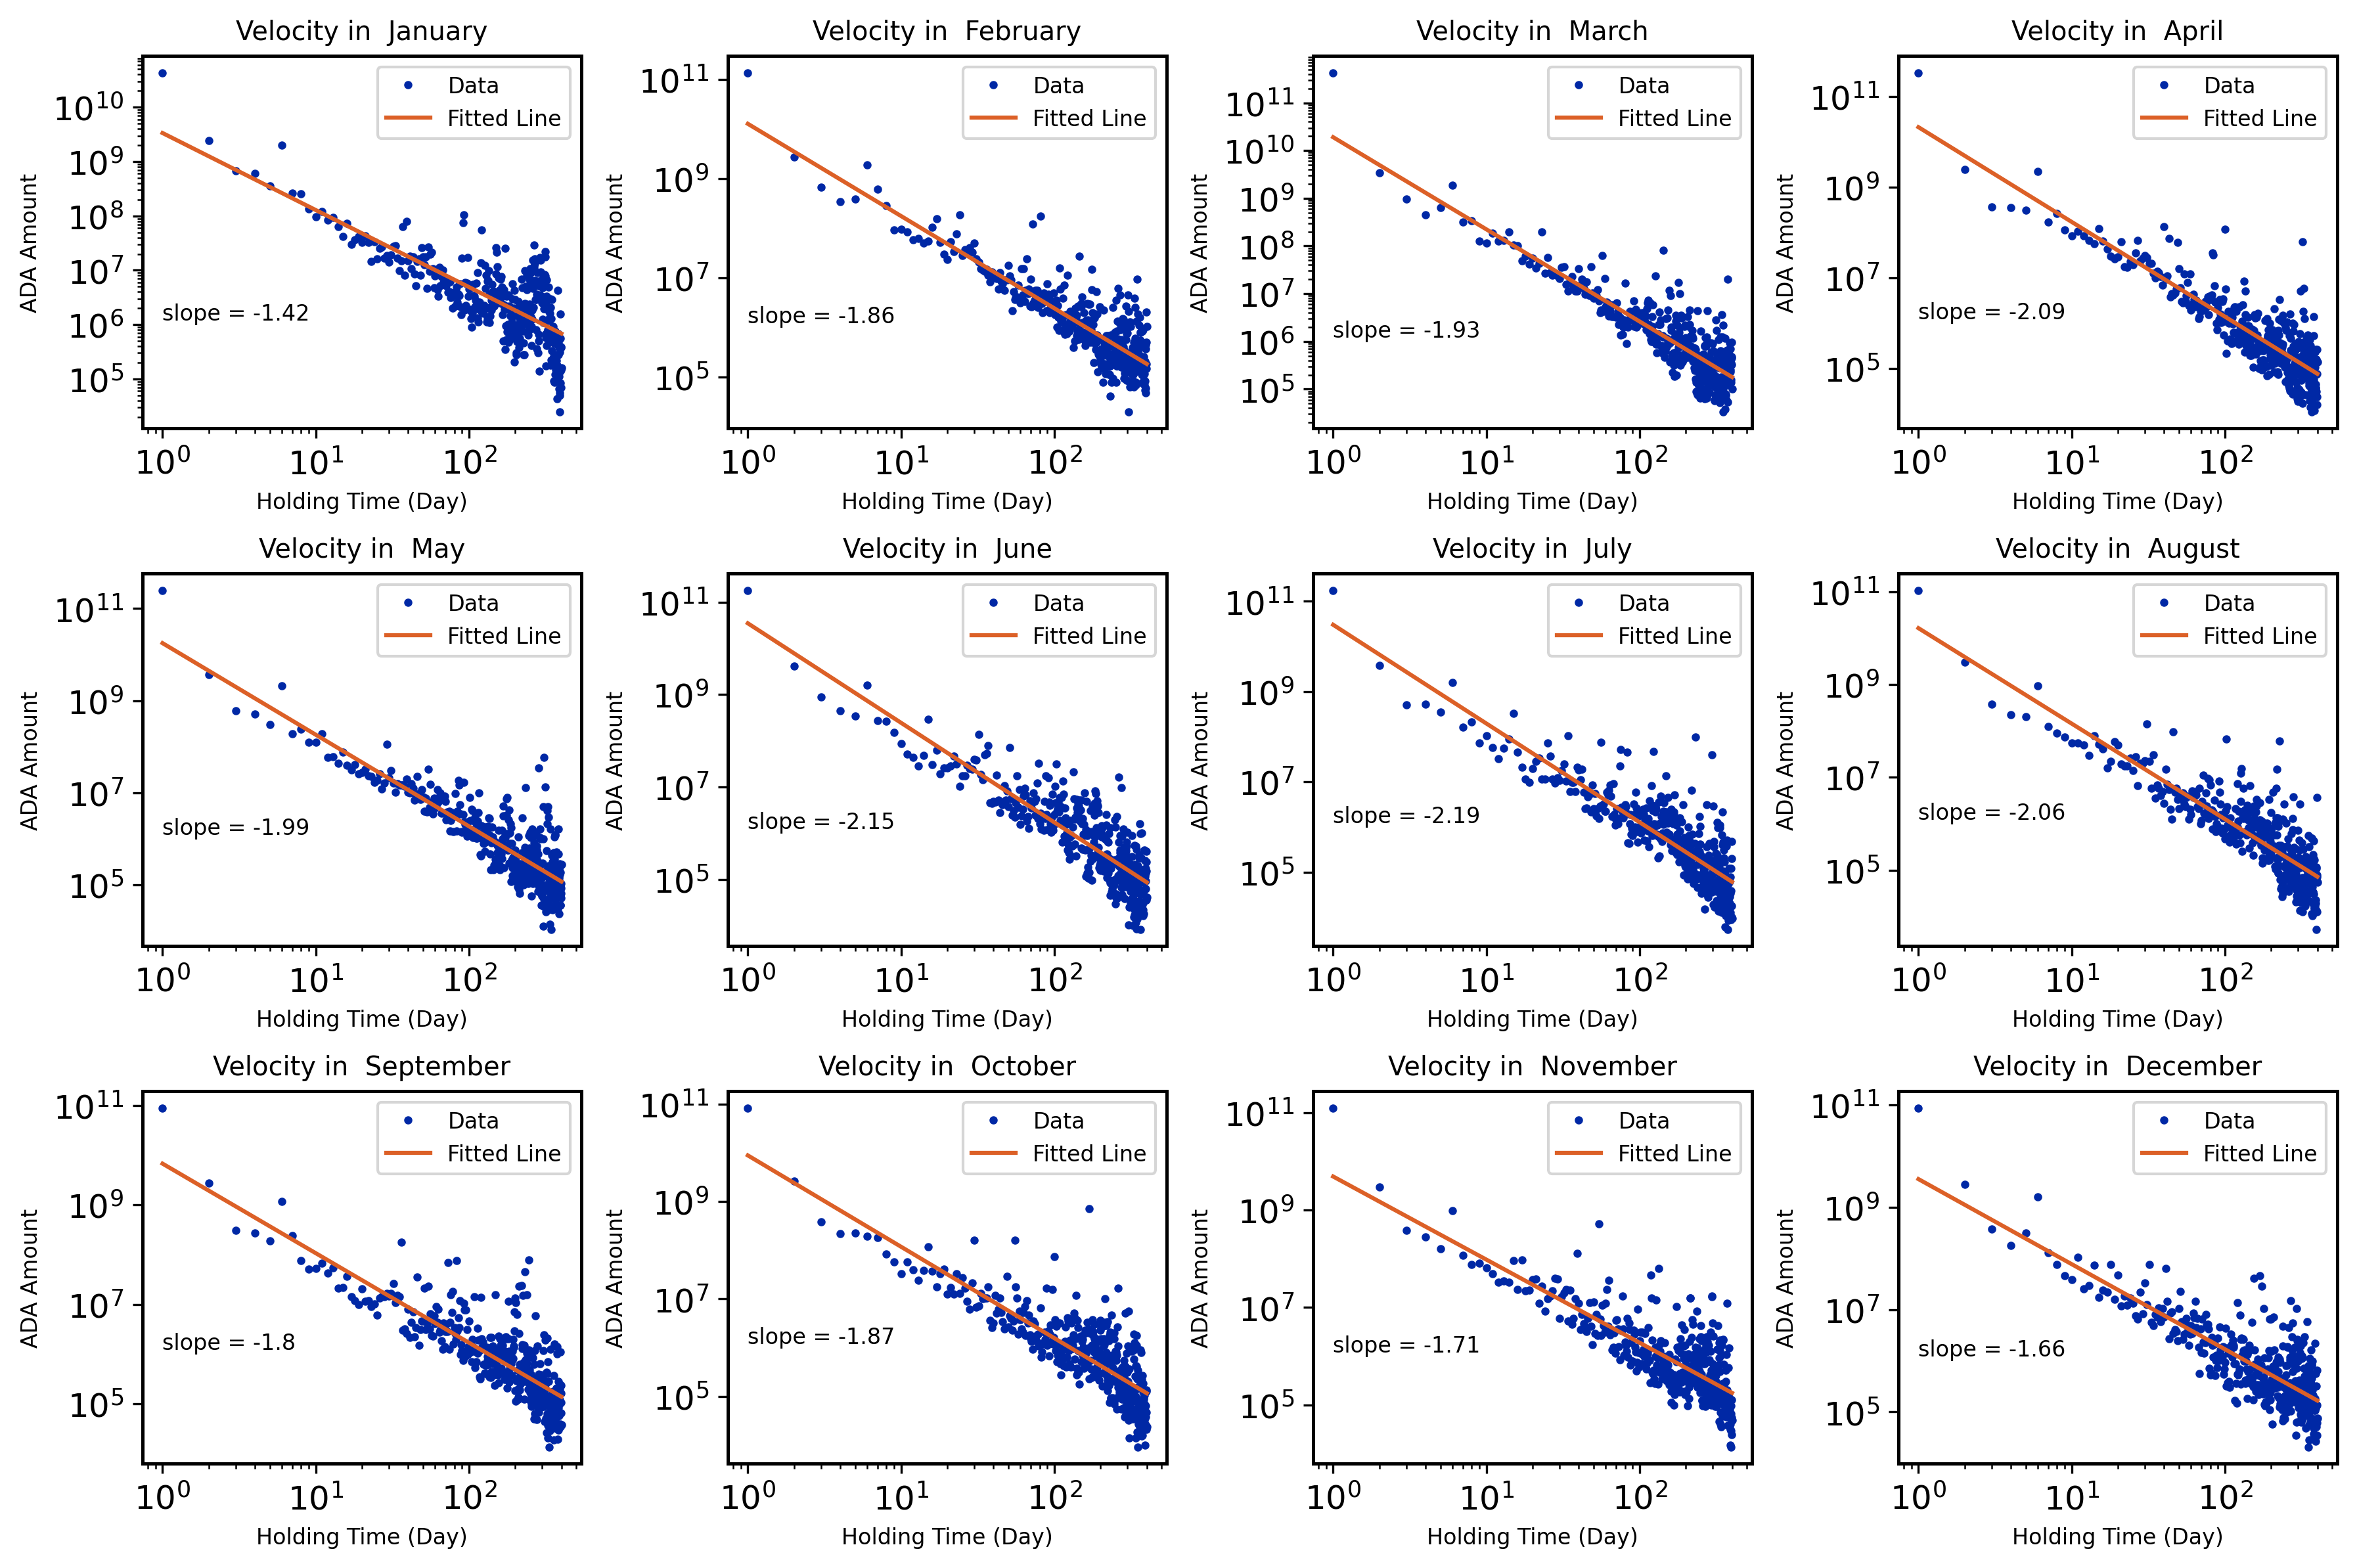

In [ ]:
# PLOT: ADA hodling time distribution

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')
import calendar


def linear_function(x, a, b):
    return a * x + b


# Create a figure with 12 subplots arranged in a 3x4 grid
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 8))

# Set the font size
plt.rcParams['font.size'] = 8


FIRST_DAY_of_each_month_2022     = [           395, 546, 760, 912,1126,1277,1491,1642,1856,1895     ] # Six months (from 2017 to 2022)


# Create your individual plots and customize them
for i, ax in tqdm(enumerate(axes.flatten())):
    file_name = BASE_ADDRESS + '/Holding_Days/' + 'HoldingDayArray__SampleRate_0001_From_' + str(FIRST_DAY_of_each_month_2022[i]).zfill(4) + '_To_' + str(FIRST_DAY_of_each_month_2022[i+1]).zfill(4) + '__Cardano_TXs_All.pickle'
    
    hodling_day_array = pickle.load(open(file_name, 'rb'))
    hodling_day_array_ADA = [0] * len(hodling_day_array)
    for j in range(len(hodling_day_array_ADA)):
            hodling_day_array_ADA[j] = float(hodling_day_array[j]) / 1000000
    #pick up only the first 400 values:
    hodling_day_array_ADA = hodling_day_array_ADA[:400]
    # Example data
    x = np.arange(1,len(hodling_day_array_ADA)+1)
    y = np.array(hodling_day_array_ADA)
    # Fit the line to the data
    params, _ = curve_fit(linear_function, np.log10(x), np.log10(y))

    slope = params[0]
    intercept = params[1]
    #print("Slope(" + str(calendar.month_name[i+1]) + "):", slope)
    #print("Intercept(" + str(calendar.month_name[i+1]) + "):", intercept)
    print(str(slope) + ',')
    
    # Generate points for the line
    x_line = np.linspace(min(x), max(x), 100)
    y_line = 10**(linear_function(np.log10(x_line), *params))
    # Plot the original data and the fitted line
    ax.plot(x, y, 'o', markersize=2, label='Data')
    ax.plot(x_line, y_line, label='Fitted Line')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Holding Time (Day)', fontsize=8)
    ax.set_ylabel('ADA Amount', fontsize=8)
    ax.legend(fontsize=8)
    ax.text(10**(0), 10**(6), 'slope = ' + str(round(slope, 2)), fontsize=8, verticalalignment='bottom', horizontalalignment='left')
    #ax.plot([1, 2, 3], [4, 5, 6])
    ax.set_title(f'Velocity in  {calendar.month_name[i+1]}')


# Adjust the layout and spacing between subplots
plt.tight_layout()

#plt.savefig('fig_velocity_monthly_30percent__2022.pdf', bbox_inches='tight', facecolor='white')

# Show the figure
plt.show()



In [ ]:
# Find ground truth for velocity:


# Subsequently, this value will be compared to the velocity calculated based on random sampling of transactions.



FIRST_DAY_of_each_month_2022   = [1561,1592,1620,1651,1681,1712,1742,1773,1804,1834,1865,1895,1926]



# Create your individual plots and customize them
for i, ax in tqdm(enumerate(axes.flatten())):
    file_name = BASE_ADDRESS + '/YuZhang_Holding_Days/' + 'YuZhang__HoldingDayArray__SampleRate_0001_From_' + str(FIRST_DAY_of_each_month_2022[i]).zfill(4) + '_To_' + str(FIRST_DAY_of_each_month_2022[i+1]).zfill(4) + '__Cardano_TXs_All.pickle'

    hodling_day_array = pickle.load(open(file_name, 'rb'))
    hodling_day_array_ADA = [0] * len(hodling_day_array)
    for j in range(len(hodling_day_array_ADA)):
            hodling_day_array_ADA[j] = float(hodling_day_array[j]) / 1000000

    #pick up only the first 400 values:
    hodling_day_array_ADA = hodling_day_array_ADA[:400]
    
    month_length = FIRST_DAY_of_each_month_2022[i+1] - FIRST_DAY_of_each_month_2022[i] + 1
    ground_truth_velocity = sum(hodling_day_array_ADA) / month_length

    x = np.arange(1,len(hodling_day_array_ADA)+1)
    y = np.array(hodling_day_array_ADA)

    #print('ground_truth_velocity[' + str(calendar.month_name[i+1]) + ']= ' + str(ground_truth_velocity))
    print(str(ground_truth_velocity) + ',')



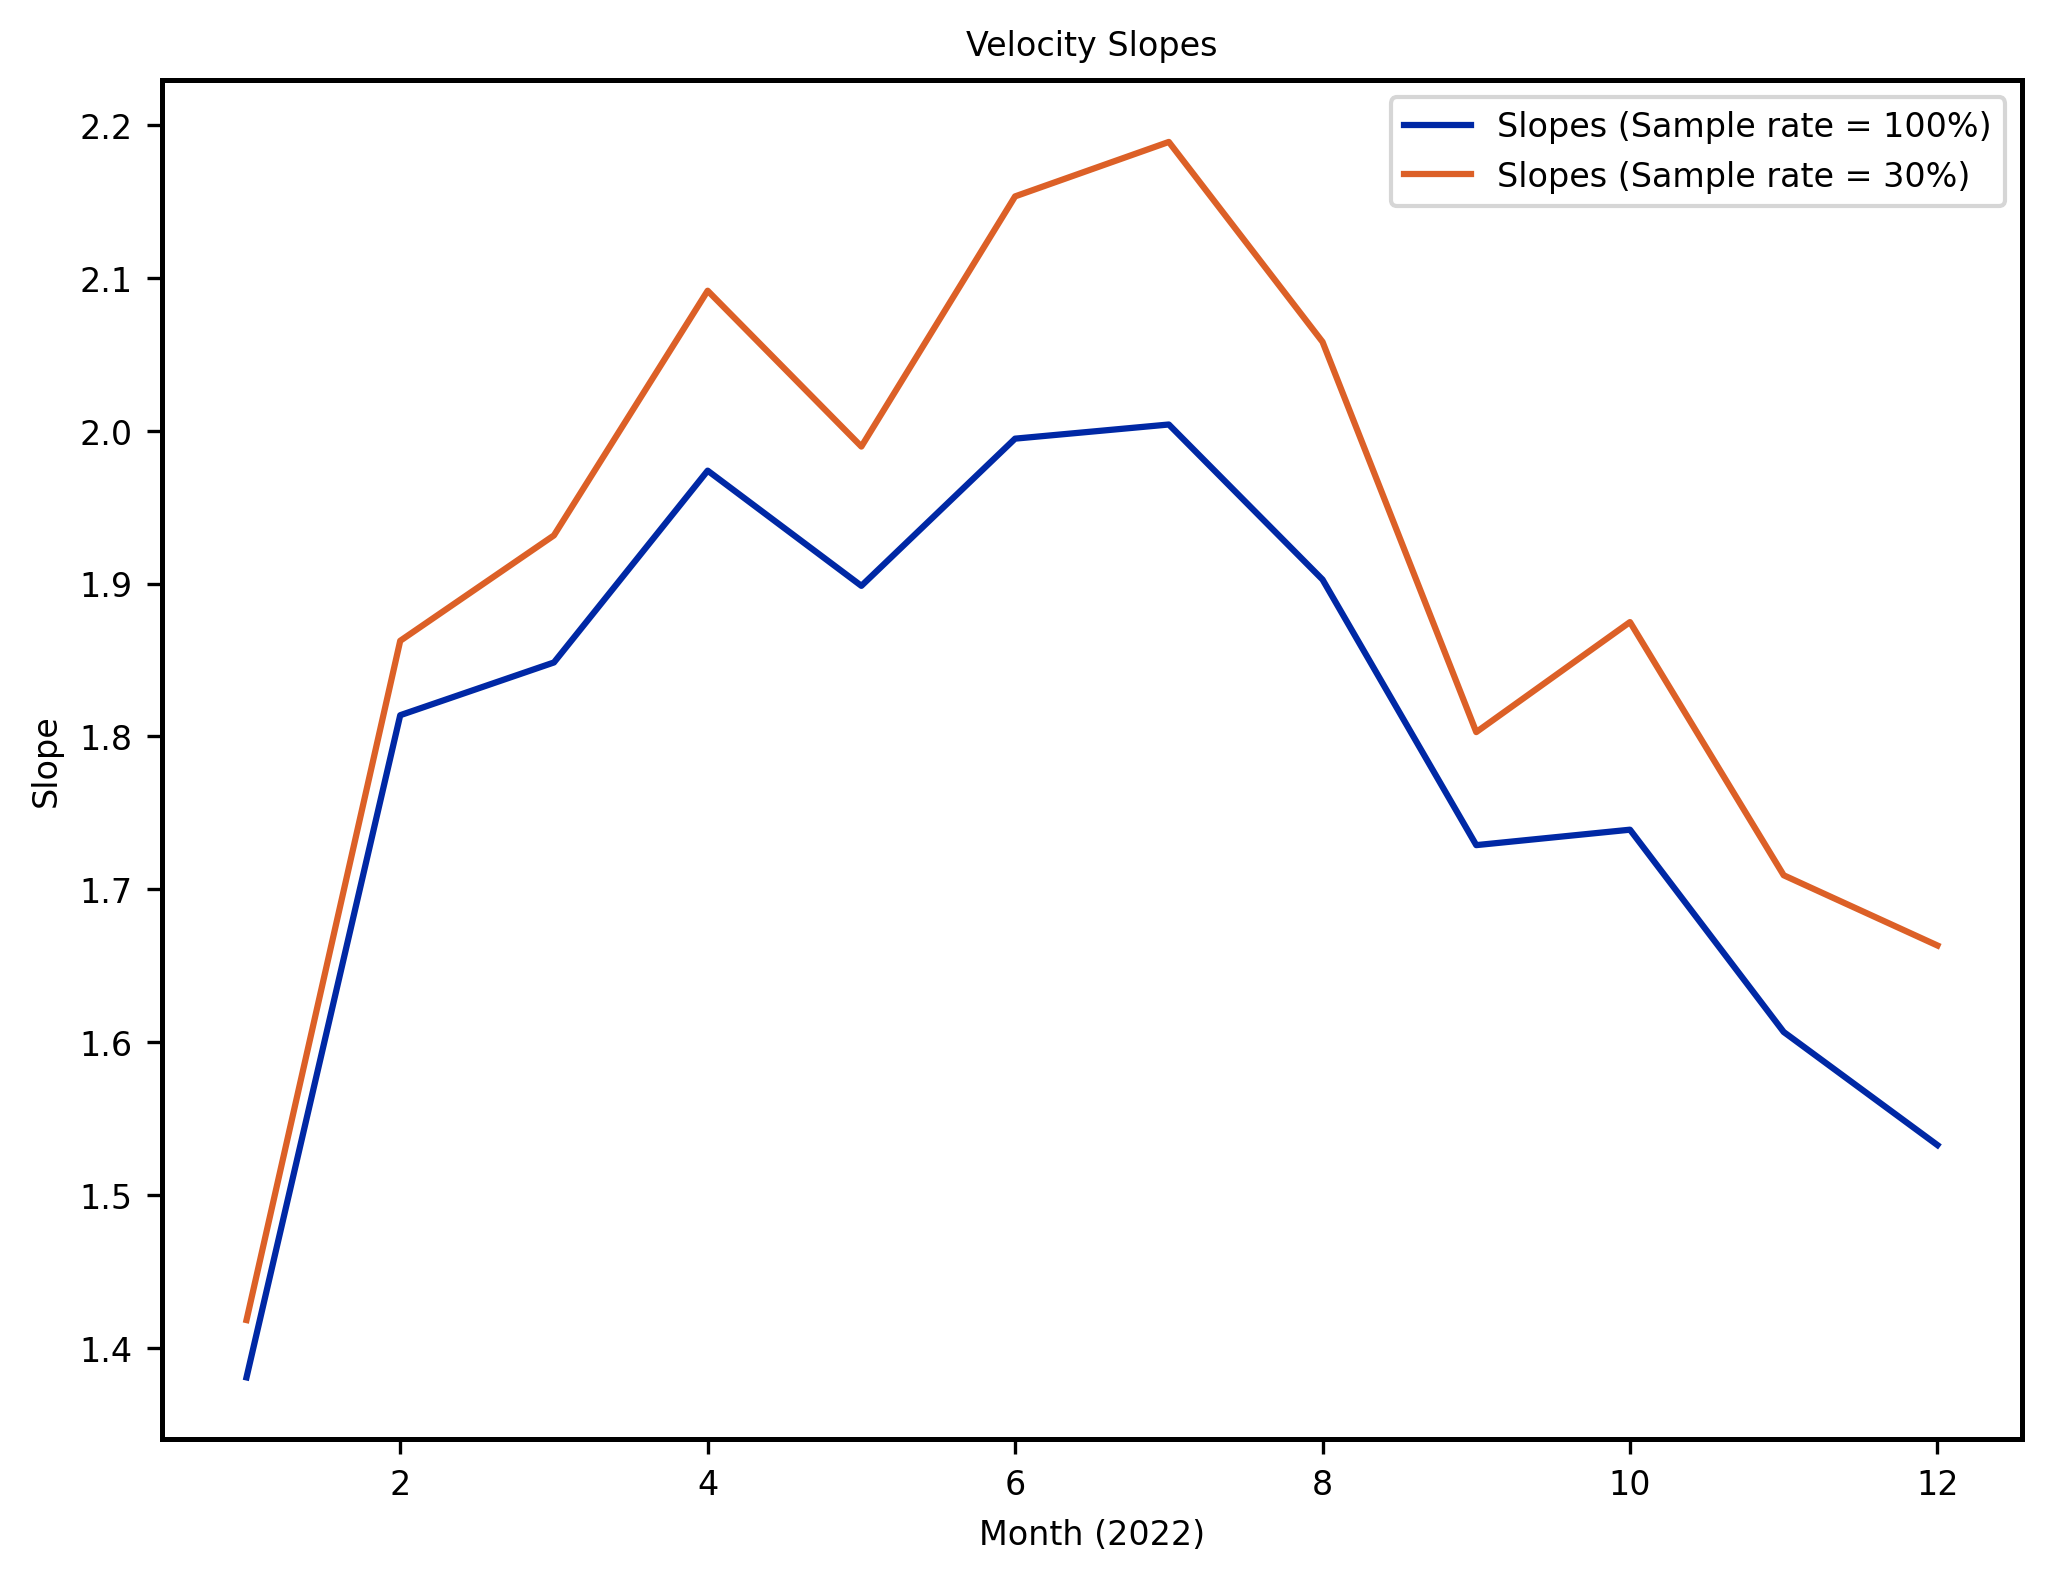

In [ ]:
# PLOT: compare ADA velocity time calculated with random sampling rates 100% and 30%:

import numpy as np
import matplotlib.pyplot as plt

# Set the font size
plt.rcParams['font.size'] = 8


# 1 month:
slopes_100_percent = [-1.3805555015996065,
-1.8138568717107955,
-1.8483702686640888,
-1.9738868472642057,
-1.898502908286038,
-1.9948230602124728,
-2.0040775140594587,
-1.902617943699492,
-1.7288432007126504,
-1.7389444086842065,
-1.6065794798906534,
-1.5325754751749825]


# 1 month:
slopes_30_percent = [-1.4180696487668696,
-1.8625391509140026,
-1.9315196847705107,
-2.091605928533007,
-1.989659827621932,
-2.153345307846216,
-2.1889719547305795,
-2.0581441990158864,
-1.802804650556879,
-1.8748015949010757,
-1.7091205015189,
-1.663174478704832]
    
#-1.4278730051119375,
#-1.9269453689288238,
#-1.90868090537373,
#-2.05668419000315,
#-2.038637592642142,
#-2.14343817399364,
#-2.179304285472793,
#-2.02702971637544,
#-1.810241804306238,
#-1.8939682391359218,
#-1.6825970832897164,
#-1.633828006406128]


# 6 months:
#slopes_100_percent = [-1.2818416003131272,
#-1.5044780389816446,
#-1.5579041997441874,
#-1.6020886257030376,
#-2.2073810923562878,
#-1.8199877124053103,
#-1.5939001913449156,
#-1.763742208785536,
#-1.6097758378225189]


# 6 months:
#slopes_30_percent = [-1.3111418310103478,
#-1.5501026736845522,
#-1.6083965622386138,
#-1.6146364573407728,
#-2.2507874319352,
#-1.866231272570478,
#-1.6299161813239214,
#-1.8334737438545359,
#-1.6984712498757741]

#slopes_30_percent = np.prod(slopes_30_percent)
#slopes_100_percent = np.prod(slopes_100_percent)


# Generate sample data
x = np.arange(1, 13)
#x = np.arange(1, 10)


# Create a new figure
plt.figure(figsize=(8, 6))

# Plot the first array
plt.plot(x, -np.array(slopes_100_percent), label='Slopes (Sample rate = 100%)')

# Plot the second array
plt.plot(x, -np.array(slopes_30_percent), label='Slopes (Sample rate = 30%)')

# Add labels and title
plt.xlabel('Month (2022)', fontsize=8)
plt.ylabel('Slope', fontsize=8)
plt.title('Velocity Slopes', fontsize=8)

# Add a legend
plt.legend(fontsize=8)


plt.savefig('fig_velocity_slopes_compare__2022.pdf', bbox_inches='tight', facecolor='white')


# Show the plot
plt.show()



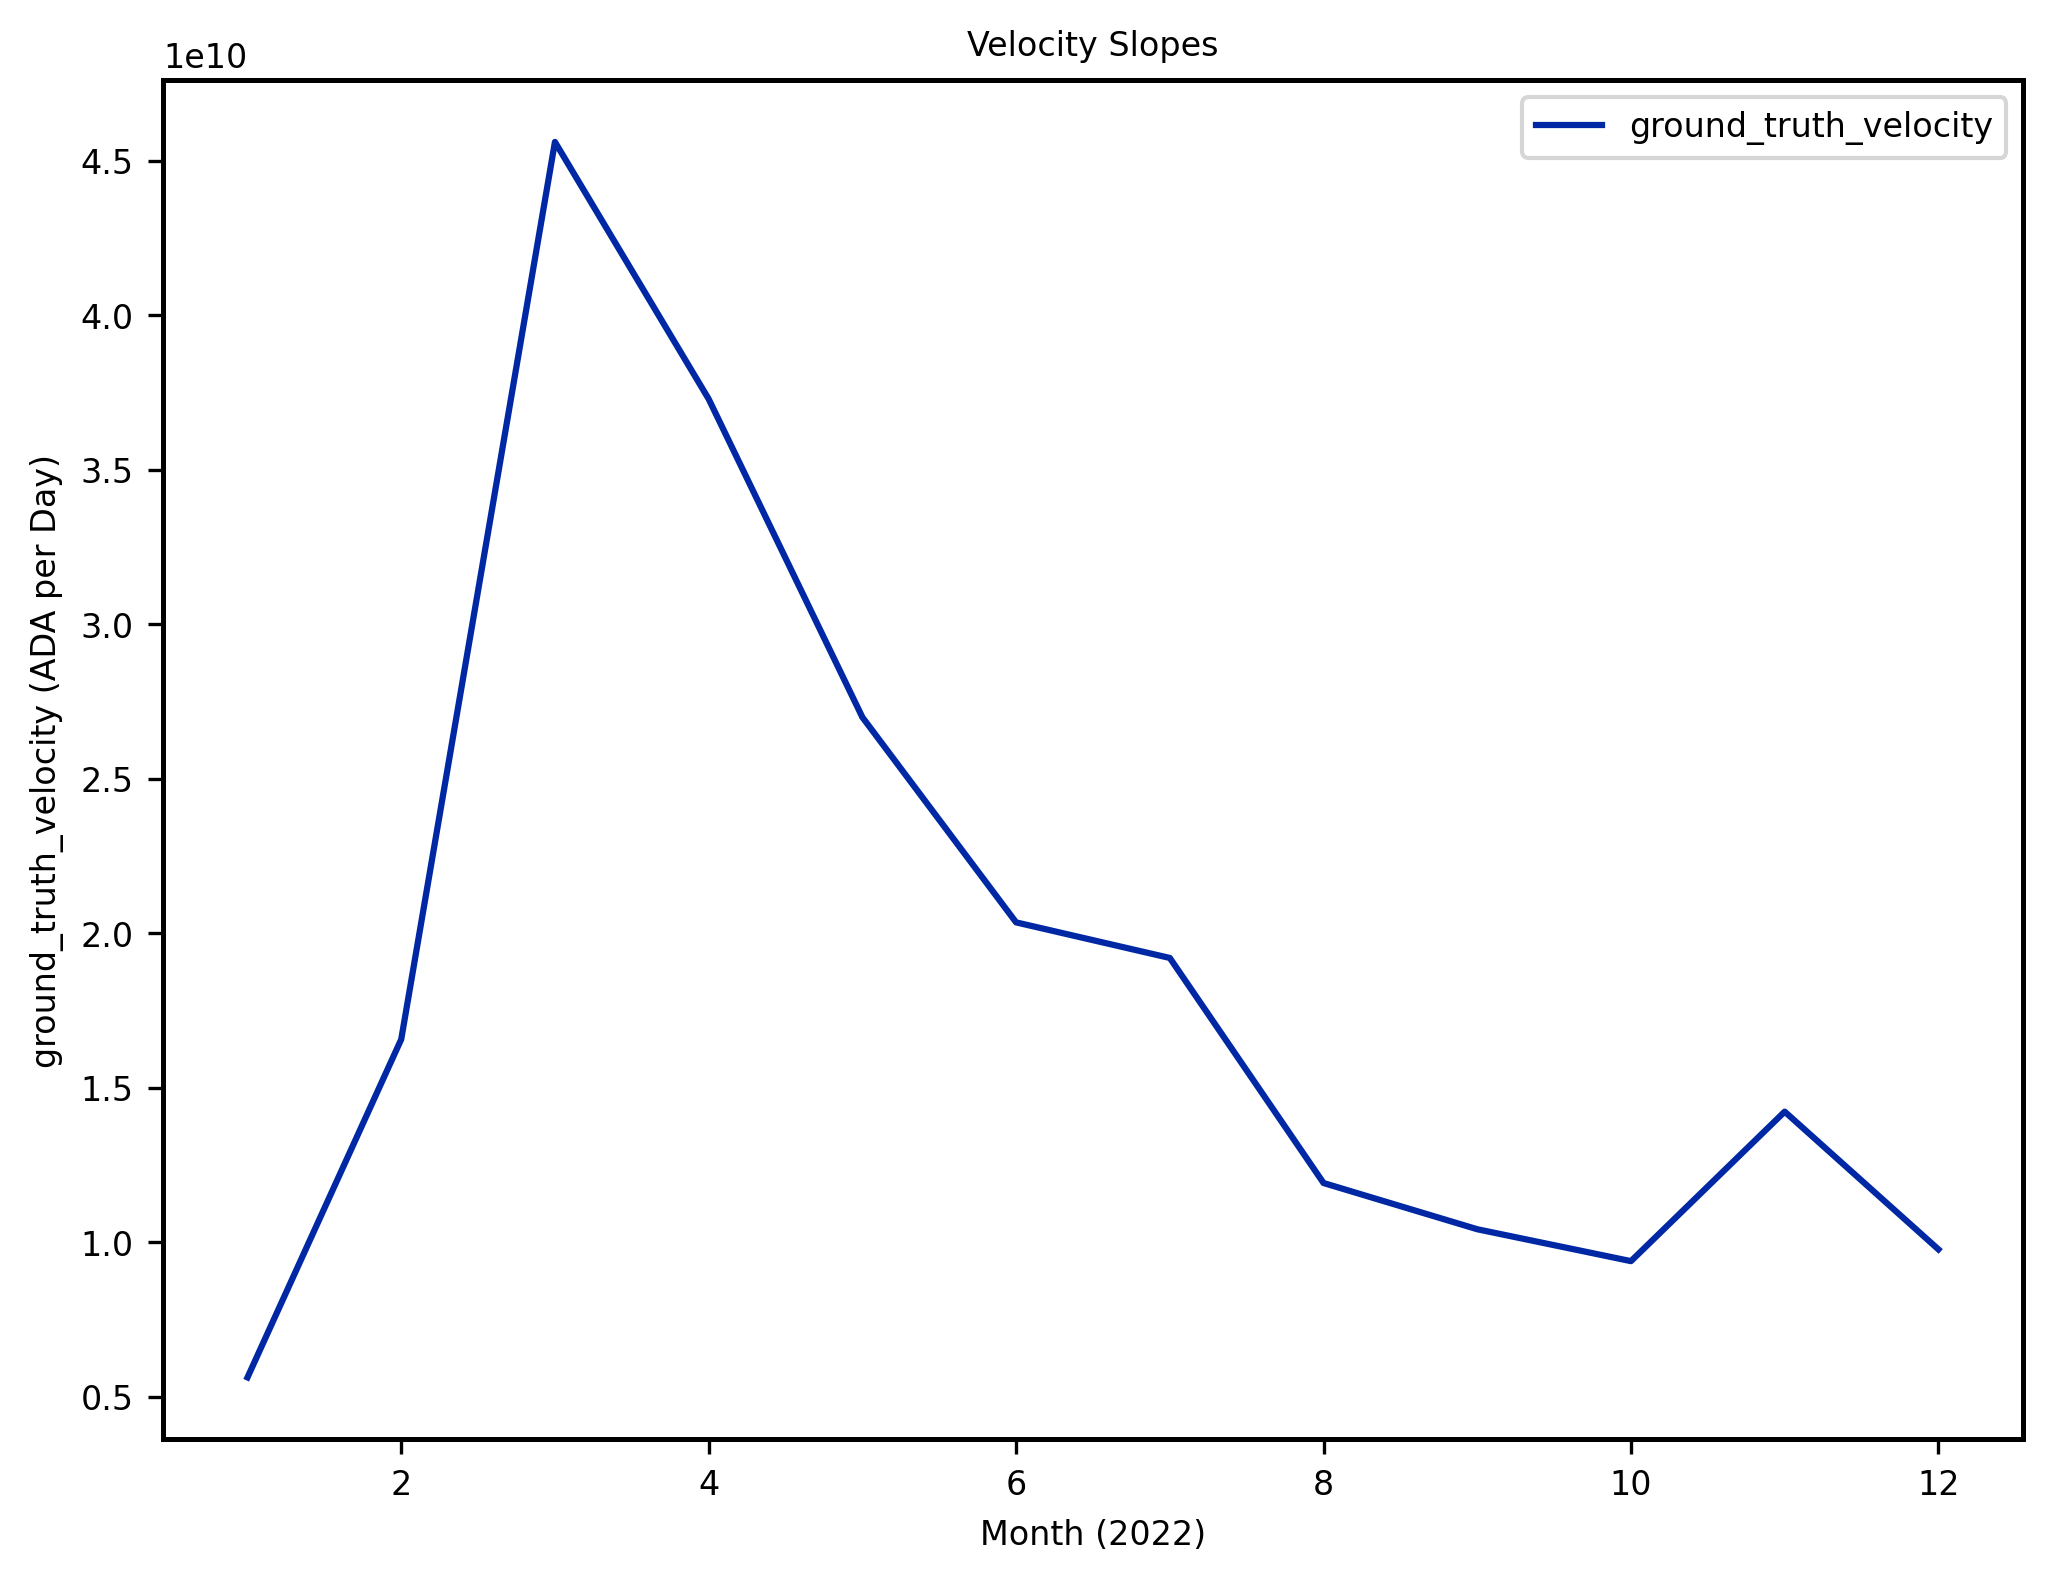

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set the font size
plt.rcParams['font.size'] = 8



ground_truth_velocity = [5622337665.771803,
16563101828.384222,
45603593753.89455,
37285508891.113884,
26986356864.0499,
20347431915.463184,
19195916275.748615,
11912444865.24096,
10416795319.70121,
9384538589.312378,
14222224378.127527,
9765548495.501799]


#ground_truth_velocity = [5630325497.159878,
#    16570497422.347834,
#    45608616318.316986,
#    37289967589.14388,
#    27075499644.34625,
#    20355459200.56458,
#    19200873819.300247,
#    11915727516.40628,
#    10424323813.734743,
#    9394153898.724947,
#    14232143041.952446,
#    9783502514.076357]


#ground_truth_velocity = [5622337665.771803,
#16563101828.384222,
#45603593753.89455,
#37285508891.113884,
#26986356864.0499,
#20347431915.463184,
#19195916275.748615,
#11912444865.24096,
#10416795319.70121,
#9384538589.312378,
#14222224378.127527,
#9765548495.501799]

#ground_truth_velocity = [5496870809.6292515,
#2566588668.362749,
#3038097946.093576,
#7821826068.568276,
#8417859615.222501,
#4686084511.051768,
#13056076314.764599,
#21146931994.003548,
#13312576677.939217]


# Generate sample data
x = np.arange(1, 13)
#x = np.arange(1, 10)


# Create a new figure
plt.figure(figsize=(8, 6))

# Plot the first array
plt.plot(x, ground_truth_velocity, label='ground_truth_velocity')


# Add labels and title
plt.xlabel('Month (2022)', fontsize=8)
plt.ylabel('ground_truth_velocity (ADA per Day)', fontsize=8)
plt.title('Velocity Slopes', fontsize=8)

# Add a legend
plt.legend(fontsize=8)


plt.savefig('fig_velocity_ground_truth__2022.pdf', bbox_inches='tight', facecolor='white')


# Show the plot
plt.show()

